#  **EDA por Disciplina** 
Este notebook apresenta uma análise exploratória detalhada da base de dados referente aos estudantes do ensino médio matriculados uma disciplina (Português ou Matemática) em duas escolas de portugal. O objetivo principal é identificar padrões e fatores que influenciam o desempenho acadêmico dos estudantes.

## Fonte dos Dados

Os dados utilizados nesta análise são provenientes do *UCI Machine Learning Repository*, especificamente do conjunto de dados "*Student Performance*". Este *dataset* contém informações sobre o desempenho acadêmico de estudantes do ensino médio em Portugal, incluindo notas em português e diversos fatores socioeconômicos.

**Fonte Original**: 

***UCI Machine Learning Repository - Student Performance Dataset***: 
*https://archive.ics.uci.edu/dataset/320/student+performance*

## Objetivos Gerais

A análise realizada visa:

1. Compreender o perfil dos alunos e suas características predominantes
2. Investigar fatores que influenciam o desempenho acadêmico  
3. Fornecer *insights* para intervenções educacionais baseadas em evidências

###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

# ***Português***

## 1. Bibliotecas, Módulos e Configurações Iniciais

In [2]:
#Importação dos Módulos e Funções Desenvolvidos

from modulos.pre_modelagem import importar_base, preparar_dados
from modulos.eda_functions import (
    plot_distribuicao_quantitativas, custom_heatmap,
    resumir_outliers, selecao_impacto_variaveis_categoricas,
    plot_boxplot_countplot, identificar_extremos_comparaveis,
    plot_top_diferencas_extremos, plot_boxplot_boxplot,
    plot_notas_faltas, aplicar_estilo_visual,
    diagnostico_impacto_variaveis_categoricas
)

from modulos.feature_selection import add_features_describe_pd,avaliacao_variacao_pontuacao_media_por_categoria


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

In [3]:
# Variáveis Globais
materia = "portugues" 
#ou:  materia = "matematica"
cores = 'azul' 
#ou: cores = 'verde'
#cores_reprovacao = 'laranja'
cores_reprovacao = 'vermelho'

In [4]:
#Importação da base de dados
df_o = importar_base(materia)
#importando a base de dados de treino para evitar o vazamento de dados
df_t = pd.read_csv(f'./data/dados_treino_{materia}_rs42.csv')

# 1. Visão geral e preparação dos dados

#### Conhecendo a Base - Original

In [5]:
df = df_o.copy()
#Amostra do Data Frame
df.head()

,escola,genero,idade,endereco,tamanho_familia,status_parental,escolaridade_mae,escolaridade_pai,profissao_mae,profissao_pai,motivo_escolha_escola,responsavel_legal,tempo_transporte,tempo_estudo,reprovacoes,apoio_escolar,apoio_familiar,aulas_particulares,atividades_extracurriculares,frequentou_creche,interesse_ensino_superior,acesso_internet,relacionamento_romantico,relacao_familiar,tempo_livre,frequencia_saidas,alcool_dias_uteis,alcool_fim_semana,saude,faltas,nota1,nota2,nota_final,aprovacao
0,Gabriel Pereira,Mulher,18,Urbano,Mais de 3 membros,Separados,4,4,Dona de casa,Professor(a),Curso específico,Mãe,2,2,0,Sim,Não,Não,Não,Sim,Sim,Não,Não,4,3,4,1,1,3,4,0,11,11,Aprovado
1,Gabriel Pereira,Mulher,17,Urbano,Mais de 3 membros,Juntos,1,1,Dona de casa,Outra profissão,Curso específico,Pai,1,2,0,Não,Sim,Não,Não,Não,Sim,Sim,Não,5,3,3,1,1,3,2,9,11,11,Aprovado
2,Gabriel Pereira,Mulher,15,Urbano,3 membros ou menos,Juntos,1,1,Dona de casa,Outra profissão,Outro motivo,Mãe,1,2,0,Sim,Não,Não,Não,Sim,Sim,Sim,Não,4,3,2,2,3,3,6,12,13,12,Aprovado
3,Gabriel Pereira,Mulher,15,Urbano,Mais de 3 membros,Juntos,4,2,Área da saúde,Serviços,Próximo de casa,Mãe,1,3,0,Não,Sim,Não,Sim,Sim,Sim,Sim,Sim,3,2,2,1,1,5,0,14,14,14,Aprovado
4,Gabriel Pereira,Mulher,16,Urbano,Mais de 3 membros,Juntos,3,3,Outra profissão,Outra profissão,Próximo de casa,Pai,1,2,0,Não,Sim,Não,Não,Sim,Sim,Não,Não,4,3,2,1,2,5,0,11,13,13,Aprovado


In [6]:
df.shape

(649, 34)

In [7]:
df_t.shape

(454, 34)

In [8]:
#Verificando se as colunas são as mesmas
df.columns.tolist() == df_t.columns.tolist()


True

In [9]:
#Checagem de duplicatas
df_t.duplicated().sum()==df.duplicated().sum()==0

True

#### Variáveis Locais

###### Agrupamento de Estatísticas

In [10]:
group_stats = {
    "Tendência Central": ["Média", "Mediana (50%)", "Moda"],
    "Dispersão": ["Desvio Padrão", "Coeficiente de Variação (CV)"],
    "Distribuição / Posição": ["Mínimo", "1º Quartil (25%)", "Mediana (50%)", "3º Quartil (75%)", "Máximo"],
    "Normalidade": ["Shapiro-Wilk (p-valor)"],
}


###### Notas

In [11]:
notas = ['nota1', 'nota2', 'nota_final']

**Categorização de Atributos**

- As variáveis foram categorizadas em três grupos principais:

    >    1. **Variáveis Categóricas Nominais**: Atributos qualitativos sem ordem natural
    >    2. **Variáveis Categóricas Ordinais**: Atributos qualitativos com ordem natural
    >    3. **Variáveis Numéricas**: Atributos quantitativos discretos

In [12]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais

variaveis_quantitativas = [
    'idade', 
    'faltas', 
    'nota1', 
    'nota2', 
    'nota_final'
]

In [13]:
df = df_t.copy()



# 2. Análise de Atributos Quantitativos e Outliers

Nesta seção, investiga-se as variáveis quantitativas presentes na base de dados da disciplina de Português, com foco em suas distribuições, medidas centrais, dispersão e possíveis valores atípicos (*outliers*). A análise explora ainda a normalidade dos dados, as relações entre variáveis contínuas, e a forma como essas características se associam ao desempenho dos estudantes.

Além disso, é explorado como atributos como notas e faltas se comportam entre os grupos de aprovação, e se existem padrões relevantes ao considerar a idade ou faixas etárias.

**Obtenção do Resumo Estatístico**

In [14]:
desc_q = add_features_describe_pd(df, variaveis_quantitativas)

Tamanho da amostra (numérico): 454.0


## 2.1 Resumo de Estatísticas Descritivas

Apresenta-se um panorama geral das variáveis quantitativas por meio de estatísticas descritivas clássicas.

**Objetivos:**  
- Compreender o comportamento de medidas centrais e de dispersão dos dados;  
- Identificar assimetrias e possíveis anomalias;  
- Avaliar a adequação de técnicas estatísticas nas etapas seguintes.




### 2.1.1 Medidas de Tendência Central e Dispersão

Examinam-se métricas como média, mediana, desvio padrão, valores extremos e amplitude interquartílica, com finalidade de caracterizar a distribuição das variáveis e suas variações internas.

In [15]:
mtcp = desc_q[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.7093,17.0,16,1.2338,0.074
faltas,3.8634,2.0,0,4.7418,1.227
nota1,11.4626,11.0,10,2.7327,0.238
nota2,11.5639,11.0,11,2.8862,0.250
nota_final,11.9537,12.0,11,3.1293,0.262


#### Oportunidade de investigação: Moda e notas mínimas de aprovação

In [16]:
len(df[df['nota_final']==11])/len(df['nota_final'])

0.16740088105726872

In [17]:
len(df[df['nota_final'].isin([10, 11])]) / len(df['nota_final'])

0.31277533039647576


### 2.1.2 Distribuições, Normalidade e Presença de Outliers

Analisa-se a forma das distribuições, com apoio de visualizações gráficas e testes de normalidade. Identificam-se potenciais outliers, cuja presença pode distorcer medidas e impactar análises posteriores.


In [18]:
stats_mddn =desc_q[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.0,17.0,18.0,22.0,1.08e-15
faltas,0.0,0.0,2.0,6.0,32.0,5.62e-24
nota1,0.0,10.0,11.0,13.0,19.0,7.56e-05
nota2,0.0,10.0,11.0,13.0,18.0,3.47e-10
nota_final,0.0,10.0,12.0,14.0,18.0,1.60e-13


##### **Presença de outliers**

> Os outliers foram identificados usando o método do Intervalo Interquartil (IQR):
>   - Limite Inferior = Q1 - 1.5 * IQR
>   - Limite Superior = Q3 + 1.5 * IQR

In [19]:
#resumir outliers 

resumo_outliers_numerico = resumir_outliers(df = df[variaveis_quantitativas])


,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
faltas,0.0,6.0,-9.0,15.0,17,0,17
nota2,10.0,13.0,5.5,17.5,16,7,9
nota1,10.0,13.0,5.5,17.5,10,5,5
nota_final,10.0,14.0,4.0,20.0,9,9,0
idade,16.0,18.0,13.0,21.0,1,0,1


#### 2.1.2.1 Perfil dos Outliers



##### **Levantamento de recursos para a análise**

In [20]:
variaveis_de_interesse = variaveis_categoricas + ['idade']

In [21]:
# Lista de variáveis com outliers
outliers_index_list = resumo_outliers_numerico.index.tolist()

In [22]:
limites_outliers = {}

for var in outliers_index_list:
    out_baixo = resumo_outliers_numerico.loc[var, 'Outliers < L1']
    out_alto = resumo_outliers_numerico.loc[var, 'Outliers > L3']

    if out_baixo > 0 or out_alto > 0:
        limites_outliers[var] = {
            'lim_inf': float(resumo_outliers_numerico.loc[var, 'Limite Inferior (L1)']),
            'lim_sup': float(resumo_outliers_numerico.loc[var, 'Limite Superior (L3)'])
        }


In [23]:
limites_outliers

{'faltas': {'lim_inf': -9.0, 'lim_sup': 15.0},
 'nota2': {'lim_inf': 5.5, 'lim_sup': 17.5},
 'nota1': {'lim_inf': 5.5, 'lim_sup': 17.5},
 'nota_final': {'lim_inf': 4.0, 'lim_sup': 20.0},
 'idade': {'lim_inf': 13.0, 'lim_sup': 21.0}}

**Notas**

##### **Perfil Outiliers - Nota1**

###### **Nota 1 - Limite Inferior**

In [24]:
var = 'nota1'
perfil = df[df[var] < limites_outliers[var]['lim_inf']]

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 5


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Mousinho da Silveira,4,80.0,40.0
genero,2,Mulher,3,60.0,40.0
endereco,2,Urbano,3,60.0,40.0
status_parental,2,Separados,3,60.0,40.0
profissao_mae,3,Serviços,2,40.0,60.0
profissao_pai,3,Outra profissão,2,40.0,60.0
motivo_escolha_escola,2,Curso específico,4,80.0,40.0
responsavel_legal,1,Mãe,5,100.0,20.0
apoio_escolar,2,Não,4,80.0,40.0


###### **Nota 1 - Limite Superior**

In [25]:
var = 'nota1'
perfil = df[df[var] > limites_outliers[var]['lim_sup']]

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 5


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,4,80.0,40.0
genero,2,Mulher,3,60.0,40.0
endereco,1,Urbano,5,100.0,20.0
status_parental,1,Juntos,5,100.0,20.0
profissao_mae,3,Dona de casa,2,40.0,60.0
profissao_pai,5,Área da saúde,1,20.0,100.0
motivo_escolha_escola,4,Curso específico,2,40.0,80.0
responsavel_legal,2,Mãe,3,60.0,40.0
apoio_escolar,1,Não,5,100.0,20.0


##### **Perfil Outiliers - Nota2**

###### **Nota 2 - Limite Inferior**

In [26]:
var = 'nota2'

perfil = df[df[var] < limites_outliers[var]['lim_inf']]
      
perfil = add_features_describe_pd(df= perfil
                                ,colunas=variaveis_de_interesse,
                                estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 7


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,1,Mousinho da Silveira,7,100.0,14.285714
genero,2,Mulher,5,71.428571,28.571429
endereco,2,Rural,4,57.142857,28.571429
status_parental,2,Separados,4,57.142857,28.571429
profissao_mae,4,Serviços,2,28.571429,57.142857
profissao_pai,3,Outra profissão,4,57.142857,42.857143
motivo_escolha_escola,2,Curso específico,5,71.428571,28.571429
responsavel_legal,3,Mãe,5,71.428571,42.857143
apoio_escolar,1,Não,7,100.0,14.285714


###### **Nota 2 - Limite Superior**

In [27]:
var = 'nota2'
perfil = df[df[var] > limites_outliers[var]['lim_sup']]

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 9


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,8,88.888889,22.222222
genero,2,Mulher,6,66.666667,22.222222
endereco,2,Urbano,8,88.888889,22.222222
status_parental,2,Juntos,8,88.888889,22.222222
profissao_mae,5,Outra profissão,4,44.444444,55.555556
profissao_pai,5,Serviços,3,33.333333,55.555556
motivo_escolha_escola,4,Reputação da escola,4,44.444444,44.444444
responsavel_legal,2,Mãe,7,77.777778,22.222222
apoio_escolar,2,Não,8,88.888889,22.222222


##### **Perfil Outiliers - Nota Final**

###### **Nota Final - Limite Inferior**

In [28]:
var = 'nota_final'
perfil = df[df[var] < limites_outliers[var]['lim_inf']]

print(perfil.value_counts())

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

escola                genero  idade  endereco  tamanho_familia     status_parental  escolaridade_mae  escolaridade_pai  profissao_mae    profissao_pai    motivo_escolha_escola  responsavel_legal  tempo_transporte  tempo_estudo  reprovacoes  apoio_escolar  apoio_familiar  aulas_particulares  atividades_extracurriculares  frequentou_creche  interesse_ensino_superior  acesso_internet  relacionamento_romantico  relacao_familiar  tempo_livre  frequencia_saidas  alcool_dias_uteis  alcool_fim_semana  saude  faltas  nota1  nota2  nota_final  aprovacao
Gabriel Pereira       Homem   18     Urbano    3 membros ou menos  Juntos           1                 1                 Outra profissão  Outra profissão  Curso específico       Mãe                1                 1             2            Não            Não             Não                 Não                           Sim                Não                        Sim              Sim                       2                 3            5       

,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Mousinho da Silveira,8,88.888889,22.222222
genero,2,Homem,5,55.555556,22.222222
endereco,2,Rural,6,66.666667,22.222222
status_parental,2,Juntos,7,77.777778,22.222222
profissao_mae,4,Outra profissão,4,44.444444,44.444444
profissao_pai,3,Outra profissão,7,77.777778,33.333333
motivo_escolha_escola,4,Curso específico,5,55.555556,44.444444
responsavel_legal,3,Mãe,7,77.777778,33.333333
apoio_escolar,2,Não,8,88.888889,22.222222


**Faltas**

##### **Perfil Outiliers - Faltas**

###### **Faltas - Limite Superior**

In [29]:
var = 'faltas'
perfil = df[df[var] > limites_outliers[var]['lim_sup']]

perfil = add_features_describe_pd(df=perfil,colunas=variaveis_de_interesse,estudo_frequencia=True)

perfil

Tamanho da amostra (categórico): 17


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,1,Gabriel Pereira,17,100.0,5.882353
genero,2,Mulher,11,64.705882,11.764706
endereco,2,Urbano,14,82.352941,11.764706
status_parental,2,Juntos,12,70.588235,11.764706
profissao_mae,4,Outra profissão,6,35.294118,23.529412
profissao_pai,4,Outra profissão,8,47.058824,23.529412
motivo_escolha_escola,4,Próximo de casa,8,47.058824,23.529412
responsavel_legal,3,Mãe,10,58.823529,17.647059
apoio_escolar,1,Não,17,100.0,5.882353


##### **Principais padrões observados:**

- **Notas muito baixas (nota1, nota2, nota_final)** estão associadas a:
  - Forte presença da escola *Mousinho da Silveira*;
  - Baixa escolaridade dos pais, ausência de aulas particulares, apoio escolar e familiar;
  - Alta frequência de pais separados, famílias grandes, e consumo de álcool já na semana;
  - Tempo de estudo reduzido e tempo de transporte elevado.

- **Notas muito altas (nota1 > 15, nota2 > 17)** foram observadas em perfis com:
  - Melhor estrutura familiar (pais juntos, apoio familiar presente);
  - Maior escolaridade dos responsáveis, dedicação ao estudo e baixas reprovações;
  - Acesso à internet e interesse declarado no ensino superior.

- **Nota final < 4** seguiu padrões similares aos de nota1 e nota2 baixas, reforçando que há um grupo recorrente com múltiplos indicadores de vulnerabilidade.

- **Faltas excessivas (> 15)** foram associadas a:
  - Perfil mais escolarizado (Gabriel Pereira), mas com sinais de desorganização pessoal;
  - Tempo de estudo ainda presente, porém elevado tempo livre;
  - Pouco envolvimento extracurricular e maior prevalência de motivos “próximo de casa” para a escolha da escola;
  - Ainda assim, 76% dos alunos com faltas altas afirmam querer cursar o ensino superior, o que reforça a desconexão entre aspiração e prática.

---

#### Conclusão

Esses perfis revelam que os *outliers* identificados não são ruído, mas sim **sintomas de grupos extremos com potencial explicativo e importância social**. Por isso, **foram mantidos** no conjunto de dados, tanto para preservar a representatividade da realidade escolar, quanto para permitir a identificação de padrões relevantes no processo de modelagem.


### 2.1.3 Visualizações

Exploram-se, de forma visual, os casos extremos identificados.


**Distribuição das Notas**

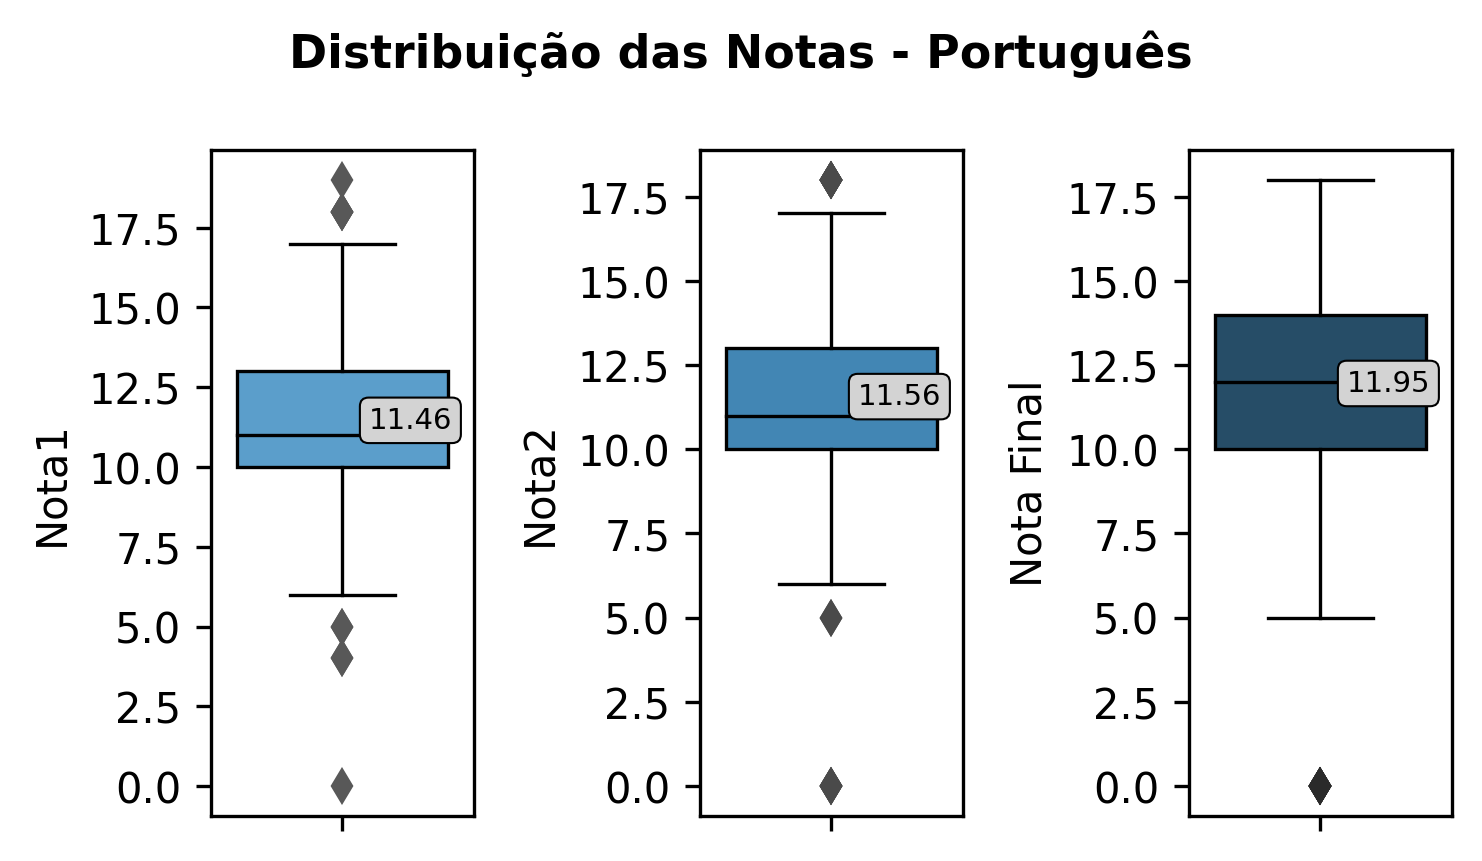

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [30]:
plot_distribuicao_quantitativas(df,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia)
                                

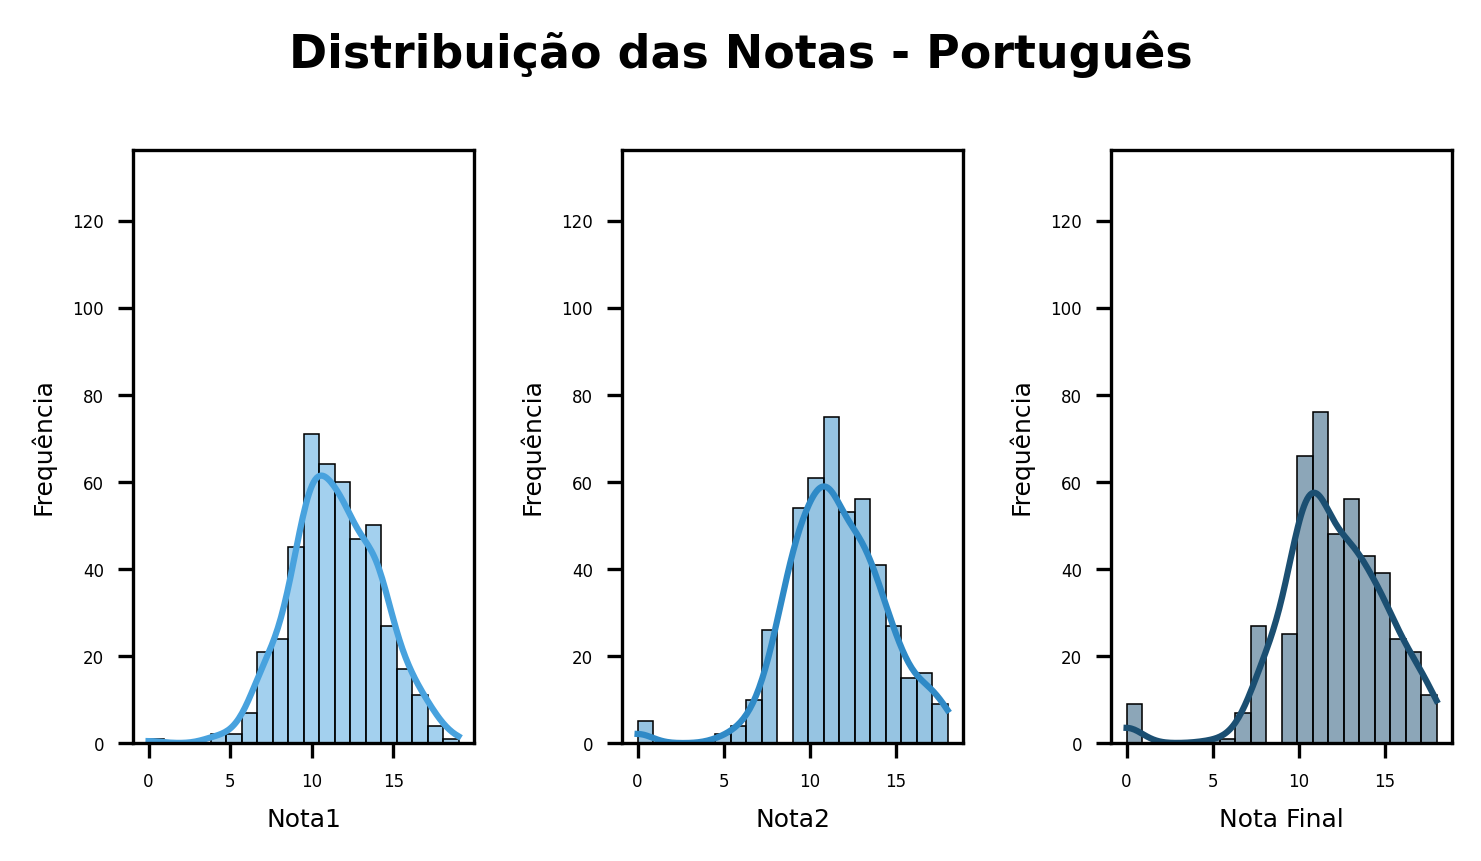

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [31]:
plot_distribuicao_quantitativas(df,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                modo = 'hist')
                                

**Distribuição de Idade e Faltas**

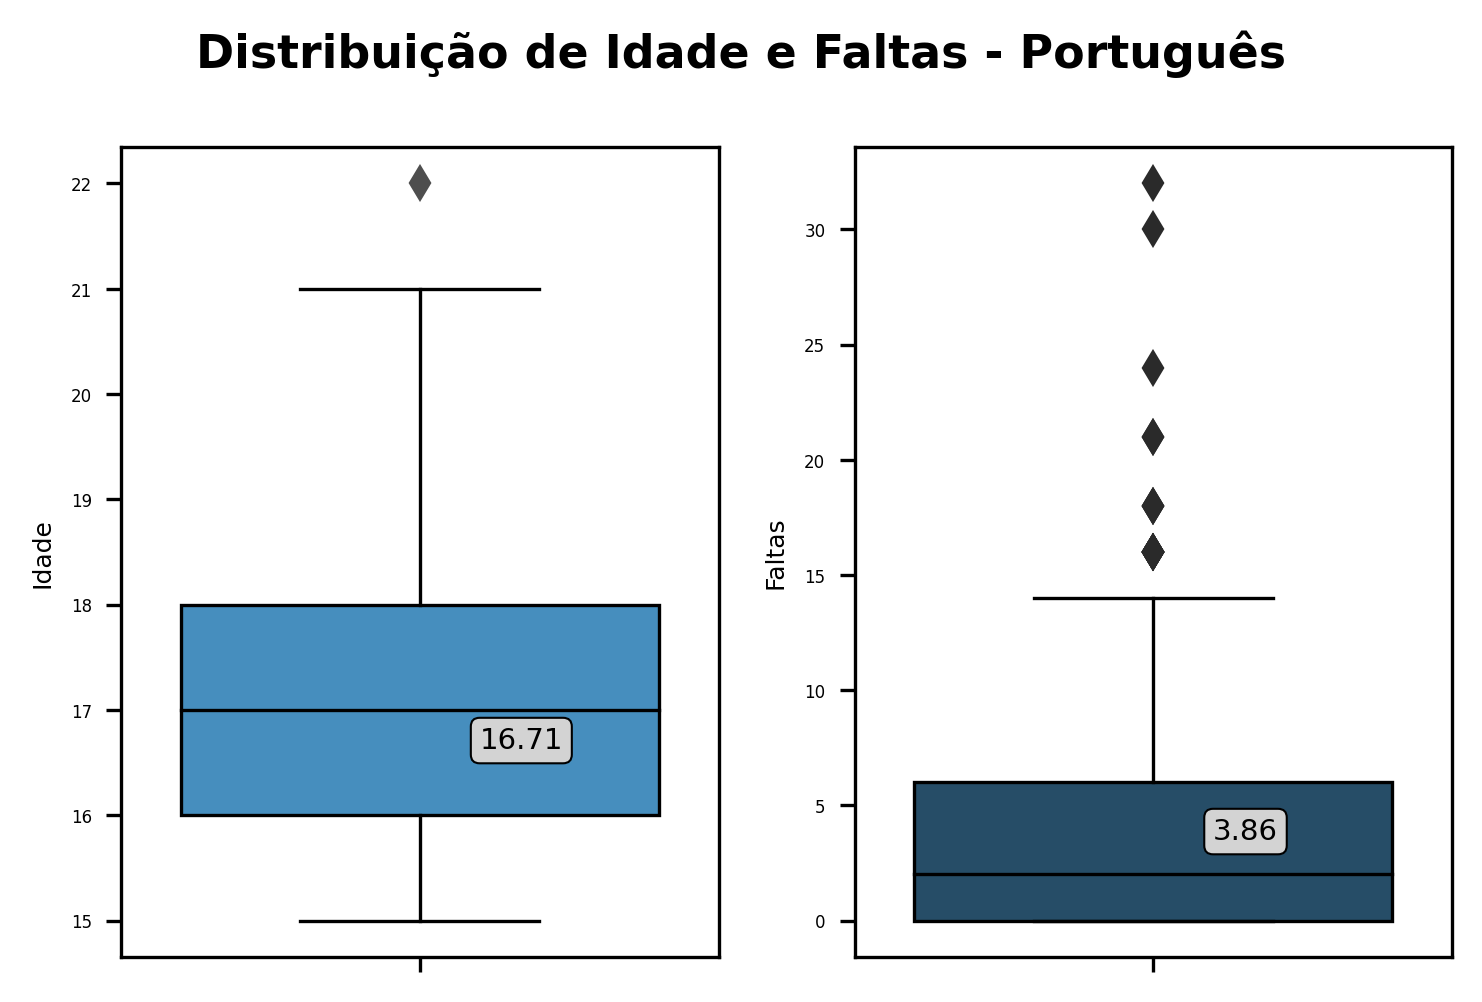

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:ylabel='Idade'>, <AxesSubplot:ylabel='Faltas'>],
       dtype=object))

In [32]:
plot_distribuicao_quantitativas(df,
                                colunas=['idade','faltas'],
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia)

### 2.1.4 Síntese Analítica dos Destaques

Apresentam-se a seguir os principais achados obtidos a partir da análise estatística descritiva e exploratória das variáveis quantitativas:

- **Notas (G1, G2, G3)**:
  - Distribuições levemente assimétricas à esquerda, com cauda mais acentuada para notas baixas;
  - A média das notas aumenta progressivamente de G1 (11,46) para G3 (11,95), com crescimento também no desvio padrão;
  - Resultados do teste de Shapiro-Wilk (p < 0,001) rejeitam a hipótese de normalidade para todas as notas;
  - Foram identificados outliers em todas as notas, principalmente notas próximas de zero.

- **Faltas**:
  - Mediana igual a 2 faltas, mas com forte assimetria à direita (muitos valores baixos e poucos valores extremos);
  - Coeficiente de variação elevado (CV ≈ 1,23), indicando alta dispersão relativa;
  - 17 outliers superiores identificados, com máximas superiores a 30 faltas.

- **Idade**:
  - Distribuição concentrada entre 15 e 18 anos, com mediana de 17;
  - Apenas um caso considerado outlier (idade = 22 anos);
  - Baixa variabilidade (CV ≈ 0,07), sugerindo homogeneidade do grupo amostral.

- **Considerações gerais**:
  - A ausência de normalidade nas distribuições e a presença de outliers reforçam a adoção de métodos estatísticos não paramétricos e técnicas robustas;
  - A distribuição de faltas e de notas sugere perfis de comportamento escolar heterogêneos, com possíveis perfis de alto risco evidenciados por valores extremos.

- **Distribuição das notas e a Moda**:
  - A moda de `nota_final` é 11 (≈16,7% dos casos), seguida pela nota 10 (≈31,3%);
  - Aproximadamente 48% dos estudantes concentram-se exatamente no limiar de aprovação ou apenas um ponto acima;
  - Este padrão configura uma oportunidade analítica relevante sobre o perfil dos estudantes "limítrofes" e a dinâmica da avaliação final.



## 2.2 Análises Bivariadas Quantitativas

Nesta etapa, investigam-se as relações entre pares de variáveis quantitativas, com o objetivo de identificar padrões de associação entre atributos como faltas, idade e notas escolares. 

### 2.2.1 Análise das Notas por Grupo de Aprovação

Essa comparação é útil para caracterizar os perfis de desempenho ao longo das etapas avaliativas e pode revelar trajetórias de recuperação, estabilidade ou declínio.


In [33]:
df_aprovados = df[df['nota_final'] >= 10]
df_reprovados = df[df['nota_final'] < 10]
print(f' contagem:\n aprovados: {df_aprovados.shape[0]}, reprovados: {df_reprovados.shape[0]}')
print(f' porcentagem:\n aprovados: {df_aprovados.shape[0]/df.shape[0]*100:.2f}%, reprovados: {df_reprovados.shape[0]/df.shape[0]*100:.2f}%')

 contagem:
 aprovados: 384, reprovados: 70
 porcentagem:
 aprovados: 84.58%, reprovados: 15.42%


In [34]:
df_ap_descricao = add_features_describe_pd(df_aprovados, variaveis_quantitativas)
df_re_descricao = add_features_describe_pd(df_reprovados, variaveis_quantitativas)

Tamanho da amostra (numérico): 384.0
Tamanho da amostra (numérico): 70.0


##### **Resumos Estatísticos**

**Aprovados**

In [35]:
mtcp = df_ap_descricao[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.6693,17.0,16,1.2081,0.072
faltas,3.7630,2.0,0,4.6730,1.242
nota1,12.1276,12.0,10,2.3598,0.195
nota2,12.2891,12.0,11,2.3174,0.189
nota_final,12.8281,13.0,11,2.2626,0.176


In [36]:
stats_mddn =df_ap_descricao[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.0,17.0,18.0,21.0,2.83e-14
faltas,0.0,0.0,2.0,6.0,32.0,1.50e-22
nota1,0.0,10.0,12.0,14.0,19.0,1.60e-08
nota2,8.0,11.0,12.0,14.0,18.0,3.22e-10
nota_final,10.0,11.0,13.0,14.0,18.0,2.44e-13


In [37]:
resumo_outliers_ap = resumir_outliers(df = df_aprovados[variaveis_quantitativas])

,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
faltas,0.0,6.0,-9.0,15.0,14,0,14
nota1,10.0,14.0,4.0,20.0,1,1,0
idade,16.0,18.0,13.0,21.0,0,0,0
nota2,11.0,14.0,6.5,18.5,0,0,0
nota_final,11.0,14.0,6.5,18.5,0,0,0


##### **Oportunidade de Investigação - Faltas elevadas entre aprovados**

In [38]:
add_features_describe_pd(df_aprovados[df_aprovados['faltas']>15],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 14.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,17.571429,1.342460,16.0,17.00,17.0,18.00,21.0,17,1.30e-02,0.076
faltas,19.285714,5.283189,16.0,16.00,17.0,20.25,32.0,16,1.94e-04,0.274
nota1,11.071429,1.730464,9.0,10.00,10.5,12.50,14.0,10,2.98e-02,0.156
nota2,11.357143,1.823232,8.0,10.25,11.0,12.75,15.0,11,8.90e-01,0.161
nota_final,11.928571,1.899971,10.0,10.00,12.0,13.00,16.0,10,6.99e-02,0.159


In [39]:
add_features_describe_pd(df[df['faltas']>15],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 17.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,17.352941,1.411612,15.0,17.0,17.0,18.0,21.0,17,9.78e-02,0.081
faltas,19.176471,5.040279,16.0,16.0,16.0,21.0,32.0,16,9.14e-05,0.263
nota1,10.647059,1.835115,8.0,9.0,10.0,11.0,14.0,10,4.24e-02,0.172
nota2,10.764706,2.136861,7.0,9.0,11.0,12.0,15.0,11,8.50e-01,0.199
nota_final,11.294118,2.229482,8.0,10.0,11.0,13.0,16.0,10,4.84e-01,0.197


In [40]:
add_features_describe_pd(df_aprovados[df_aprovados['faltas']<=15],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 370.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,16.635135,1.191368,15.0,16.0,17.0,18.0,21.0,16,4.01e-14,0.072
faltas,3.175676,3.491989,0.0,0.0,2.0,6.0,14.0,0,7.79e-19,1.100
nota1,12.167568,2.372843,0.0,10.0,12.0,14.0,19.0,11,4.16e-08,0.195
nota2,12.324324,2.328730,8.0,11.0,12.0,14.0,18.0,11,4.05e-10,0.189
nota_final,12.862162,2.270328,10.0,11.0,13.0,15.0,18.0,11,5.52e-13,0.177


In [41]:
add_features_describe_pd(df[df['faltas']<=15],colunas=variaveis_quantitativas)

Tamanho da amostra (numérico): 437.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
idade,16.684211,1.221389,15.0,16.0,17.0,18.0,22.0,16,1.80e-15,0.073
faltas,3.267735,3.595893,0.0,0.0,2.0,6.0,14.0,0,1.54e-20,1.100
nota1,11.494279,2.758322,0.0,10.0,11.0,13.0,19.0,10,1.45e-04,0.240
nota2,11.594966,2.908903,0.0,10.0,11.0,13.0,18.0,11,4.54e-10,0.251
nota_final,11.979405,3.158219,0.0,10.0,12.0,14.0,18.0,11,2.24e-13,0.264


**Reprovados**

In [42]:
mtcp = df_re_descricao[group_stats["Tendência Central"]+group_stats["Dispersão"]].round(4)
mtcp

,Média,Mediana (50%),Moda,Desvio Padrão,Coeficiente de Variação (CV)
Variável,,,,,
idade,16.9286,17.0,17,1.3548,0.080
faltas,4.4143,2.0,0,5.1033,1.156
nota1,7.8143,8.0,7,1.4675,0.188
nota2,7.5857,8.0,8,2.4287,0.320
nota_final,7.1571,8.0,8,2.8774,0.402


In [43]:
stats_mddn =df_re_descricao[group_stats["Distribuição / Posição"]+group_stats["Normalidade"]]
stats_mddn

,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Shapiro-Wilk (p-valor)
Variável,,,,,,
idade,15.0,16.00,17.0,18.0,22.0,8.01e-05
faltas,0.0,0.00,2.0,8.0,24.0,1.11e-07
nota1,4.0,7.00,8.0,9.0,11.0,7.30e-03
nota2,0.0,7.00,8.0,9.0,11.0,4.22e-10
nota_final,0.0,7.25,8.0,9.0,9.0,1.59e-12


In [44]:
#resumir outliers 
resumo_outliers_re = resumir_outliers(df = df_reprovados[variaveis_quantitativas])

,Q1 (1º Quartil),Q3 (3º Quartil),Limite Inferior (L1),Limite Superior (L3),Outliers Totais,Outliers < L1,Outliers > L3
nota_final,7.25,9.0,4.625,11.625,9,9,0
nota2,7.00,9.0,4.000,12.000,5,5,0
idade,16.00,18.0,13.000,21.000,1,0,1
faltas,0.00,8.0,-12.000,20.000,1,0,1
nota1,7.00,9.0,4.000,12.000,0,0,0


##### **Visualições: Distribuição das Notas**

**Aprovados**

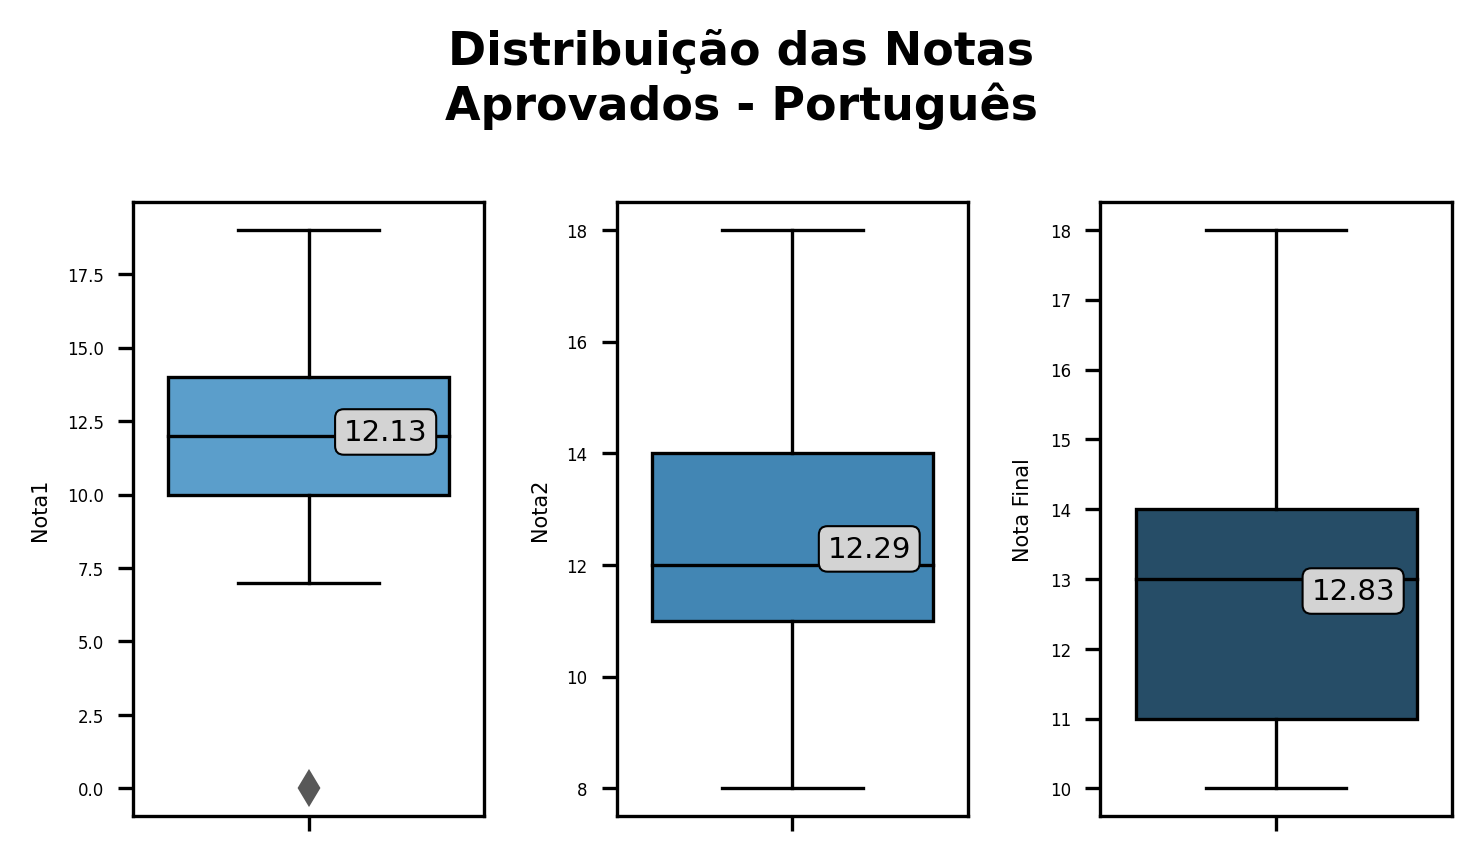

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [45]:
plot_distribuicao_quantitativas(df_aprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                titulo = 'Distribuição das Notas\nAprovados')
                                

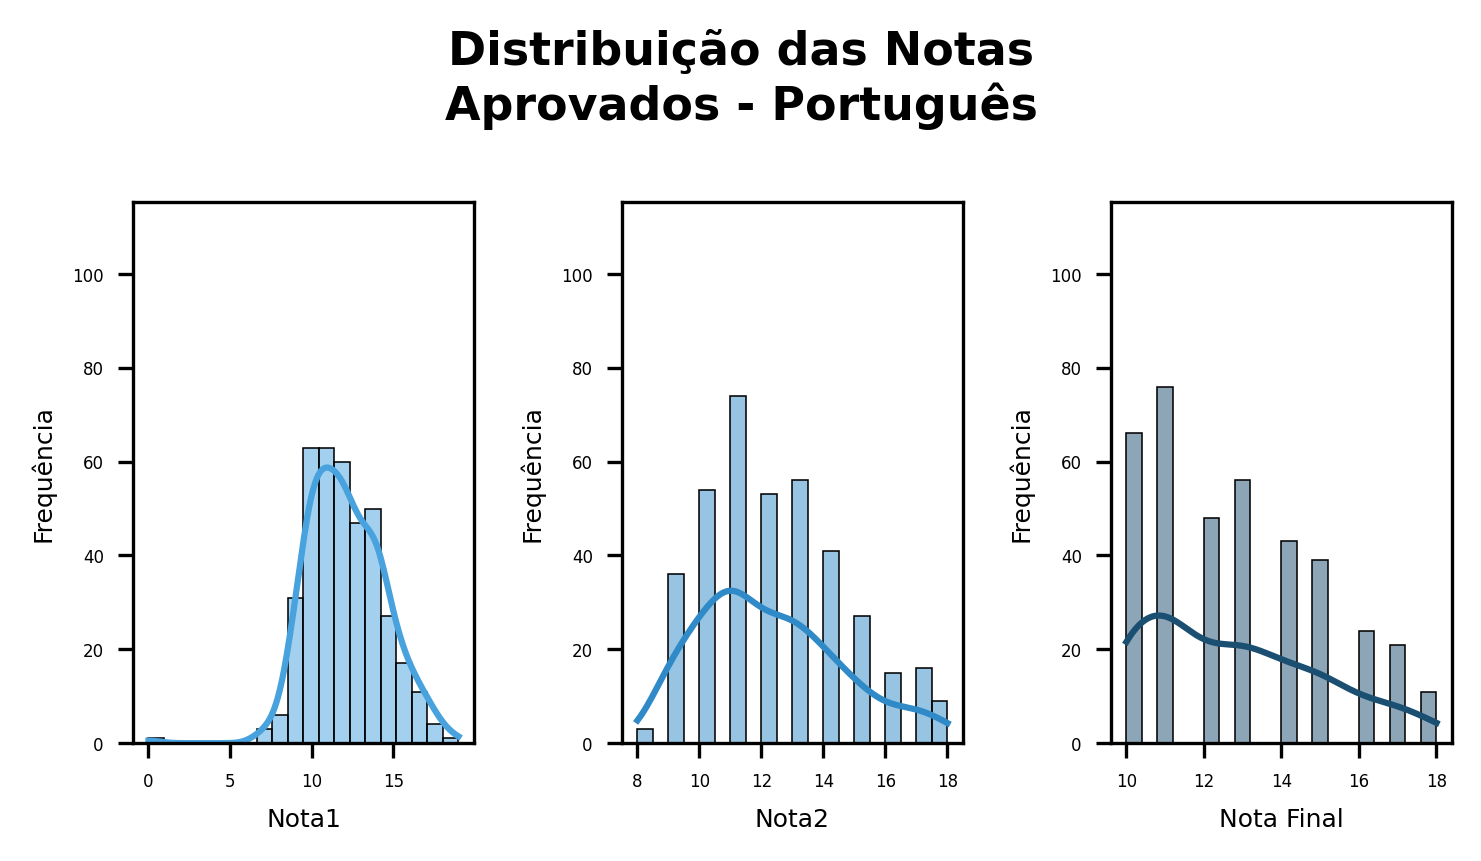

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [46]:
plot_distribuicao_quantitativas(df_aprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores,
                                materia=materia,
                                modo = 'hist',
                                titulo = 'Distribuição das Notas\nAprovados')
                                

**Reprovados**

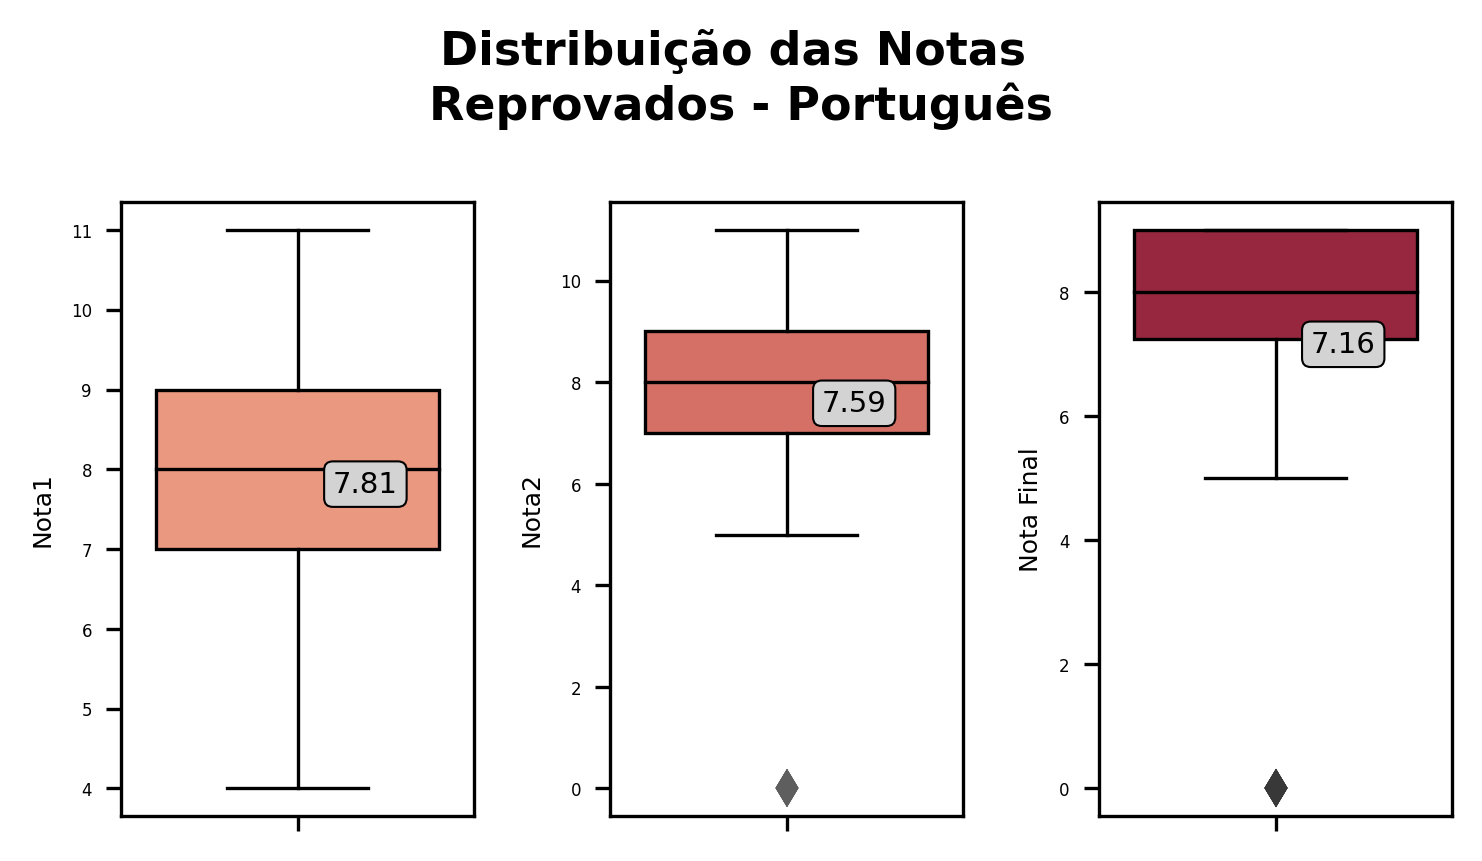

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:ylabel='Nota1'>, <AxesSubplot:ylabel='Nota2'>,
        <AxesSubplot:ylabel='Nota Final'>], dtype=object))

In [47]:
plot_distribuicao_quantitativas(df_reprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores_reprovacao,
                                materia=materia,
                                titulo = 'Distribuição das Notas \nReprovados')
                                

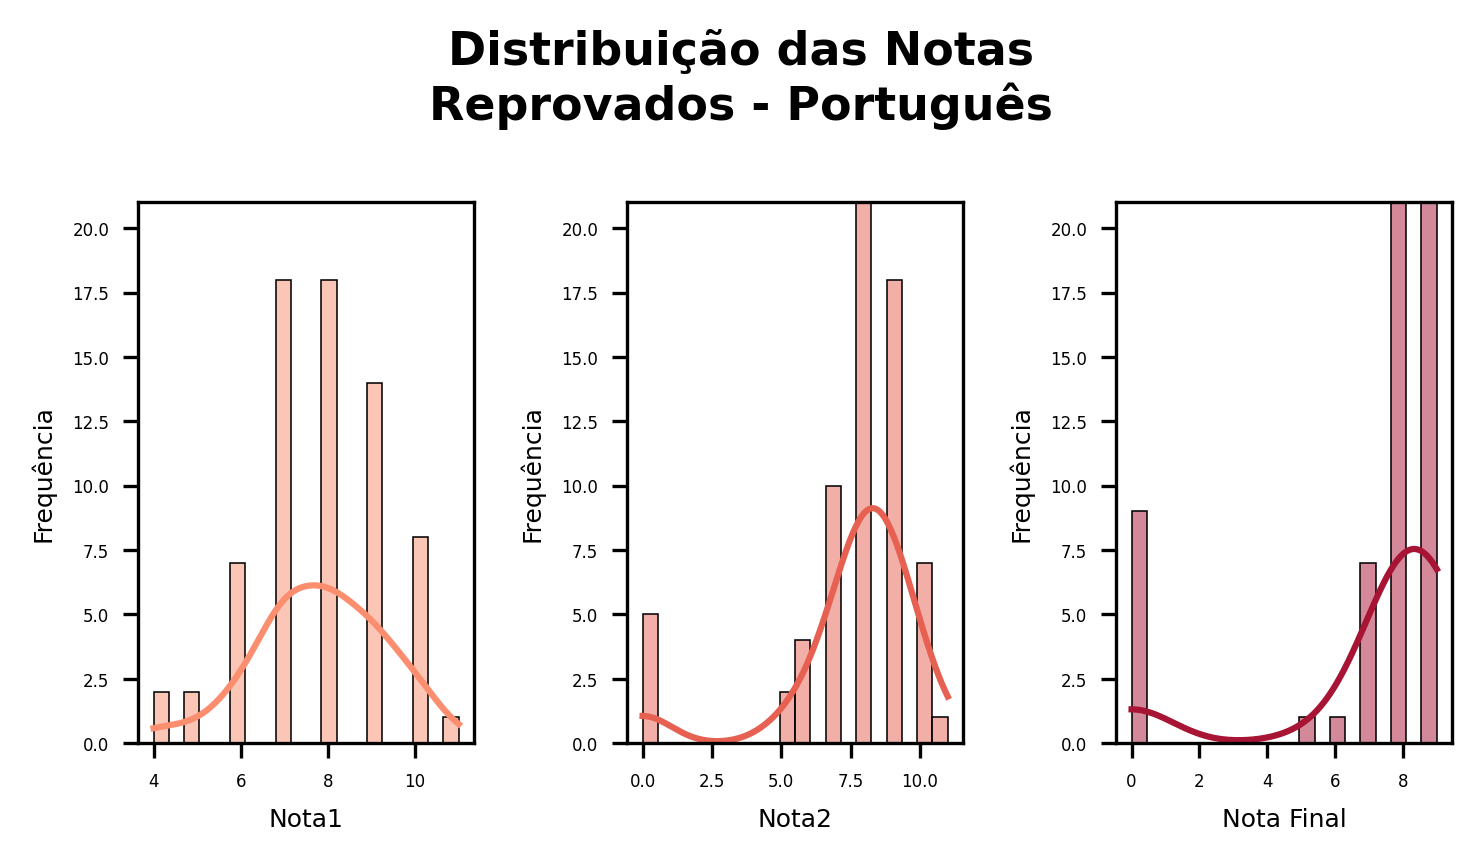

(<Figure size 1512x864 with 3 Axes>,
 array([<AxesSubplot:xlabel='Nota1', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota2', ylabel='Frequência'>,
        <AxesSubplot:xlabel='Nota Final', ylabel='Frequência'>],
       dtype=object))

In [48]:
plot_distribuicao_quantitativas(df_reprovados,
                                colunas=notas,
                                mostrar_media=True,
                                paleta=cores_reprovacao,
                                materia=materia,
                                modo = 'hist',
                                titulo = 'Distribuição das Notas\nReprovados')
                                

### 2.2.2 Correlações e Relações Entre Variáveis Quantitativas

Nesta subseção, investiga-se a força e direção das associações entre pares de variáveis quantitativas por meio da correlação de Spearman, adequada à natureza não normal dos dados.

In [49]:
corr_quant = df[variaveis_quantitativas].corr(method= 'spearman')


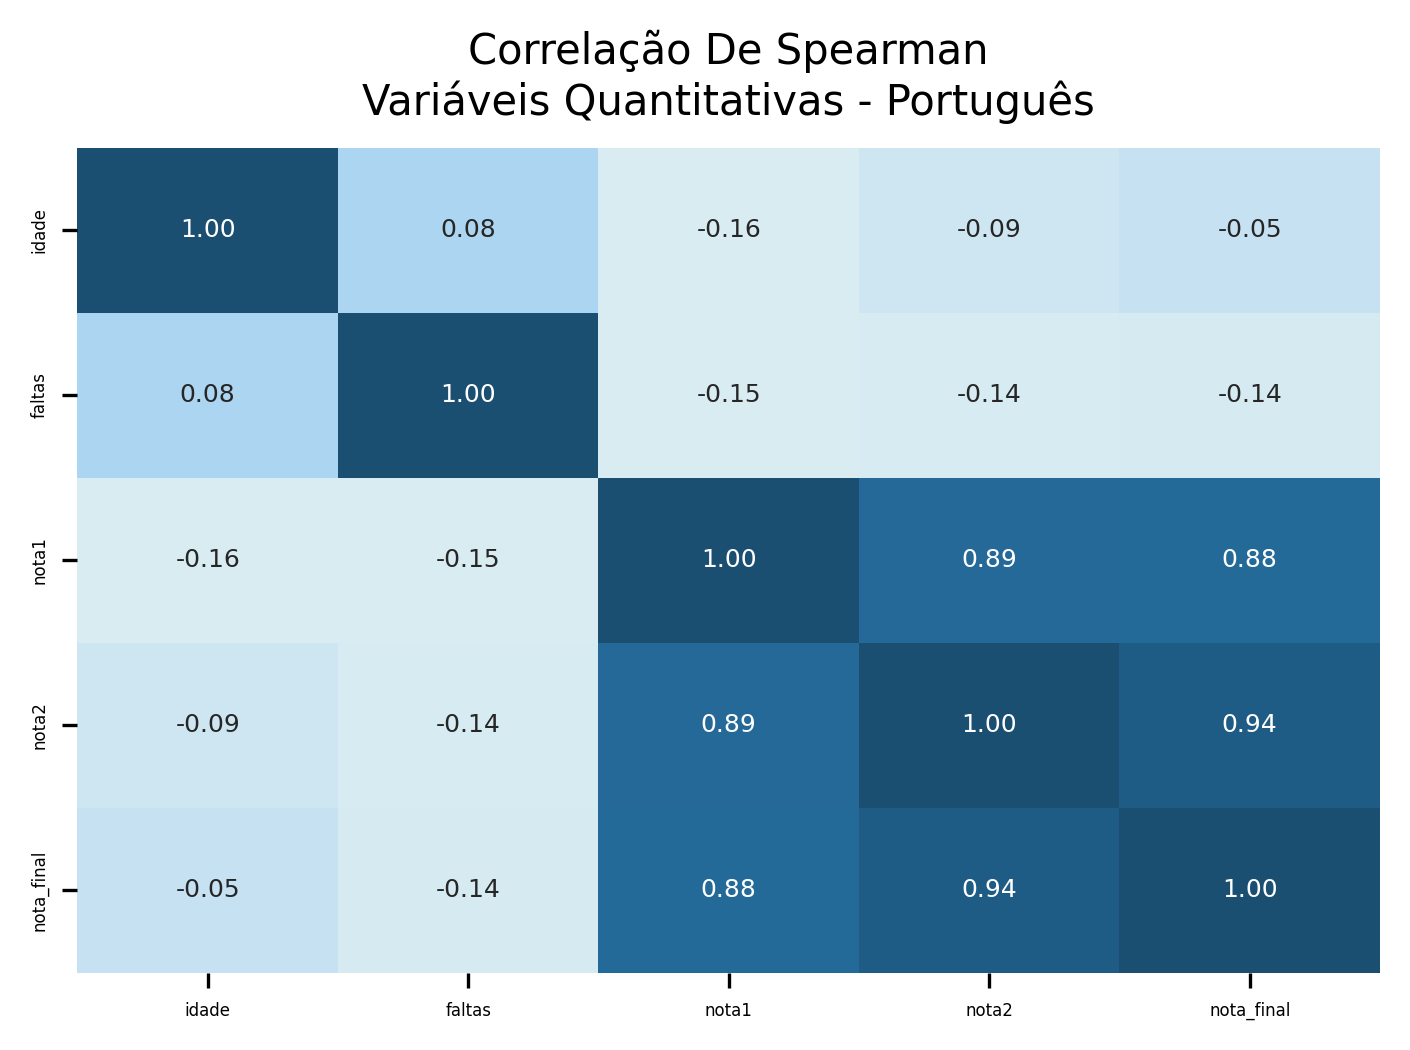

In [50]:
custom_heatmap(matriz_corr = corr_quant,
               cores = cores,
               n_arq ='heatmap_qualitativas',
               titulo = 'Correlação de Spearman \n Variáveis Quantitativas' ,
               disciplina=materia)

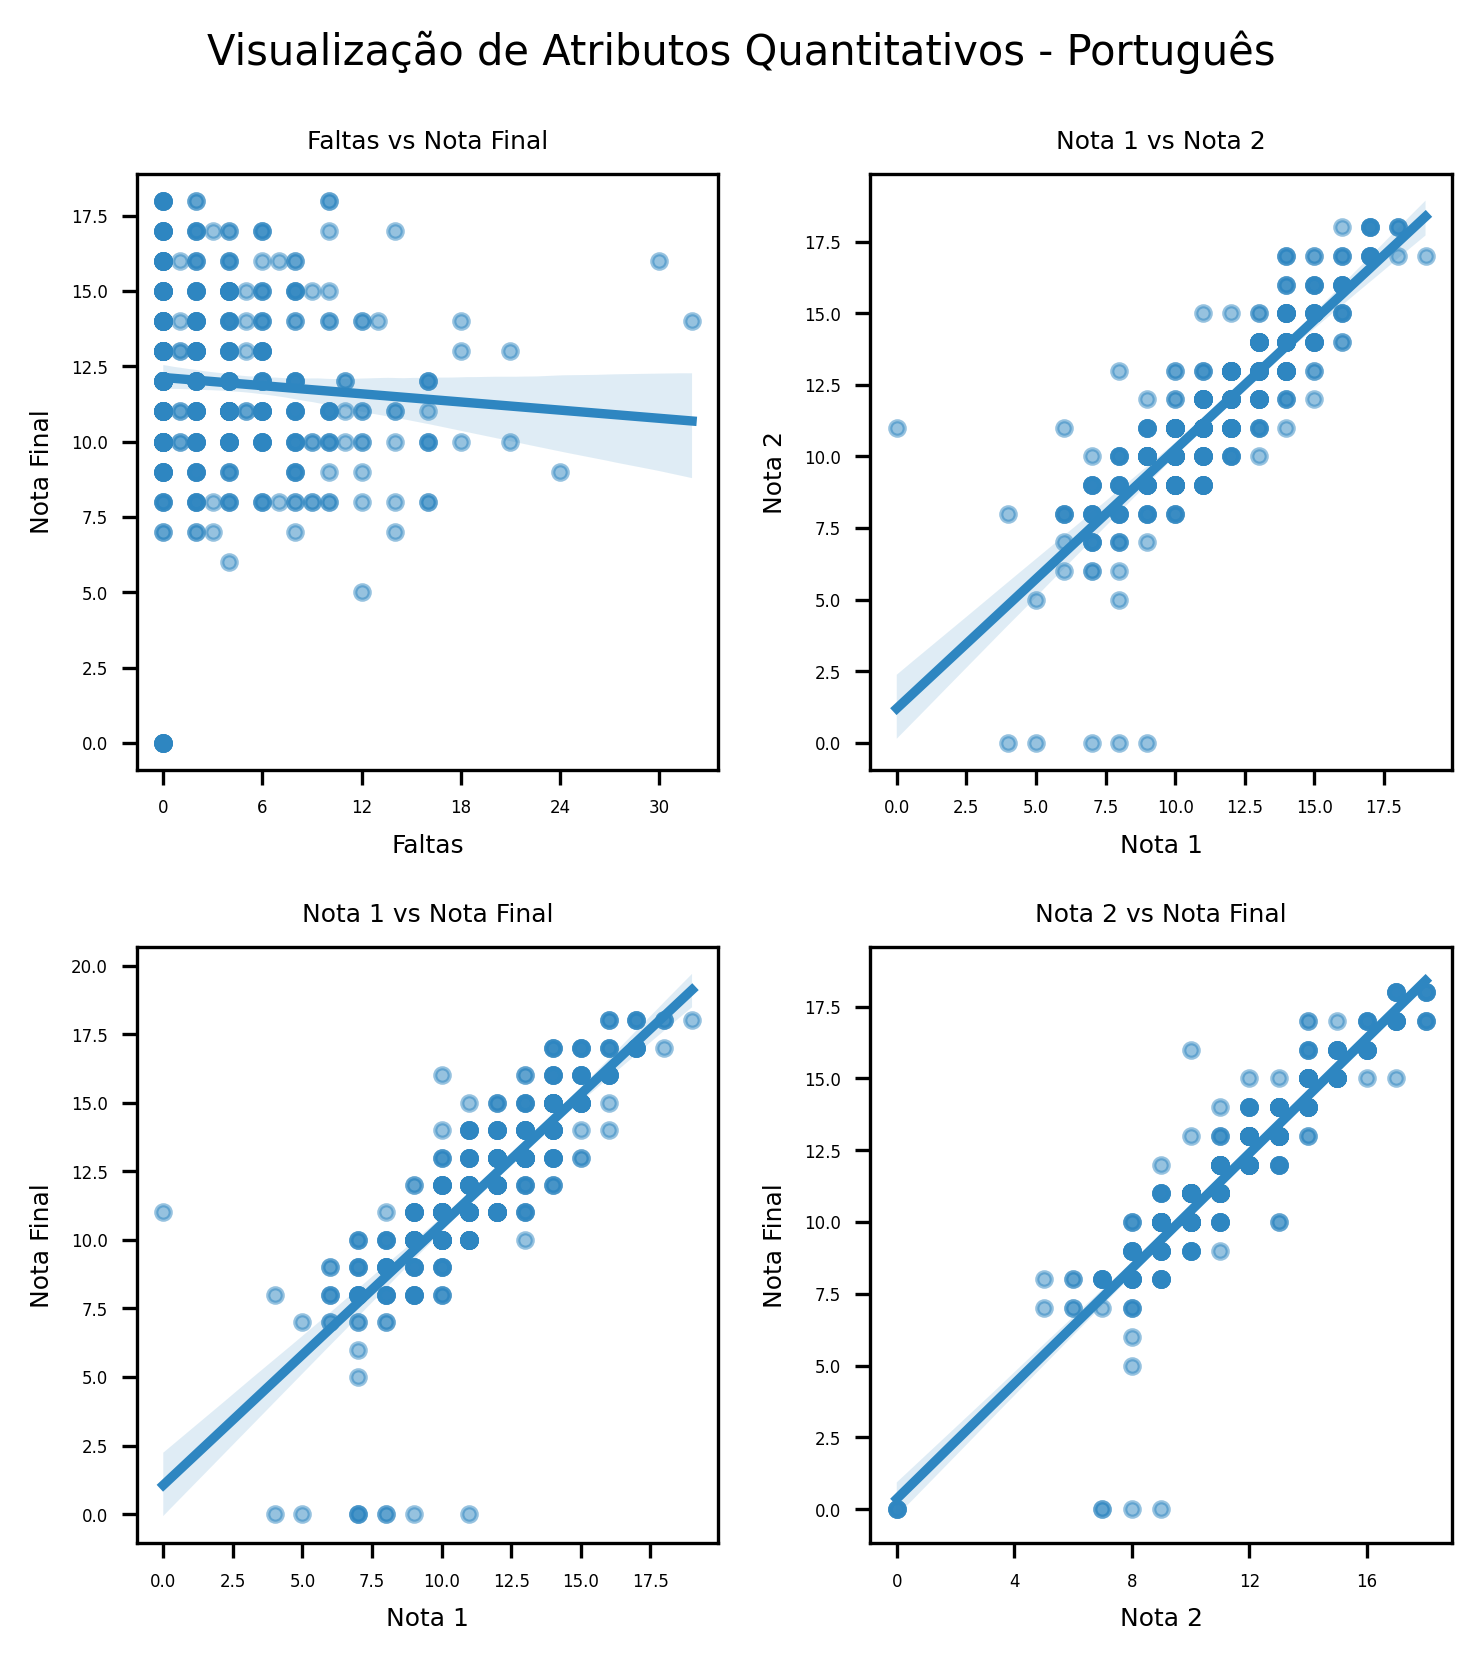

In [51]:
plot_notas_faltas(df,cor = cores, dir = 'relacao_bivariada' , mat=materia,)

### 2.2.3 Influência das Faltas no Desempenho Escolar

A análise busca responder se há evidências de que o aumento de faltas esteja associado à queda no desempenho, ou se há casos em que essa relação não se verifica — sugerindo perfis de alunos resilientes.


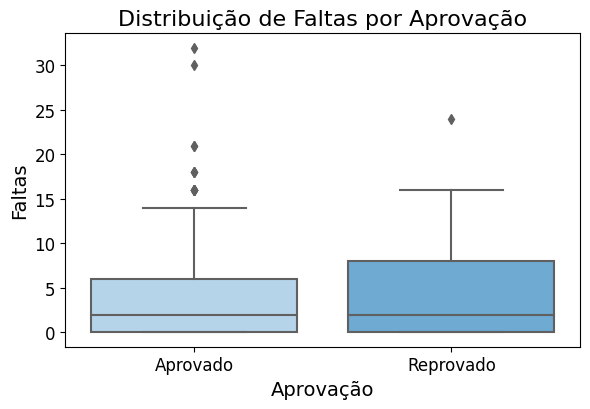

In [52]:
# Configurações do Seaborn

fig, ax = plt.subplots(figsize=(6, 4.2))
ax = sns.boxplot(x='aprovacao',y='faltas', data=df, palette=aplicar_estilo_visual(cores))
ax.set_title('Distribuição de Faltas por Aprovação', fontsize=16)
ax.set_xlabel('Aprovação', fontsize=14)
ax.set_ylabel('Faltas', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Criação de Grupos semânticos baseados em faixa de ausência*** 

| **Faixa de Faltas** | **Critério** | **Interpretação**   |
| ----- | --------------- | ------------------- |
| **0–6**         | até o Q3     | Frequência regular ou ausência leve      |
| **7–15**        | acima do Q3, mas dentro do limite de outliers | Ausência moderada   |
| **>15**         | além do limite superior de outliers           | Ausência elevada / comportamento extremo |


###### **As faixas foram definidas com base na distribuição empírica das faltas, considerando a posição dos quartis e o critério de outliers (Q3 + 1,5×IQR).*


In [53]:
# limites das faixas e os rótulos
bins = [0, 6, 15, float('inf')]
labels = ['0–6', '7–15', '>15']

# Cria nova coluna com a faixa de faltas
df['grupo_faltas'] = pd.cut(df['faltas'], bins=bins, labels=labels, right=True, include_lowest=True)


In [54]:
paleta_aprovacao_reprovacao = [aplicar_estilo_visual(cores)[4]] + [aplicar_estilo_visual(cores_reprovacao)[2]]
paleta_aprovacao_reprovacao


['#1B4F72', '#a81434']

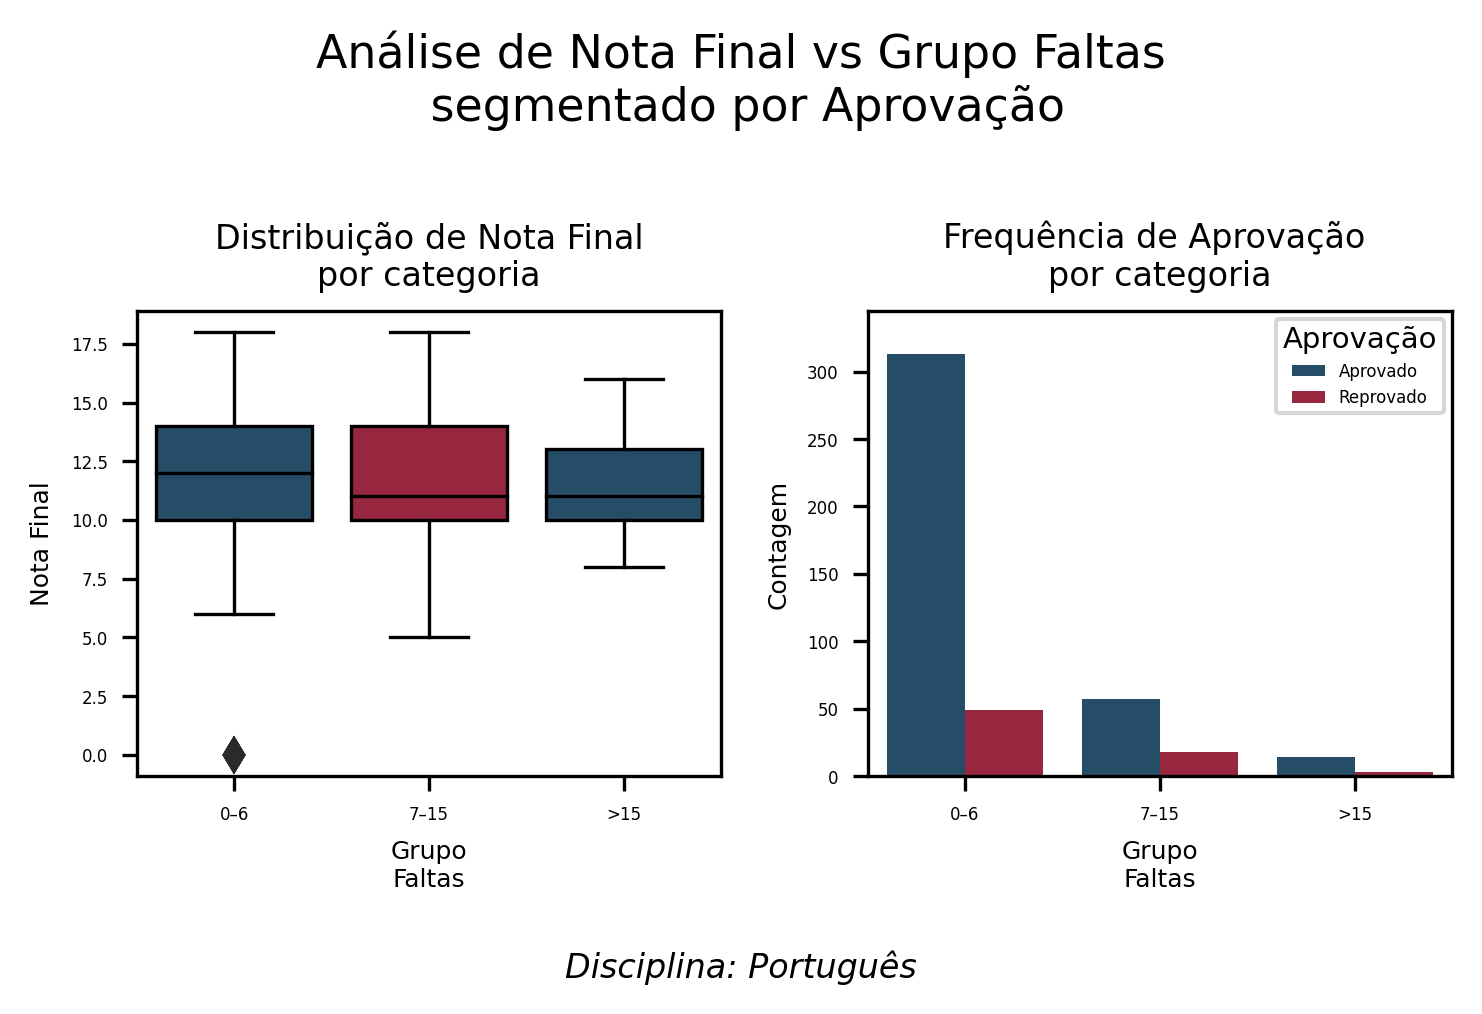

(<Figure size 1512x1008 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Distribuição de Nota Final\npor categoria'}, xlabel='Grupo\nFaltas', ylabel='Nota Final'>,
        <AxesSubplot:title={'center':'Frequência de Aprovação \npor categoria'}, xlabel='Grupo\nFaltas', ylabel='Contagem'>],
       dtype=object))

In [55]:
    
plot_boxplot_countplot(df,
                        x = 'grupo_faltas',
                        y = 'nota_final',
                        hue = 'aprovacao',
                        paleta=paleta_aprovacao_reprovacao,
                        materia= materia,
                        nome_arquivo='boxplot_faltas_aprovacao'
                       )

In [56]:
# Gerar a tabela com MultiIndex nas colunas
resumo_faltas = df[['grupo_faltas'] +notas+['idade']].groupby('grupo_faltas').agg(['mean', 'std', 'count']).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_faltas.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_faltas.columns
])
resumo_faltas


grupo_faltas  nota1                     nota2                    nota_final  \
                Média Desvio Padrão    N  Média Desvio Padrão    N      Média   
0          0–6  11.67          2.75  362  11.74          2.93  362      12.11   
1         7–15  10.63          2.64   75  10.89          2.69   75      11.35   
2          >15  10.65          1.84   17  10.76          2.14   17      11.29   

                      idade                     
  Desvio Padrão    N  Média Desvio Padrão    N  
0          3.21  362  16.61          1.18  362  
1          2.82   75  17.05          1.36   75  
2          2.23   17  17.35          1.41   17

#### **Comparativo por grupo de faltas e status de aprovação**

In [57]:
# Função personalizada para retornar a primeira moda (se houver mais de uma)
def moda_unica(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# Aplicar com a função no groupby
resumo = df[['grupo_faltas', 'aprovacao'] + notas].groupby(['grupo_faltas', 'aprovacao']).agg(
    ['mean', 'std', 'median', moda_unica]
).round(2).reset_index()


In [58]:
resumo

grupo_faltas  aprovacao  nota1                          nota2               \
                            mean   std median moda_unica   mean   std median   
0          0–6   Aprovado  12.27  2.39   12.0         11  12.43  2.30   12.0   
1          0–6  Reprovado   7.84  1.52    8.0          7   7.35  2.74    8.0   
2         7–15   Aprovado  11.58  2.18   11.0         10  11.75  2.41   11.0   
3         7–15  Reprovado   7.61  1.42    8.0          8   8.17  1.42    8.5   
4          >15   Aprovado  11.07  1.73   10.5         10  11.36  1.82   11.0   
5          >15  Reprovado   8.67  0.58    9.0          9   8.00  1.00    8.0   

             nota_final                          
  moda_unica       mean   std median moda_unica  
0         11      12.95  2.24   13.0         11  
1          8       6.76  3.31    8.0          9  
2         11      12.39  2.37   11.0         11  
3          9       8.06  1.00    8.0          8  
4         11      11.93  1.90   12.0         10  
5          7       8.33  0.58    8.0          8


### 2.2.4 Notas e Faltas por Faixas Etárias

**Criação de grupos semânticos baseados em faixas etárias**

| Faixa Etária     | Critério                     | Interpretação                             |
|------------------|------------------------------|-------------------------------------------|
| **≤16 anos**     | Menores ou igual a Q1        | Estudantes jovens / dentro da média esperada |
| **17–18 anos**   | Entre Q1 e Q3 (mediana comum) | Faixa modal / esperada no Ensino Médio    |
| **≥19 anos**     | Acima de Q3                  | Estudantes mais velhos / possíveis repetições ou trajetória atípica |

###### *As faixas foram definidas com base nos quartis empíricos da distribuição da variável `idade`, refletindo perfis educacionais diferenciados.*


In [59]:
# Limites das faixas de idade e seus rótulos
bins_idade = [0, 16, 18, float('inf')]  # ≤16, 17–18, ≥19
labels_idade = ['≤16 anos', '17–18 anos', '≥19 anos']

# Criar nova coluna com a faixa etária
df['grupo_etario'] = pd.cut(df['idade'], bins=bins_idade, labels=labels_idade, right=True, include_lowest=True)


In [60]:
# Função personalizada para retornar a primeira moda (se houver mais de uma)
def moda_unica(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# Gerar a tabela com MultiIndex nas colunas
resumo_idade = df[['grupo_etario'] +notas+['faltas']].groupby('grupo_etario').agg(['mean','median', 'std', 'count',moda_unica]).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_idade.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_idade.columns
])
resumo_idade.T

0           1         2
grupo_etario                ≤16 anos  17–18 anos  ≥19 anos
nota1        Média             11.73       11.44      9.61
             median             12.0        11.0      10.0
             Desvio Padrão      2.43        2.99      2.02
             N                   211         215        28
             moda_unica           13          10         9
nota2        Média             11.68       11.65     10.07
             median             11.0        11.0      10.0
             Desvio Padrão      2.35         3.3       2.8
             N                   211         215        28
             moda_unica           11          11        10
nota_final   Média             12.08       12.03     10.39
             median             12.0        12.0      11.0
             Desvio Padrão       2.4        3.69      2.95
             N                   211         215        28
             moda_unica           11          10        11
faltas       Média              3.27        4.28      5.14
             median              2.0         2.0       4.0
             Desvio Padrão      3.81         5.3      5.99
             N                   211         215        28
             moda_unica            0           0         0

In [61]:

# Gerar a tabela com MultiIndex nas colunas
resumo_idade = df[['grupo_etario'] +notas+['faltas']+['aprovacao']].groupby(['grupo_etario','aprovacao']).agg(['mean','median', 'std', 'count',moda_unica]).round(2).reset_index()

# Renomear apenas o nível de métricas
resumo_idade.columns = pd.MultiIndex.from_tuples([
    (col[0], 
     col[1].replace('mean', 'Média')
           .replace('std', 'Desvio Padrão')
           .replace('count', 'N')) if col[1] else col
    for col in resumo_idade.columns
])
resumo_idade.T

0          1           2           3  \
grupo_etario                ≤16 anos   ≤16 anos  17–18 anos  17–18 anos   
aprovacao                   Aprovado  Reprovado    Aprovado   Reprovado   
nota1        Média             12.29       8.11       12.16        7.74   
             median             12.0        8.5        12.0         8.0   
             Desvio Padrão      2.05       1.45        2.66        1.54   
             N                   183         28         180          35   
             moda_unica           13          9          11           8   
nota2        Média             12.21       8.21       12.52        7.14   
             median             12.0        8.5        12.0         8.0   
             Desvio Padrão       2.0       1.26         2.6        2.85   
             N                   183         28         180          35   
             moda_unica           11          9          11           8   
nota_final   Média             12.65       8.36       13.16        6.26   
             median             12.0        8.0        13.0         8.0   
             Desvio Padrão      2.04       0.62        2.48        3.53   
             N                   183         28         180          35   
             moda_unica           11          8          10           8   
faltas       Média              3.11       4.29        4.25        4.43   
             median              2.0        2.0         2.0         2.0   
             Desvio Padrão      3.48       5.51        5.38         4.9   
             N                   183         28         180          35   
             moda_unica            0          0           0           0   

                                   4          5  
grupo_etario                ≥19 anos   ≥19 anos  
aprovacao                   Aprovado  Reprovado  
nota1        Média             10.48        7.0  
             median             10.0        7.0  
             Desvio Padrão      1.47       0.82  
             N                    21          7  
             moda_unica            9          7  
nota2        Média              11.0       7.29  
             median             10.0        8.0  
             Desvio Padrão      1.87        3.4  
             N                    21          7  
             moda_unica           10          8  
nota_final   Média             11.57       6.86  
             median             11.0        9.0  
             Desvio Padrão      1.57       3.39  
             N                    21          7  
             moda_unica           11          9  
faltas       Média              5.24       4.86  
             median              4.0        4.0  
             Desvio Padrão      6.36       5.15  
             N                    21          7  
             moda_unica            0          0

### 2.2.5 Síntese Analítica dos Destaques

#### 1. Notas por Grupo de Aprovação

- **Distribuição dos grupos**:
  - Aprovados representam 84,6% da amostra (n = 384);
  - Reprovados correspondem a 15,4% (n = 70).

- **Notas por grupo**:
  - A média de `nota_final` entre os aprovados foi 12,83, contra 7,16 entre os reprovados — uma diferença expressiva de mais de 5 pontos;
  - Os reprovados apresentaram maior variabilidade nas notas, com coeficiente de variação (CV) de até 0,40 em `nota_final`.

- **Comportamento dos outliers**:
  - Outliers mais relevantes em `nota_final` e `nota2` ocorrem principalmente entre os reprovados, com valores inferiores ao esperado;
  - Entre os aprovados, outliers em `faltas` não impactaram significativamente as médias de desempenho.

---

#### 2. Correlações Entre Variáveis Quantitativas

- **Correlações fortes entre notas**:
  - `nota2` e `nota_final`: ρ = 0.94;
  - `nota1` e `nota_final`: ρ = 0.88;
  - `nota1` e `nota2`: ρ = 0.89;
  - Indicam consistência no desempenho ao longo das avaliações.

- **Correlações negativas com faltas**:
  - `faltas` apresentou correlação fraca e negativa com `nota_final` (ρ = –0.14).

- **Idade e desempenho**:
  - Correlações fracas e negativas (máx. ρ ≈ –0.15);
  - A idade, isoladamente, não exerce influência marcante sobre o desempenho.

---

#### 3. Faltas e Desempenho Acadêmico

- Aprovados apresentaram maior variabilidade nas faltas (CV = 1,24), com casos extremos de até 32 faltas;
- Mesmo entre os aprovados, 14 alunos com faltas >15 sugerem **possíveis perfis resilientes**;
- Apenas 3 dos 17 alunos com faltas elevadas foram reprovados, indicando que **a ausência, isoladamente, não foi determinante para reprovação**;
- Esses alunos com >15 faltas apresentaram média de `nota_final` = 11,29 contra 11,98 nos demais.

---

#### 4. Desempenho por Grupo de Faltas

| Faixa de Faltas | Critério                           | Interpretação                            |
|------------------|------------------------------------|-------------------------------------------|
| **0–6**          | Até Q3                             | Frequência regular / ausência leve        |
| **7–15**         | Entre Q3 e o limite de outliers    | Ausência moderada                         |
| **>15**          | Acima do limite de outliers        | Ausência elevada / comportamento extremo  |

- A média de `nota_final` decresceu com o aumento das faltas: **12,11 → 11,35 → 11,29**;
- A idade média aumentou nas faixas de maior ausência (até 17,35 anos no grupo >15);
- Desvios padrão menores no grupo >15 sugerem menor variabilidade — **perfil mais homogêneo**.

---

#### 5. Faixas de Faltas × Aprovação

- Diferenças entre aprovados e reprovados foram **mais acentuadas nas faixas 7–15 e >15**;
- Alunos aprovados com >15 faltas tiveram `nota_final` média de 11,93 vs. 8,33 nos reprovados da mesma faixa;
- Reprovados com 7–15 faltas mostraram baixa dispersão de notas — indicando homogeneidade no baixo desempenho.

---

#### 6. Desempenho por Faixa Etária

| Faixa Etária     | Critério          | Interpretação                        |
|------------------|-------------------|--------------------------------------|
| **≤16 anos**     | Até 16 anos       | Estudantes mais jovens               |
| **17–18 anos**   | 17 a 18 anos      | Faixa modal do ensino médio          |
| **≥19 anos**     | 19 anos ou mais   | Perfil de repetência / trajetória atípica |

- Alunos ≥19 anos tiveram médias mais baixas: ex. `nota1` = 9,61; `nota_final` = 10,39;
- Média de faltas também aumentou com a idade: 3,27 → 4,28 → 5,14;
- Grupo ≥19 anos foi pequeno (n = 28), mas com padrão consistente de desempenho inferior.

---

#### 7. Faixa Etária × Aprovação

- Aprovados obtiveram médias significativamente superiores em todas as faixas;
- Reprovados tiveram `nota_final` média abaixo de 9 em todas as faixas (ex: 6,26 nos 17–18 anos);
- Reprovados ≤16 anos mostraram **baixa dispersão** (DP = 0,62) — possível reprovação por critério fixo;
- Aprovados ≥19 anos apresentaram desempenho inferior aos demais, mesmo aprovados.

Esses resultados apontam para **múltiplos perfis de risco**, combinando idade, ausência e notas parciais como possíveis indicadores de reprovação.



## 2.3 Conclusão da Análise Quantitativa

A análise dos atributos quantitativos revelou padrões consistentes entre desempenho, frequência e faixa etária. Notas parciais mostraram-se altamente correlacionadas com a nota final, enquanto variáveis como `faltas` e `idade` demonstraram relações mais sutis, porém relevantes quando cruzadas com o status de aprovação.

A segmentação por faixas de ausência e idade permitiu identificar perfis de risco e possíveis trajetórias atípicas. Alunos com elevado número de faltas ou com idade mais avançada mantiveram desempenho inferior em média, mas não necessariamente foram reprovados — o que reforça a importância de considerar essas variáveis de forma interativa.

Esses achados sustentam hipóteses importantes para a próxima etapa do projeto: a seleção de atributos e construção de modelos preditivos. A análise bivariada serviu como base sólida para priorizar variáveis explicativas e entender nuances relevantes no perfil dos estudantes.


# 3. Análise de Atributos Categóricos, Perfis Estudantis e Segmentação de Desempenho

## 3.1 Visão Geral das Variáveis Categóricas Nominais e Ordinais


#### **Medidas Descritivas de Frequência**

In [62]:
add_features_describe_pd(df,colunas=variaveis_categoricas,estudo_frequencia=True )

Tamanho da amostra (categórico): 454


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,299,65.859031,0.440529
genero,2,Mulher,267,58.810573,0.440529
endereco,2,Urbano,315,69.38326,0.440529
status_parental,2,Juntos,395,87.004405,0.440529
profissao_mae,5,Outra profissão,179,39.427313,1.101322
profissao_pai,5,Outra profissão,251,55.286344,1.101322
motivo_escolha_escola,4,Curso específico,193,42.511013,0.881057
responsavel_legal,3,Mãe,322,70.92511,0.660793
apoio_escolar,2,Não,405,89.207048,0.440529


#### **Medidas Descritivas das Variáveis Ordinais**

In [63]:
add_features_describe_pd(df,colunas=variaveis_categoricas_ordinais)

Tamanho da amostra (numérico): 454.0


,Média,Desvio Padrão,Mínimo,1º Quartil (25%),Mediana (50%),3º Quartil (75%),Máximo,Moda,Shapiro-Wilk (p-valor),Coeficiente de Variação (CV)
Variável,,,,,,,,,,
escolaridade_mae,2.550661,1.122059,0.0,2.00,2.0,4.0,4.0,2,3.61e-19,0.440
escolaridade_pai,2.317181,1.092141,0.0,1.00,2.0,3.0,4.0,2,1.80e-18,0.471
relacao_familiar,3.878855,0.983683,1.0,3.00,4.0,5.0,5.0,4,6.65e-22,0.254
tempo_livre,3.162996,1.073397,1.0,2.25,3.0,4.0,5.0,3,1.28e-15,0.339
frequencia_saidas,3.118943,1.150465,1.0,2.00,3.0,4.0,5.0,3,1.32e-15,0.369
saude,3.526432,1.468719,1.0,2.00,4.0,5.0,5.0,5,1.71e-21,0.416
tempo_estudo,1.918502,0.805588,1.0,1.00,2.0,2.0,4.0,2,6.77e-22,0.420
tempo_transporte,1.579295,0.770088,1.0,1.00,1.0,2.0,4.0,1,1.12e-26,0.488
alcool_dias_uteis,1.484581,0.934254,1.0,1.00,1.0,2.0,5.0,1,1.20e-31,0.629



### **3.1.1 Comentários Iniciais**

#### **Visão Geral**

Antes de aprofundar as análises cruzadas entre atributos categóricos e desempenho acadêmico, foi realizada uma descrição geral da distribuição das variáveis categóricas presentes no conjunto de dados. O objetivo desta etapa é identificar padrões dominantes, variabilidade interna e potenciais características que contribuem para a formação de perfis estudantis distintos.

De forma geral, observou-se que a maioria das variáveis apresenta **baixa diversidade de categorias**: mais da metade possui apenas duas categorias (ex: `genero`, `endereco`, `apoio_escolar`, `acesso_internet`), o que favorece a visualização e interpretação direta.

Em diversas variáveis, **uma categoria dominante concentra mais de 60% dos estudantes**, como:
- `apoio_escolar` (89% sem apoio),
- `acesso_internet` (77% com acesso),
- `interesse_ensino_superior` (90% manifestaram interesse),
- `frequentou_creche` (79% responderam "Sim"),
- `escola`, com 66% dos alunos provenientes da unidade Gabriel Pereira.

Apesar disso, algumas variáveis apresentam maior diversidade e equilíbrio, como:
- `profissao_mae` e `profissao_pai`, ambas com cinco categorias, sem uma maioria absoluta;
- `tempo_livre`, `relacao_familiar`, `saude` e `alcool_fim_semana`, que indicam **variabilidade significativa nos hábitos e condições familiares** dos alunos.

A variável `reprovacoes` se destaca por ter quatro categorias possíveis, embora a grande maioria dos estudantes (83,7%) nunca tenha sido reprovada.

Essas observações iniciais reforçam a importância de se considerar o **peso relativo das categorias dominantes** em análises subsequentes, e sinalizam variáveis que podem ser discriminantes relevantes na modelagem preditiva.


#### **Medidas Descritivas das Variáveis Ordinais**

Além das contagens e distribuições, foram avaliadas as medidas de tendência central e dispersão das variáveis ordinais, cuja estrutura permite uma análise mais quantitativa. Os principais destaques incluem:

- A variável `tempo_estudo` concentrou-se na categoria 2 (média = 1,92), com baixa variabilidade (CV = 0,42);
- `tempo_transporte` e `alcool_dias_uteis` apresentaram médias baixas e forte concentração nas categorias mínimas (moda = 1);
- `reprovacoes` teve média inferior a 0,3, com mais de 80% dos alunos sem reprovações, mas alta dispersão relativa (CV = 2,586);
- `relacao_familiar`, `frequencia_saidas` e `saude` exibiram médias próximas de 4, sugerindo percepções geralmente positivas nas dimensões familiares e pessoais.

Essas estatísticas reforçam a importância de tratar variáveis ordinais com critérios apropriados, especialmente ao definir cortes ou interpretar agrupamentos em fases posteriores da análise.


## 3.2 Distribuição dos Atributos Categóricos e Suas Relações com a Aprovação



In [64]:
registros = []
df_temp = df.copy()
df_temp['aprov_bin'] = df_temp['aprovacao'].map({'Aprovado': 1, 'Reprovado': 0})


n_total = len(df)

for var in variaveis_categoricas:
    dist = df[var].value_counts(dropna=False)
    taxa_aprov = df_temp.groupby(var)['aprov_bin'].mean()

    for cat, count in dist.items():
        registros.append({
            'Variável': var,
            'Categoria': cat,
            'Frequência Absoluta': count,
            'Frequência Relativa (%)': round(100 * count / n_total, 2),
            'Taxa de Aprovação (%)': round(100 * taxa_aprov.get(cat, 0), 2)
        })

resultado = pd.DataFrame(registros)
resultado = resultado.sort_values(by=['Variável', 'Frequência Absoluta'], ascending=[True, False]).reset_index(drop=True)
resultado.head()

,Variável,Categoria,Frequência Absoluta,Frequência Relativa (%),Taxa de Aprovação (%)
0,acesso_internet,Sim,350,77.09,86.57
1,acesso_internet,Não,104,22.91,77.88
2,alcool_dias_uteis,1,324,71.37,87.04
3,alcool_dias_uteis,2,77,16.96,79.22
4,alcool_dias_uteis,3,30,6.61,80.00


> ### 3.2.1 Perfil Demográfico e Estrutural
>
> - **Gênero**: A maioria dos alunos é do gênero feminino (58,8%), grupo que apresenta taxa de aprovação levemente superior à dos homens (85,8% contra 82,9%), sem grande disparidade entre os sexos.
>
> - **Endereço**: A maioria reside em área urbana (69,4%), com taxa de aprovação significativamente mais alta (87,6%) do que os estudantes da zona rural (77,7%), indicando possível vantagem em termos de acesso a recursos escolares.
>
> - **Escola**: O Colégio Gabriel Pereira concentra 65,9% da amostra e apresenta taxa de aprovação de 92,6%, muito superior à da escola Mousinho da Silveira (69,0%). A variável reflete forte associação entre instituição e desempenho.
>
> - **Status parental**: A maioria dos estudantes vive com os pais juntos (87%), com taxa de aprovação de 85,1%, ligeiramente superior à dos alunos com pais separados (81,4%).
>
> - **Tamanho da família**: Famílias com mais de três membros representam 70,3% da amostra, com taxa de aprovação próxima à das famílias menores (84,3% vs. 85,2%), sugerindo que o tamanho familiar, isoladamente, não exerce grande influência.
>
> - **Responsável legal**: A mãe é o responsável legal mais frequente (70,9%), seguida pelo pai (22,5%). Alunos sob responsabilidade paterna tiveram taxa mais elevada de aprovação (90,2%), o que pode indicar padrões distintos de engajamento.

---

> ### 3.2.2 Condições Socioeconômicas e Educacionais
>
> - **Acesso à internet**: A maioria dos alunos tem acesso à internet (77,1%), apresentando taxa de aprovação de 86,6%, superior à dos que não possuem acesso (77,9%), o que reforça a importância da conectividade como suporte educacional.
>
> - **Escolaridade dos pais**:
>   - Mães e pais com escolaridade nível 4 (ensino superior) estão associados às maiores taxas de aprovação (>89%);
>   - Pais com escolaridade nível 3 destacam-se com 93,6% de aprovação;
>   - Os dados evidenciam forte associação entre nível educacional dos pais e sucesso escolar dos filhos.
>
> - **Profissão dos pais**:
>   - Alunos cujos pais são professores ou atuam na saúde apresentam as maiores taxas de aprovação (acima de 93%);
>   - Filhos de donas de casa ou profissionais de serviços têm desempenho inferior, sugerindo menor suporte acadêmico direto.
>
> - **Motivo da escolha da escola**:
>   - Escolhas baseadas em reputação ou proximidade resultaram em maior taxa de aprovação (acima de 90%);
>   - Motivações como “curso específico” ou “outros motivos” associaram-se a taxas inferiores, indicando possível menor engajamento no processo de escolha.
>
> - **Interesse no ensino superior**: A ampla maioria dos alunos (90,1%) manifestou interesse em cursar o ensino superior. Esse grupo obteve 87,8% de aprovação, contrastando com os 55,6% entre os que não têm esse interesse — uma diferença expressiva.

---

> ### 3.2.3 Acompanhamento e Apoio Familiar e Escolar
>
> - **Apoio escolar**: Apenas 10,8% relataram receber apoio extraescolar, com desempenho levemente superior (85,7%) aos que não recebem (84,4%). Pode-se inferir que o apoio contribui positivamente, mesmo que discretamente.
>
> - **Apoio familiar**: Estudantes que relataram apoio da família (61,7%) alcançaram 85,4% de aprovação, levemente acima dos que não recebem esse apoio (83,3%), o que aponta para o valor do suporte no ambiente doméstico.
>
> - **Atividades extracurriculares**: Quase metade dos alunos participa dessas atividades (47,8%), com taxa de aprovação de 86,2%, superior à dos que não participam (83,1%). A variável sugere benefício adicional da integração com atividades externas.
>
> - **Aulas particulares**: Apesar de pouco frequente (4,8% da amostra), esse grupo registra taxa de aprovação elevada (86,4%), sugerindo que reforço escolar personalizado pode ser benéfico.
>
> - **Frequência à creche**: A maioria dos alunos (79,3%) frequentou creche, com taxa de aprovação de 84,4%, similar à dos que não frequentaram (85,1%). A variável não parece exercer influência direta no desempenho final.

---

> ### 3.2.4 Hábitos e Estilo de Vida
>
> - **Consumo de álcool**:
>   - Consumo moderado (1 vez por semana) está associado às maiores taxas de aprovação (acima de 87%);
>   - O desempenho cai com o aumento da frequência, especialmente entre os que consomem cinco vezes por semana (71,4%);
>   - A relação entre consumo e desempenho reforça o impacto negativo de hábitos excessivos.
>
> - **Frequência de saídas**:
>   - Estudantes que saem menos de três vezes por semana apresentam taxa de aprovação de até 90,3%;
>   - A partir de três saídas semanais, o desempenho reduz-se progressivamente (73,1% a 82,5%).
>
> - **Relacionamento romântico**:
>   - Estudantes sem envolvimento afetivo (62,3% da amostra) apresentam melhor desempenho (86,6%) em comparação aos que mantêm um relacionamento (81,3%);
>   - A variável pode estar relacionada à gestão de tempo, foco acadêmico e estabilidade emocional.
>
> - **Relacionamento familiar**:
>   - Alunos que avaliam sua relação familiar como excelente (nota 4 ou 5) registram taxas de aprovação acima de 90%;
>   - Relações familiares problemáticas (nota 1) associam-se à menor taxa observada (55,6%).
>
> - **Saúde autopercebida**:
>   - Alunos que classificam sua saúde como regular (níveis 2 e 3) apresentam desempenho ligeiramente superior;
>   - Os extremos (muito saudáveis ou muito doentes) não se destacam positivamente, sugerindo efeito mais indireto.

---

> ### 3.2.5 Condições Acadêmicas e Comportamento Estudantil
>
> - **Reprovações anteriores**:
>   - Alunos sem reprovações têm taxa de aprovação de 91%;
>   - Os que possuem três reprovações registram apenas 33,3%, confirmando o impacto acumulado negativo no desempenho.
>
> - **Tempo de estudo diário**:
>   - Estudantes que dedicam 3 a 4 horas por dia atingem taxas superiores a 94%;
>   - Aqueles que estudam apenas 1 hora apresentam taxa inferior (75,5%);
>   - A variável evidencia uma relação clara entre tempo de estudo e rendimento.
>
> - **Tempo livre diário**:
>   - Alunos com 2 a 3 horas de tempo livre tiveram as melhores taxas de aprovação (>85%);
>   - Tempo livre excessivo (5 horas) associou-se à menor taxa observada (69,6%), sugerindo desequilíbrio entre lazer e estudo.
>
> - **Tempo de transporte até a escola**:
>   - Alunos com até 1h de deslocamento registram 86,4% de aprovação;
>   - Aumentos no tempo de transporte reduzem significativamente o desempenho, chegando a 72,5% entre os que se deslocam por mais de 2 horas.


## 3.3 Análise Bivariada entre Atributos Categóricos, Ordinais e Métricas de Desempenho
Objetivo: 
- Investigar associações entre variáveis não diretamente relacionadas à aprovação e verificar correlações relevantes para seleção de atributos.


### 3.3.1 Correlação entre Variáveis Ordinais Descritivas

In [65]:
corr_ord = df[variaveis_categoricas_ordinais].corr(method= 'spearman')


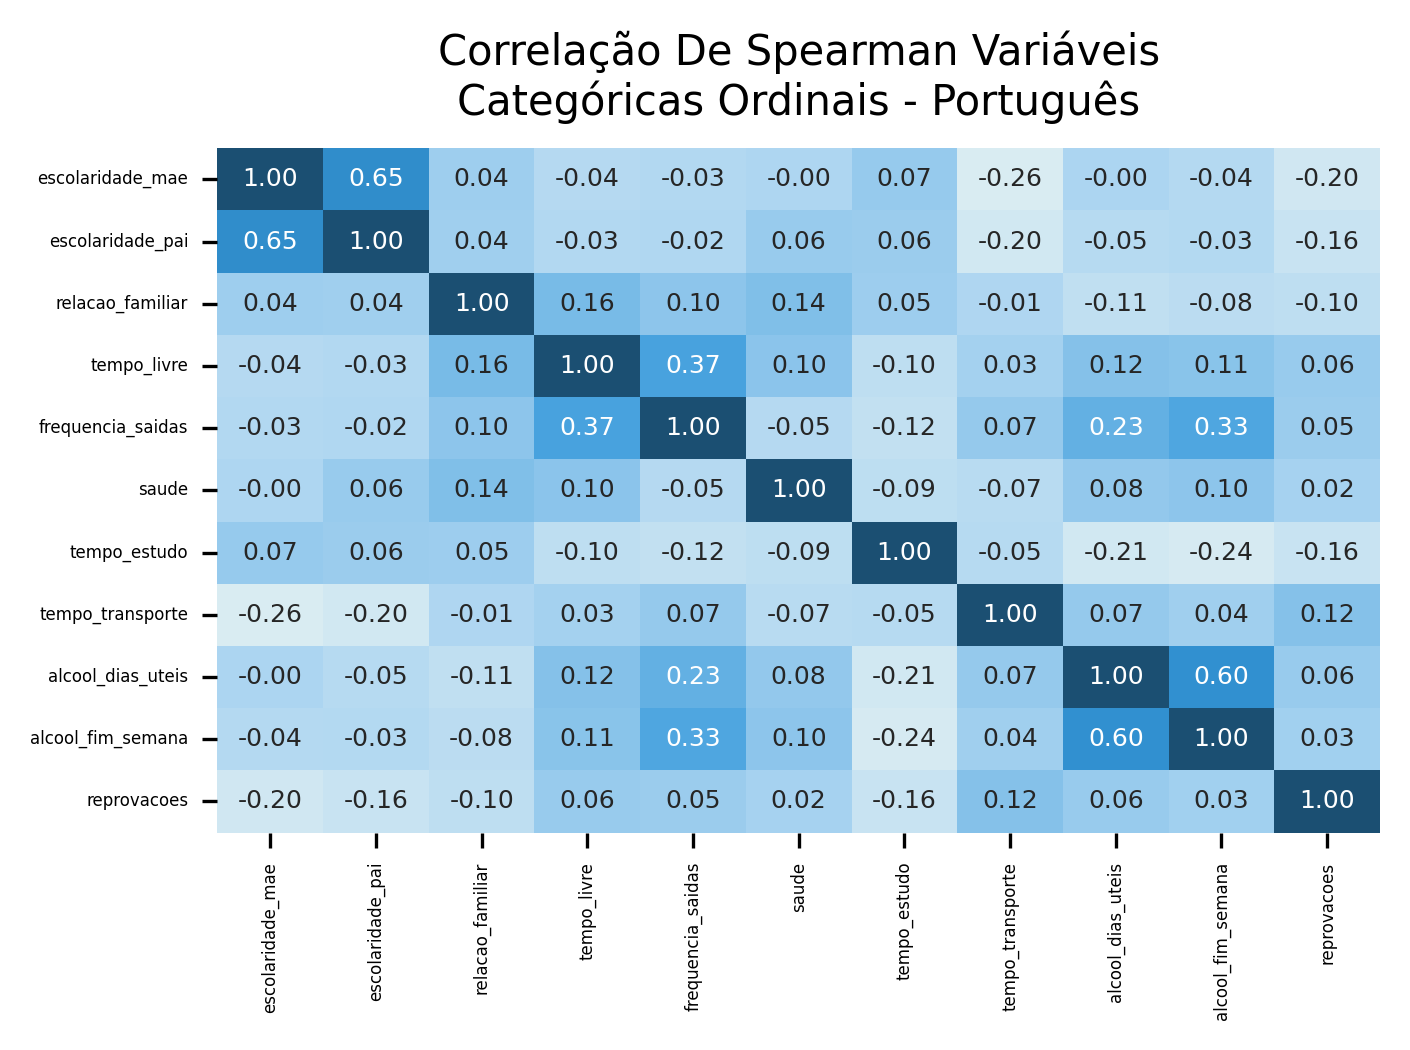

In [66]:
custom_heatmap(matriz_corr = corr_ord,
               cores = cores,
               n_arq ='heatmap_ordinais',
               titulo = 'Correlação de Spearman \n Variáveis Categóricas Ordinais' ,
               disciplina=materia)

### 3.3.2 Correlação entre Variáveis Ordinais e Métricas de Desempenho

In [67]:
corr_ord = df[variaveis_categoricas_ordinais+notas+['faltas']].corr(method= 'spearman')

In [68]:
corr_long = corr_ord.where(np.tril(np.ones(corr_ord.shape), k=-1).astype(bool)).stack().reset_index()
corr_long.columns = ['Notas e Faltas','Categoricas Ordinais', 'Correlação']

In [69]:
corr_ord_n = corr_long[corr_long['Notas e Faltas'].isin(['nota1', 'nota2', 'nota_final','faltas'])]

heatmap_df = corr_ord_n.pivot(index='Categoricas Ordinais', columns='Notas e Faltas', values='Correlação')
heatmap_df.dropna(inplace=True)

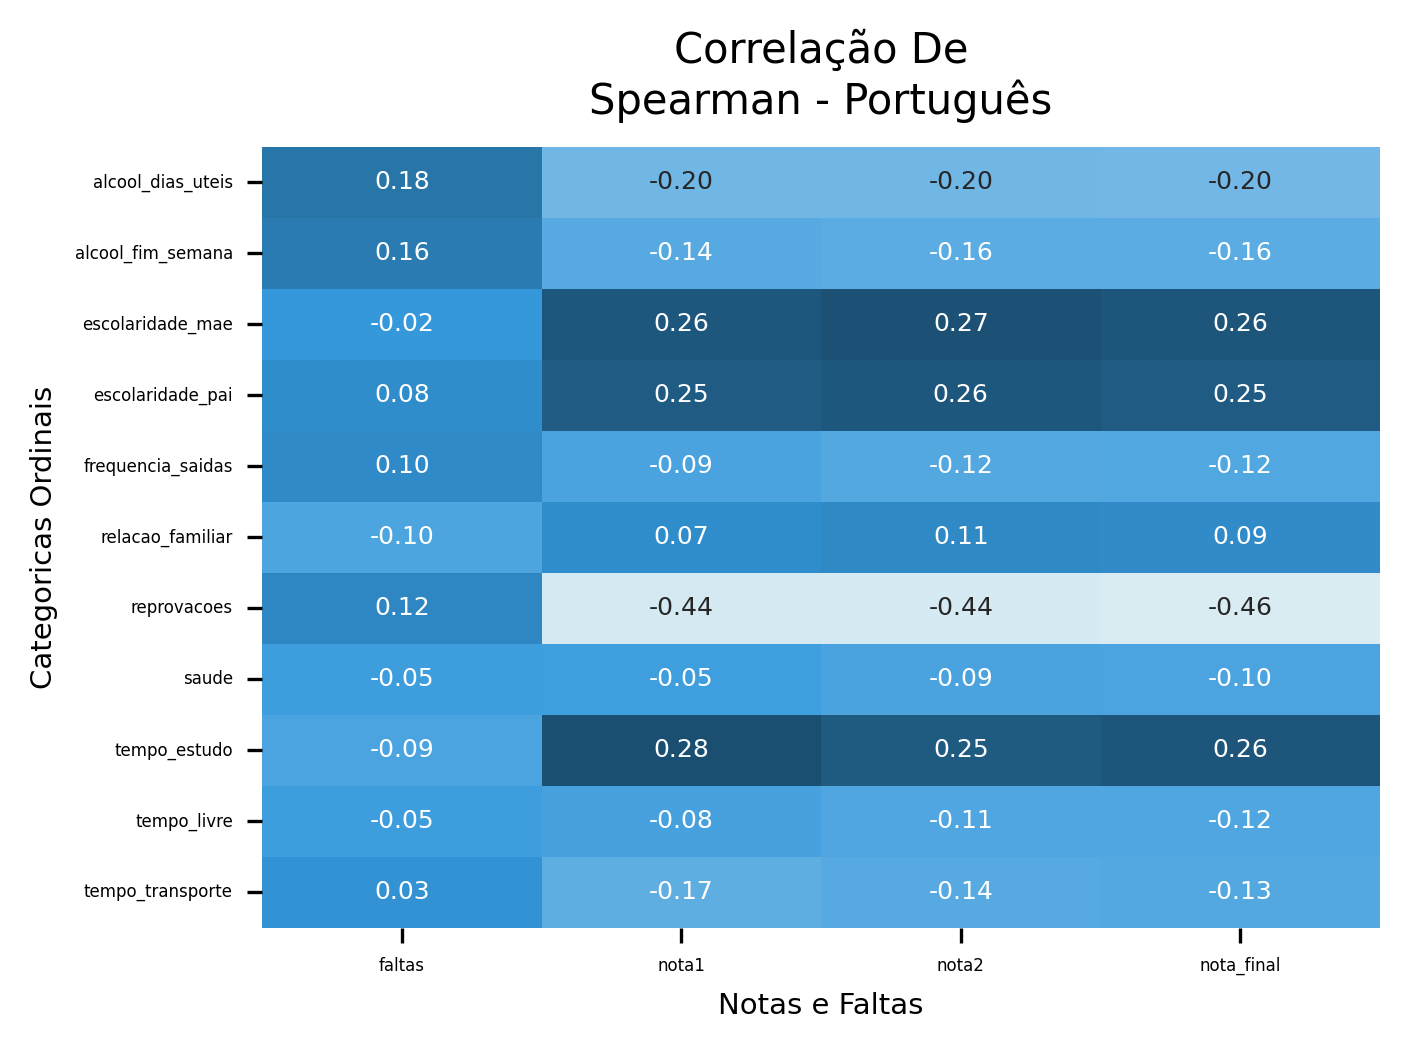

In [70]:
custom_heatmap(matriz_corr = heatmap_df,
               cores = cores,
               n_arq ='heatmap_ordinais',
              titulo = 'Correlação de Spearman' ,
               disciplina=materia)


### 3.3.2 Relações Familiares e Educacionais

##### **status_parental x responsavel legal**

In [71]:
pd.crosstab(df['status_parental'], df['responsavel_legal'], normalize='index') * 100

responsavel_legal,Mãe,Outro responsável,Pai
status_parental,,,
Juntos,70.379747,5.316456,24.303797
Separados,74.576271,15.254237,10.169492


**escolaridade do responsável legal**

In [72]:
pd.crosstab(df['responsavel_legal'], df['escolaridade_mae'], normalize='index') * 100

escolaridade_mae,0,1,2,3,4
responsavel_legal,,,,,
Mãe,0.621118,18.944099,30.745342,20.496894,29.192547
Outro responsável,3.333333,40.000000,13.333333,30.000000,13.333333
Pai,0.000000,21.568627,26.470588,25.490196,26.470588


In [73]:
pd.crosstab(df['responsavel_legal'], df['escolaridade_pai'], normalize='index') * 100

escolaridade_pai,0,1,2,3,4
responsavel_legal,,,,,
Mãe,1.552795,26.086957,34.161491,19.565217,18.633540
Outro responsável,0.000000,36.666667,23.333333,23.333333,16.666667
Pai,0.000000,21.568627,32.352941,22.549020,23.529412


##### **escolaridade e profissões dos pais**

In [74]:
pd.crosstab(df['escolaridade_mae'], df['escolaridade_pai'], normalize='index') * 100

escolaridade_pai,0,1,2,3,4
escolaridade_mae,,,,,
0,33.333333,33.333333,33.333333,0.000000,0.000000
1,3.157895,63.157895,27.368421,4.210526,2.105263
2,0.000000,27.692308,56.153846,11.538462,4.615385
3,0.000000,13.861386,31.683168,41.584158,12.871287
4,0.800000,4.800000,14.400000,25.600000,54.400000


In [75]:
pd.crosstab(df['profissao_mae'], df['profissao_pai'], normalize='index') * 100

profissao_pai,Dono de casa,Outra profissão,Professor(a),Serviços,Área da saúde
profissao_mae,,,,,
Dona de casa,14.285714,57.142857,2.197802,25.274725,1.098901
Outra profissão,4.469274,69.832402,3.351955,21.229050,1.117318
Professor(a),3.846154,36.538462,21.153846,30.769231,7.692308
Serviços,6.185567,41.237113,5.154639,45.360825,2.061856
Área da saúde,2.857143,42.857143,0.000000,37.142857,17.142857


In [76]:
pd.crosstab(df['escolaridade_mae'], df['profissao_mae'], normalize='index') * 100

profissao_mae,Dona de casa,Outra profissão,Professor(a),Serviços,Área da saúde
escolaridade_mae,,,,,
0,66.666667,33.333333,0.000000,0.000000,0.000000
1,46.315789,49.473684,0.000000,3.157895,1.052632
2,20.769231,50.769231,0.000000,24.615385,3.846154
3,13.861386,42.574257,1.980198,37.623762,3.960396
4,3.200000,17.600000,40.000000,19.200000,20.000000


In [77]:
pd.crosstab(df['escolaridade_pai'], df['profissao_pai'], normalize='index') * 100

profissao_pai,Dono de casa,Outra profissão,Professor(a),Serviços,Área da saúde
escolaridade_pai,,,,,
0,0.000000,100.000000,0.000000,0.000000,0.000000
1,8.547009,66.666667,0.000000,24.786325,0.000000
2,8.000000,60.000000,0.000000,30.666667,1.333333
3,5.376344,52.688172,0.000000,40.860215,1.075269
4,3.370787,32.584270,26.966292,23.595506,13.483146



### 3.3.3 Estilo de Vida e Organização do Tempo


In [78]:

# Tempo_livre × frequencia_saidas
pd.crosstab(df['tempo_livre'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
tempo_livre,,,,,
1,11.428571,34.285714,34.285714,17.142857,2.857143
2,15.189873,36.708861,31.645570,8.860759,7.594937
3,6.134969,27.607362,41.104294,17.177914,7.975460
4,2.290076,15.267176,29.007634,35.114504,18.320611
5,6.521739,15.217391,6.521739,21.739130,50.000000


In [79]:
# Tempo_livre × tempo_estudo
pd.crosstab(df['tempo_livre'], df['tempo_estudo'], normalize='index') * 100


tempo_estudo,1,2,3,4
tempo_livre,,,,
1,48.571429,42.857143,5.714286,2.857143
2,35.443038,35.443038,20.253165,8.860759
3,19.631902,55.828221,19.631902,4.907975
4,33.587786,49.618321,14.503817,2.290076
5,56.521739,39.130435,2.173913,2.173913


In [80]:
# Relacao_familiar × frequência de saídas
pd.crosstab(df['relacao_familiar'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
relacao_familiar,,,,,
1,16.666667,38.888889,5.555556,22.222222,16.666667
2,13.636364,13.636364,22.727273,22.727273,27.272727
3,3.947368,30.263158,40.789474,18.421053,6.578947
4,6.849315,25.570776,33.789954,21.004566,12.785388
5,6.722689,20.168067,28.571429,23.529412,21.008403


In [81]:
# Tempo_transporte × frequencia_saidas
pd.crosstab(df['tempo_transporte'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
tempo_transporte,,,,,
1,5.836576,27.626459,31.906615,22.568093,12.062257
2,9.027778,22.916667,34.722222,20.833333,12.500000
3,10.000000,15.000000,25.000000,20.000000,30.000000
4,0.000000,23.076923,23.076923,7.692308,46.153846


In [82]:
# tempo_transporte × tempo_estudo
pd.crosstab(df['tempo_transporte'], df['tempo_estudo'], normalize='index') * 100


tempo_estudo,1,2,3,4
tempo_transporte,,,,
1,28.404669,52.529183,15.564202,3.501946
2,37.500000,40.972222,16.666667,4.861111
3,40.000000,47.500000,7.500000,5.000000
4,30.769231,30.769231,23.076923,15.384615


In [83]:
# Alcool_dias_uteis × frequencia_saidas
pd.crosstab(df['alcool_dias_uteis'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
alcool_dias_uteis,,,,,
1,8.024691,27.777778,34.876543,17.901235,11.419753
2,5.194805,22.077922,28.571429,29.870130,14.285714
3,6.666667,13.333333,16.666667,36.666667,26.666667
4,0.000000,11.111111,22.222222,33.333333,33.333333
5,0.000000,7.142857,21.428571,14.285714,57.142857


In [84]:
# Alcool_fim_semana × frequencia_saidas
pd.crosstab(df['alcool_fim_semana'], df['frequencia_saidas'], normalize='index') * 100


frequencia_saidas,1,2,3,4,5
alcool_fim_semana,,,,,
1,11.299435,32.203390,31.638418,16.384181,8.474576
2,4.629630,29.629630,39.814815,17.592593,8.333333
3,3.571429,19.047619,38.095238,23.809524,15.476190
4,5.769231,9.615385,19.230769,42.307692,23.076923
5,3.030303,9.090909,12.121212,21.212121,54.545455


In [85]:
# Alcool_dias_uteis × genero
pd.crosstab(df['alcool_dias_uteis'], df['genero'], normalize='index') * 100


genero,Homem,Mulher
alcool_dias_uteis,,
1,32.407407,67.592593
2,53.246753,46.753247
3,76.666667,23.333333
4,66.666667,33.333333
5,85.714286,14.285714


In [86]:
# Alcool_fim_semana × idade
pd.crosstab(df['alcool_fim_semana'], df['idade'], normalize='index') * 100


idade,15,16,17,18,19,20,21,22
alcool_fim_semana,,,,,,,,
1,22.598870,29.943503,19.774011,19.774011,6.779661,0.564972,0.564972,0.000000
2,14.814815,29.629630,31.481481,20.370370,2.777778,0.000000,0.925926,0.000000
3,20.238095,20.238095,33.333333,20.238095,4.761905,1.190476,0.000000,0.000000
4,13.461538,32.692308,23.076923,23.076923,5.769231,1.923077,0.000000,0.000000
5,9.090909,27.272727,30.303030,30.303030,0.000000,0.000000,0.000000,3.030303


In [87]:
# Alcool_dias_uteis × idade
pd.crosstab(df['alcool_dias_uteis'], df['idade'], normalize='index') * 100



idade,15,16,17,18,19,20,21,22
alcool_dias_uteis,,,,,,,,
1,18.518519,30.555556,24.691358,20.987654,4.320988,0.617284,0.308642,0.000000
2,22.077922,25.974026,29.870130,18.181818,2.597403,1.298701,0.000000,0.000000
3,20.000000,20.000000,33.333333,16.666667,10.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,11.111111,55.555556,33.333333,0.000000,0.000000,0.000000
5,0.000000,21.428571,35.714286,28.571429,0.000000,0.000000,7.142857,7.142857


### 3.3.5 Síntese Analítica dos Destaques

Esta seção apresenta um panorama integrado das relações entre variáveis categóricas, destacando padrões familiares, comportamentais e de organização do tempo, com base nos dados da disciplina de Língua Portuguesa.

---

#### **1. Relações Familiares e Educacionais**

- **Status parental e responsável legal**:
  - Alunos com pais separados possuem maior chance de ter “outro responsável” legal (15,3%) do que os com pais juntos (5,3%);
  - A predominância da mãe como responsável é constante em ambos os contextos (>70%), enquanto a presença paterna cai de 24,3% para 10,2% no caso de pais separados.

- **Escolaridade dos responsáveis**:
  - Mães tendem a apresentar escolaridade mais elevada: no grupo de responsáveis do tipo “mãe”, quase 30% estão no nível 4;
  - Pais como responsáveis legais apresentam distribuição mais homogênea, com destaque nos níveis 2 e 3;
  - Responsáveis “outros” concentram-se nos níveis 1 e 3.

- **Associação entre escolaridade e profissão**:
  - Mães com baixa escolaridade (nível 0 ou 1) atuam majoritariamente como donas de casa (até 66,7%);
  - A escolaridade elevada (nível 4) está fortemente associada às profissões de professoras (40%) e área da saúde (20%);
  - Entre os pais, a profissão de professor torna-se expressiva apenas a partir do nível 4 (26,9%), enquanto os de nível 1 ou 2 concentram-se em serviços e ocupações indefinidas.

- **Correlação entre escolaridade dos pais**:
  - Correlação moderada positiva entre `escolaridade_mae` e `escolaridade_pai` (ρ = 0.66), evidenciando afinidade educacional entre os responsáveis.

---

#### **2. Estilo de Vida e Organização do Tempo**

- **Tempo livre e frequência de saídas**:
  - Há tendência de maior frequência de saídas entre alunos com mais tempo livre. Com 5h disponíveis, 50% saem 5 vezes por semana;
  - Os alunos com apenas 1h de tempo livre concentram-se majoritariamente em 1–2 saídas semanais.

- **Tempo de estudo versus tempo livre**:
  - Com 5h de tempo livre, 87,5% dos alunos estudam no máximo 2h por dia;
  - Já os com 3h de tempo livre apresentam distribuição mais equilibrada, incluindo até 20% que estudam 3h diárias.

- **Deslocamento e rotina escolar**:
  - Estudantes com deslocamento mais longo (nível 4) têm maior frequência de saídas (46% saem 5x/semana) e menor tempo de estudo;
  - Esses padrões indicam menor comprometimento com a rotina acadêmica em razão do tempo gasto no transporte.

- **Consumo de álcool**:
  - Alunos que consomem álcool com maior frequência (níveis 4 ou 5) também saem mais vezes por semana;
  - A maioria desses estudantes são homens (até 85%) e têm entre 17 e 18 anos;
  - Correlação positiva significativa entre `alcool_dias_uteis` e `frequencia_saidas` (ρ = 0.26), além de correlação alta entre os dois tipos de consumo alcoólico (ρ = 0.62).

- **Relação familiar e comportamento**:
  - Alunos com piores relações familiares (níveis 1 ou 2) tendem a extremos de comportamento: tanto alta como baixíssima frequência de saídas;
  - Relações estáveis (níveis 4 e 5) concentram-se em comportamentos mais equilibrados (2–4 saídas por semana).

---

#### **3. Correlações com Desempenho Acadêmico**

- **Impacto das reprovações**:
  - `reprovacoes` apresenta as maiores correlações negativas com as notas (ρ = –0.36 com `nota_final`);
  - Também é negativamente correlacionada com `nota1` e `nota2`, confirmando seu efeito cumulativo sobre o desempenho.

- **Outras correlações negativas**:
  - `frequencia_saidas` e `alcool_fim_semana` apresentam correlações negativas com desempenho (ρ ≈ –0.15);
  - `tempo_livre` e `tempo_transporte` têm impacto mais fraco, mas indicam tendências semelhantes.

- **Fatores positivamente associados**:
  - `escolaridade_mae` e `escolaridade_pai` têm correlação positiva com todas as notas (ρ ≈ 0.21–0.23);
  - `tempo_estudo` também apresenta leve correlação positiva com `nota1` (ρ = 0.12), reforçando seu papel como fator de apoio.

- **Relações entre variáveis categóricas**:
  - `tempo_livre` e `frequencia_saidas` estão fortemente correlacionadas (ρ = 0.29);
  - `tempo_transporte` se correlaciona negativamente com `tempo_estudo` (ρ = –0.24), indicando possível competição entre essas atividades.

---

Esses resultados revelam como fatores familiares, sociais e comportamentais contribuem conjuntamente para o desempenho acadêmico em Português, evidenciando a importância de abordagens interdisciplinares para a compreensão do fracasso ou sucesso escolar.



---

## 3.4 Avaliação de Atributos com Índice de Perfil Composto



### 3.4.1 Metodologia de Seleção

*Para criação das tabelas da seção calculo-se um índice composto de perfilamento, combinando critérios de distribuição, diversidade e impacto na variável de interesse (nota final ou faltas). Os critérios avaliados foram:*

1. Frequência mínima absoluta e relativa:
A variável deve apresentar frequência mínima por categoria, ajustada ao tamanho da amostra e ao número total de categorias. Isso evita categorias muito raras.

2. Entropia de Shannon (diversidade):
Mede o grau de equilíbrio entre as categorias. Quanto mais equilibradas, maior a entropia e, potencialmente, maior a capacidade da variável de discriminar padrões.

3. Gap de desempenho entre categorias:
Representa a diferença entre as médias da variável de interesse (ex.: nota final) entre as categorias da variável avaliada. Quanto maior essa diferença, maior a capacidade da variável em segmentar o desempenho.

5. Score de Perfil Composto:
Índice final é calculado como a média ponderada da entropia normalizada e do gap de desempenho, permitindo ordenar as variáveis mais informativas.

6. Alertas de dispersão:
Variáveis com alta dispersão (> 80%) e muitas categorias são sinalizadas, pois podem ser menos interpretáveis ou sofrer com sparsidade em modelos.

Este método permite filtrar automaticamente variáveis nominais relevantes para auxiliar na seleção de atributos qualitativos de interesse.

### 3.4.2 Aplicação do Índice de Perfil por Variável de Desempenho
A seguir, aplicamos o índice composto para diferentes variáveis de desempenho: as três notas individuais, a média das notas e a quantidade de faltas.


##### **Nota 1**

In [88]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='nota1')

Tamanho da amostra (categórico): 454


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
tempo_estudo,4,0.825,2.315
escolaridade_mae,5,0.875,2.147
profissao_mae,5,0.910,2.015
profissao_pai,5,0.705,2.533
escola,2,0.926,1.780
escolaridade_pai,5,0.876,1.839
frequencia_saidas,5,0.938,1.491
motivo_escolha_escola,4,0.920,1.461
alcool_fim_semana,5,0.907,1.327


##### **Nota 2**

In [89]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='nota2')

Tamanho da amostra (categórico): 454


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
profissao_pai,5,0.705,2.450
frequencia_saidas,5,0.938,1.869
escolaridade_mae,5,0.875,1.997
profissao_mae,5,0.910,1.873
tempo_estudo,4,0.825,2.073
escolaridade_pai,5,0.876,1.859
escola,2,0.926,1.689
tempo_transporte,4,0.723,1.967
relacao_familiar,5,0.793,1.793


##### **Nota Final**

In [90]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas)

Tamanho da amostra (categórico): 454


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
tempo_estudo,4,0.825,2.310
escola,2,0.926,1.967
frequencia_saidas,5,0.938,1.900
profissao_mae,5,0.910,1.936
escolaridade_pai,5,0.876,1.983
escolaridade_mae,5,0.875,1.958
tempo_livre,5,0.907,1.834
motivo_escolha_escola,4,0.920,1.785
profissao_pai,5,0.705,2.200


##### **Média das 3 Notas** 

In [91]:
df_copy = df.copy()
df_copy['media_notas'] = (df_copy['nota1'] + df_copy['nota2'] + df_copy['nota_final'])/3

avaliacao_variacao_pontuacao_media_por_categoria(df_copy,variaveis_categoricas,coluna_avaliada='media_notas')

Tamanho da amostra (categórico): 454


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
profissao_mae,5,0.910,1.941
tempo_estudo,4,0.825,2.138
profissao_pai,5,0.705,2.361
escolaridade_mae,5,0.875,1.937
escola,2,0.926,1.812
frequencia_saidas,5,0.938,1.753
escolaridade_pai,5,0.876,1.894
motivo_escolha_escola,4,0.920,1.571
tempo_livre,5,0.907,1.534


**Faltas**

In [92]:
avaliacao_variacao_pontuacao_media_por_categoria(df,variaveis_categoricas,coluna_avaliada='faltas')

Tamanho da amostra (categórico): 454


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_mae,5,0.875,4.832
escolaridade_pai,5,0.876,3.624
profissao_mae,5,0.910,2.904
alcool_fim_semana,5,0.907,2.663
frequencia_saidas,5,0.938,1.776
escola,2,0.926,1.781
relacao_familiar,5,0.793,1.998
tempo_estudo,4,0.825,1.697
tempo_livre,5,0.907,1.018



### 3.4.3 Considerações para a Seleção de Atributos


In [93]:
for n in notas:

    print(f'Análise de Impacto - {n} :\n')
    print('---'*20)
    display(diagnostico_impacto_variaveis_categoricas(df,
                                          variaveis_categoricas=variaveis_categoricas,
                                          materia=materia,
                                          coluna_avaliada=n))

Análise de Impacto - nota1 :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.78
[FRACO] genero → desequilíbrio: 0.59 | gap: 0.35
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.10
[MODERADO] status_parental → desequilíbrio: 0.87 | gap: 0.65
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 2.02
[FORTE] profissao_pai → desequilíbrio: 0.55 | gap: 2.53
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.46
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.74
[MODERADO] apoio_escolar → desequilíbrio: 0.89 | gap: 0.84
[FRACO] apoio_familiar → desequilíbrio: 0.62 | gap: 0.13
[MODERADO] aulas_particulares → desequilíbrio: 0.95 | gap: 0.68
[FRACO] atividades_extracurriculares → desequilíbrio: 0.52 | gap: 0.24
[MODERADO] frequentou_creche → desequilíbrio: 0.79 | gap: 0.23
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 3.03
[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.29
[FRAC

,variavel,tipo_analise,gap,desequilibrio,impacto
0,reprovacoes,analise_portugues,3.896992,0.837004,forte
1,interesse_ensino_superior,analise_portugues,3.029503,0.900881,forte
2,profissao_pai,analise_portugues,2.533333,0.552863,forte
3,tempo_estudo,analise_portugues,2.314966,0.477974,moderado
4,escolaridade_mae,analise_portugues,2.146667,0.286344,moderado
5,alcool_dias_uteis,analise_portugues,2.074074,0.713656,moderado
6,profissao_mae,analise_portugues,2.015385,0.394273,moderado
7,escolaridade_pai,analise_portugues,1.838663,0.330396,moderado
8,escola,analise_portugues,1.779912,0.658590,moderado
9,responsavel_legal,analise_portugues,1.737255,0.709251,moderado


Análise de Impacto - nota2 :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.69
[FRACO] genero → desequilíbrio: 0.59 | gap: 0.43
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.04
[MODERADO] status_parental → desequilíbrio: 0.87 | gap: 0.65
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 1.87
[MODERADO] profissao_pai → desequilíbrio: 0.55 | gap: 2.45
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.47
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.44
[MODERADO] apoio_escolar → desequilíbrio: 0.89 | gap: 0.49
[FRACO] apoio_familiar → desequilíbrio: 0.62 | gap: 0.15
[MODERADO] aulas_particulares → desequilíbrio: 0.95 | gap: 0.26
[FRACO] atividades_extracurriculares → desequilíbrio: 0.52 | gap: 0.18
[MODERADO] frequentou_creche → desequilíbrio: 0.79 | gap: 0.34
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 2.92
[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.28
[F

,variavel,tipo_analise,gap,desequilibrio,impacto
0,reprovacoes,analise_portugues,4.204386,0.837004,forte
1,interesse_ensino_superior,analise_portugues,2.919967,0.900881,forte
2,profissao_pai,analise_portugues,2.450000,0.552863,moderado
3,tempo_estudo,analise_portugues,2.073469,0.477974,moderado
4,escolaridade_mae,analise_portugues,1.997333,0.286344,moderado
5,tempo_transporte,analise_portugues,1.967076,0.566079,moderado
6,profissao_mae,analise_portugues,1.872527,0.394273,moderado
7,frequencia_saidas,analise_portugues,1.868639,0.319383,moderado
8,escolaridade_pai,analise_portugues,1.858734,0.330396,moderado
9,relacao_familiar,analise_portugues,1.792998,0.482379,moderado


Análise de Impacto - nota_final :

------------------------------------------------------------
[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.97
[FRACO] genero → desequilíbrio: 0.59 | gap: 0.62
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.23
[MODERADO] status_parental → desequilíbrio: 0.87 | gap: 0.47
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 1.94
[MODERADO] profissao_pai → desequilíbrio: 0.55 | gap: 2.20
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.78
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.32
[MODERADO] apoio_escolar → desequilíbrio: 0.89 | gap: 0.84
[FRACO] apoio_familiar → desequilíbrio: 0.62 | gap: 0.31
[MODERADO] aulas_particulares → desequilíbrio: 0.95 | gap: 0.67
[FRACO] atividades_extracurriculares → desequilíbrio: 0.52 | gap: 0.16
[MODERADO] frequentou_creche → desequilíbrio: 0.79 | gap: 0.33
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 3.33
[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.

,variavel,tipo_analise,gap,desequilibrio,impacto
0,reprovacoes,analise_portugues,4.740351,0.837004,forte
1,interesse_ensino_superior,analise_portugues,3.328063,0.900881,forte
2,tempo_estudo,analise_portugues,2.310204,0.477974,moderado
3,profissao_pai,analise_portugues,2.200000,0.552863,moderado
4,alcool_dias_uteis,analise_portugues,2.197531,0.713656,moderado
5,escolaridade_pai,analise_portugues,1.983386,0.330396,moderado
6,escola,analise_portugues,1.967354,0.658590,moderado
7,escolaridade_mae,analise_portugues,1.957895,0.286344,moderado
8,profissao_mae,analise_portugues,1.936264,0.394273,moderado
9,frequencia_saidas,analise_portugues,1.900166,0.319383,moderado


### 3.4.3 Diagnóstico e Seleção Final dos Atributos Categóricos

Com base na aplicação do índice de perfil composto — que combina a diversidade (entropia) das categorias com a variação média de desempenho entre elas — foi possível ranquear as variáveis qualitativas mais informativas do conjunto. Foram avaliadas individualmente as variáveis `nota1`, `nota2`, `nota_final`, a média das três notas e também a variável `faltas`.

Em todos os casos, observou-se que certas variáveis mantêm **desempenho consistente** em sua capacidade de segmentar os estudantes, tanto pelo gap de pontuação média quanto pela diversidade interna de categorias.

####  **Destaques entre as variáveis mais informativas**:

- **Tempo de estudo** e **profissão dos responsáveis (pai e mãe)** figuram entre os principais atributos em todas as métricas avaliadas, com gaps de desempenho superiores a 2 pontos em média.
- **Escolaridade dos pais** também se mostra fortemente associada às notas e faltas dos estudantes.
- **Frequência de saídas**, **motivo da escolha da escola** e **tempo livre** apresentam valores altos de entropia, sendo relevantes na diferenciação de padrões comportamentais.
- A variável **reprovações** se destaca com o maior gap de desempenho entre todas as variáveis analisadas (`gap ≈ 4.7` na nota final), além de ser altamente desequilibrada — o que indica forte poder discriminativo, mas também risco de reforçar padrões já consolidados.
- O atributo **interesse no ensino superior** apresentou impacto classificado como forte, com grande variação de notas entre os grupos e elevado desequilíbrio (90% dos alunos têm interesse declarado), sendo uma variável crítica para entender expectativas e metas acadêmicas.

####  Diagnóstico de impacto (nota final):

Com base na análise de impacto individual para a `nota_final`, as variáveis categóricas foram classificadas em três faixas:

- **Impacto forte**: `reprovacoes`, `interesse_ensino_superior`, `profissao_pai`
- **Impacto moderado**: `tempo_estudo`, `escolaridade_mae`, `profissao_mae`, `frequencia_saidas`, `relacao_familiar`, `tempo_livre`, `alcool_dias_uteis`, `escola`, `escolaridade_pai`, `motivo_escolha_escola`, `tempo_transporte`, entre outras
- **Impacto fraco**: `genero`, `relacionamento_romantico`, `apoio_familiar`, `atividades_extracurriculares`, `tamanho_familia`

####  **Considerações finais**

Com base nos critérios de entropia, gap de desempenho e equilíbrio entre categorias, foram identificadas aproximadamente **12 a 15 variáveis qualitativas com potencial relevante para modelagem**. 



## 3.5 Análise de Grupos Específicos e Casos Extremos

Nesta etapa, exploramos perfis atípicos ou contrastantes, como estudantes com nota zero, histórico de reprovações ou grupos que concentram características de risco.



### 3.5.1 Perfil dos Alunos com Nota Final Igual a Zero



In [94]:
for n in notas:
    df_zero = df[df[n]==0]
    print(f"Quantidade de alunos com {n} = 0: {df_zero.shape[0]}\n")
    print(f"Porcentagem de alunos com {n} = 0: {df_zero.shape[0] / df.shape[0] * 100:.2f}%\n")
    print("\n countagem de alunos com 0 em cada variável categórica:\n")
    df_zero.value_counts(variaveis_categoricas)

Quantidade de alunos com nota1 = 0: 1

Porcentagem de alunos com nota1 = 0: 0.22%


 countagem de alunos com 0 em cada variável categórica:

Quantidade de alunos com nota2 = 0: 5

Porcentagem de alunos com nota2 = 0: 1.10%


 countagem de alunos com 0 em cada variável categórica:

Quantidade de alunos com nota_final = 0: 9

Porcentagem de alunos com nota_final = 0: 1.98%


 countagem de alunos com 0 em cada variável categórica:



In [95]:
resumo =add_features_describe_pd(df_zero,
                                 colunas=variaveis_categoricas,
                                 estudo_frequencia=True)

resumo = resumo[resumo['Frequência Relativa Dominante(%)'] > 65]

resumo

Tamanho da amostra (categórico): 9


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Mousinho da Silveira,8,88.888889,22.222222
endereco,2,Rural,6,66.666667,22.222222
status_parental,2,Juntos,7,77.777778,22.222222
profissao_pai,3,Outra profissão,7,77.777778,33.333333
responsavel_legal,3,Mãe,7,77.777778,33.333333
apoio_escolar,2,Não,8,88.888889,22.222222
apoio_familiar,2,Não,7,77.777778,22.222222
aulas_particulares,2,Não,8,88.888889,22.222222
atividades_extracurriculares,2,Sim,6,66.666667,22.222222


### 3.5.2 Aprovados vs Reprovados

In [96]:
add_features_describe_pd(df_reprovados,estudo_frequencia=True,colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 70


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Mousinho da Silveira,48,68.571429,2.857143
genero,2,Mulher,38,54.285714,2.857143
endereco,2,Urbano,39,55.714286,2.857143
status_parental,2,Juntos,59,84.285714,2.857143
profissao_mae,5,Outra profissão,28,40.0,7.142857
profissao_pai,5,Outra profissão,41,58.571429,7.142857
motivo_escolha_escola,4,Curso específico,38,54.285714,5.714286
responsavel_legal,3,Mãe,55,78.571429,4.285714
apoio_escolar,2,Não,63,90.0,2.857143


In [97]:
print('Avaliação de Impacto - Grupo de Reprovados - Nota Final:')
avaliacao_variacao_pontuacao_media_por_categoria(df_reprovados,variaveis_categoricas,coluna_avaliada='nota_final')


Avaliação de Impacto - Grupo de Reprovados - Nota Final:
Tamanho da amostra (categórico): 70


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
profissao_mae,5,0.855,5.733
relacao_familiar,5,0.902,3.821
frequencia_saidas,5,0.979,3.212
alcool_dias_uteis,5,0.696,4.167
escolaridade_pai,4,0.864,2.500
escolaridade_mae,4,0.969,1.867
apoio_familiar,2,0.979,1.622
saude,5,0.913,1.477
alcool_fim_semana,5,0.960,1.145


##### Perfilamento Aprovados

In [98]:
add_features_describe_pd(df_aprovados,
                            colunas=variaveis_categoricas,
                            estudo_frequencia=True)

Tamanho da amostra (categórico): 384


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,277,72.135417,0.520833
genero,2,Mulher,229,59.635417,0.520833
endereco,2,Urbano,276,71.875,0.520833
status_parental,2,Juntos,336,87.5,0.520833
profissao_mae,5,Outra profissão,151,39.322917,1.302083
profissao_pai,5,Outra profissão,210,54.6875,1.302083
motivo_escolha_escola,4,Curso específico,155,40.364583,1.041667
responsavel_legal,3,Mãe,267,69.53125,0.78125
apoio_escolar,2,Não,342,89.0625,0.520833


In [99]:
print('Avaliação de Impacto - Grupo de Aprovados - Nota Final:')
avaliacao_variacao_pontuacao_media_por_categoria(df_aprovados,variaveis_categoricas,coluna_avaliada='nota_final')


Avaliação de Impacto - Grupo de Aprovados - Nota Final:
Tamanho da amostra (categórico): 384


,Total de Categorias,Entropia Normalizada,Variação de Desempenho por Categoria
Variável,,,
escolaridade_mae,5,0.871,2.293
profissao_mae,5,0.915,1.847
tempo_transporte,4,0.706,1.668
tempo_estudo,4,0.836,1.341
escolaridade_pai,5,0.882,1.207
alcool_fim_semana,5,0.892,1.164
saude,5,0.938,1.026
profissao_pai,5,0.719,1.393
relacao_familiar,5,0.759,1.256



### 3.5.2 Diferenças de Perfil entre Grupos de Desempenho


In [100]:
df_dif, n_baixo, n_alto, q1_lim, q3_lim = identificar_extremos_comparaveis(
    df, 'nota_final', variaveis_categoricas
)

Tentando otimizar limites Q1 e Q3...
  Nova melhor configuração encontrada: q=0.100 (Q1=9.00, Q3=16.00, N_b=70, N_a=56, Diff=14)
  Nova melhor configuração encontrada: q=0.225 (Q1=10.00, Q3=14.00, N_b=136, N_a=138, Diff=2)
Melhor configuração encontrada:


,Variável,Categoria,% Grupo Nota Baixa (≤10.0),% Grupo Nota Alta (≥14.0),Diferença Absoluta (%)
17,reprovacoes,0,57.4% (78/136),98.6% (136/138),41.2
0,escola,Gabriel Pereira,44.1% (60/136),76.8% (106/138),32.7
1,escola,Mousinho da Silveira,55.9% (76/136),23.2% (32/138),32.7
12,escolaridade_mae,4,13.2% (18/136),41.3% (57/138),28.1
15,tempo_estudo,1,46.3% (63/136),20.3% (28/138),26.0
18,reprovacoes,1,26.5% (36/136),0.7% (1/138),25.7
7,interesse_ensino_superior,Não,24.3% (33/136),0.7% (1/138),23.5
8,interesse_ensino_superior,Sim,75.7% (103/136),99.3% (137/138),23.5
13,escolaridade_pai,1,39.7% (54/136),17.4% (24/138),22.3
10,acesso_internet,Sim,66.2% (90/136),88.4% (122/138),22.2


Figura salva em: imagens\graficos_diferencas_perfil\top10_diferencas_perfil_português.png


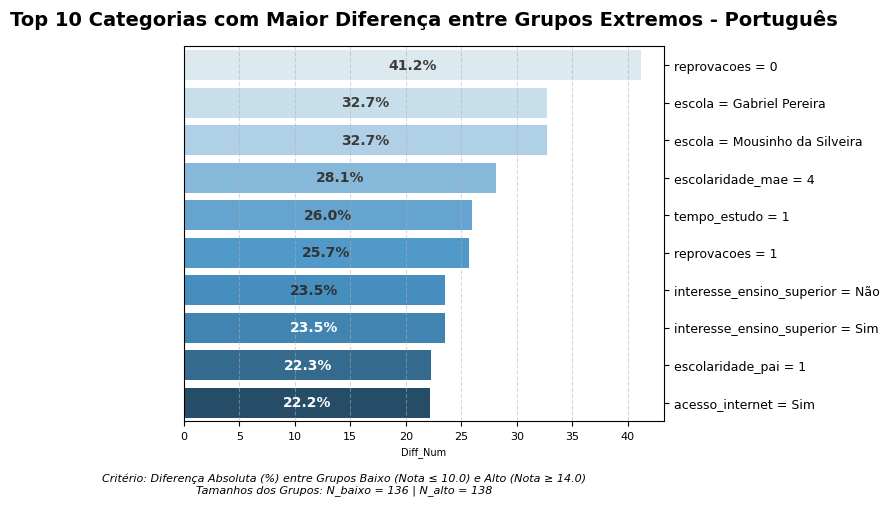

In [101]:
plot_top_diferencas_extremos(
    df_diferencas=df_dif,
    materia='portugues',  
    q1_lim=q1_lim,
    q3_lim=q3_lim,
    n_baixo=n_baixo,
    n_alto=n_alto,
    top_n=10,  
    diretorio='graficos_diferencas_perfil',
    salvar=True
)

### 3.5.5 Síntese Analítica dos Destaques

A análise de grupos extremos e casos específicos revelou padrões importantes sobre os fatores associados ao baixo desempenho escolar em Língua Portuguesa.

- **Casos críticos com nota zero** foram pouco frequentes (≈ 2%), mas indicam um perfil de risco marcante:
  - 89% são da escola *Mousinho da Silveira* e vivem em área rural.
  - A grande maioria não possui apoio escolar (89%) nem familiar (78%) e não realiza aulas particulares.
  - Esses alunos vêm de contextos com baixa escolaridade parental, embora 66% tenham declarado interesse no ensino superior — evidenciando o descompasso entre aspirações e suporte disponível.

- **Comparando grupos extremos de desempenho** (nota ≤ 10 vs. nota ≥ 14), identificaram-se diferenças expressivas:
  - Alunos de alto desempenho concentram-se na escola *Gabriel Pereira*, com maior tempo de estudo, acesso à internet e interesse no ensino superior.
  - Entre os destaques estão: `reprovacoes`, `escola`, `tempo_estudo`, `interesse_ensino_superior`, `escolaridade dos pais` e `acesso_internet`.
  - A variável `reprovacoes` apresentou o maior contraste: 98,6% dos alunos de alto desempenho nunca foram reprovados, contra 57,4% no grupo de baixo desempenho — uma diferença de 41,2 p.p.

- **Perfil geral dos alunos reprovados** (n = 70):
  - Alta concentração na escola *Mousinho da Silveira* (68%) e menor escolaridade dos pais.
  - Tempo de estudo reduzido (51% estudam apenas 1h/dia), pouco apoio familiar (42%) e alta frequência de consumo de álcool nos dias úteis (60%).
  - A variável `profissao_mae` apresentou o maior gap de desempenho interno (5,73 pontos), seguida por `relacao_familiar`, `frequencia_saidas` e `alcool_dias_uteis`.

- **Perfil dos alunos aprovados** (n = 384):
  - Maior equilíbrio entre escolas e presença consistente de fatores de proteção, como `tempo_estudo = 2h`, `interesse_ensino_superior` e `acesso_internet`.
  - 90% não têm histórico de reprovação, e 73% relatam consumo de álcool moderado ou inexistente durante a semana.
  - A escolaridade e a profissão dos pais estão mais distribuídas entre níveis médios e altos, favorecendo o desempenho.

Esses resultados reforçam que a reprovação não é um evento isolado, mas parte de um conjunto de fatores interligados que incluem apoio familiar, contexto escolar, condições socioeconômicas e hábitos de estudo.


## 3.6 Distribuição das Notas por Grupos Categóricos

##### **Nota 1**

[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.78
[FRACO] genero → equilíbrio: 0.59 | gap: 0.35
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.10
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 2.02
[FORTE] profissao_pai → desequilíbrio: 0.55 | gap: 2.53
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


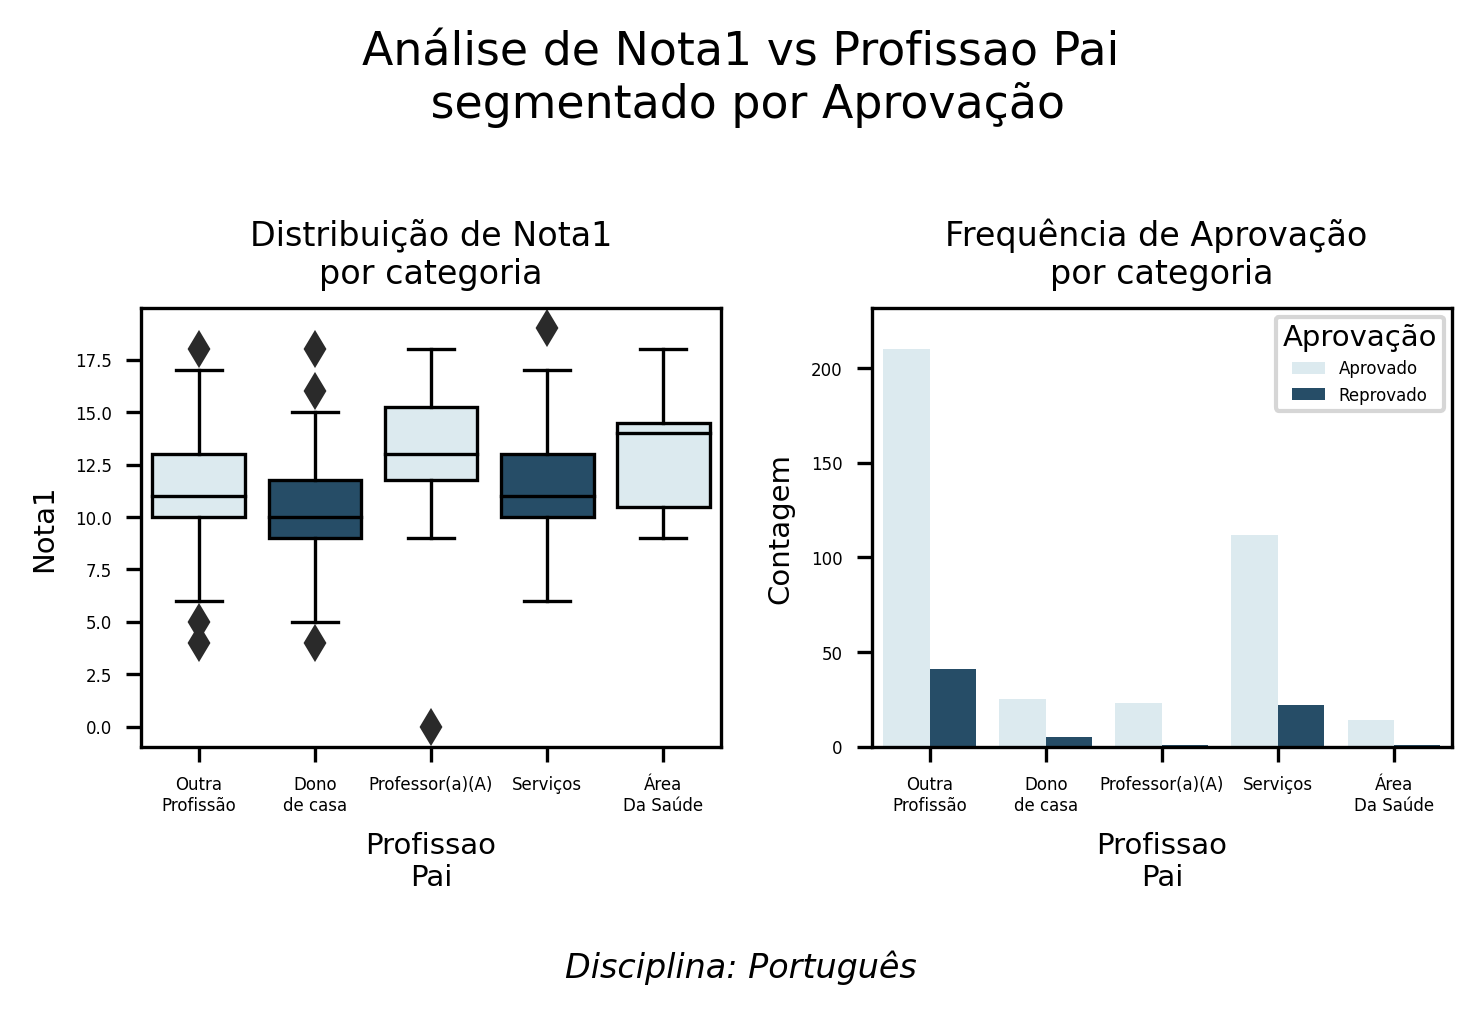

[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.46
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.74
[MODERADO] apoio_escolar → desequilíbrio: 0.89 | gap: 0.84
[FRACO] apoio_familiar → equilíbrio: 0.62 | gap: 0.13
[FRACO] atividades_extracurriculares → equilíbrio: 0.52 | gap: 0.24
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 3.03
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


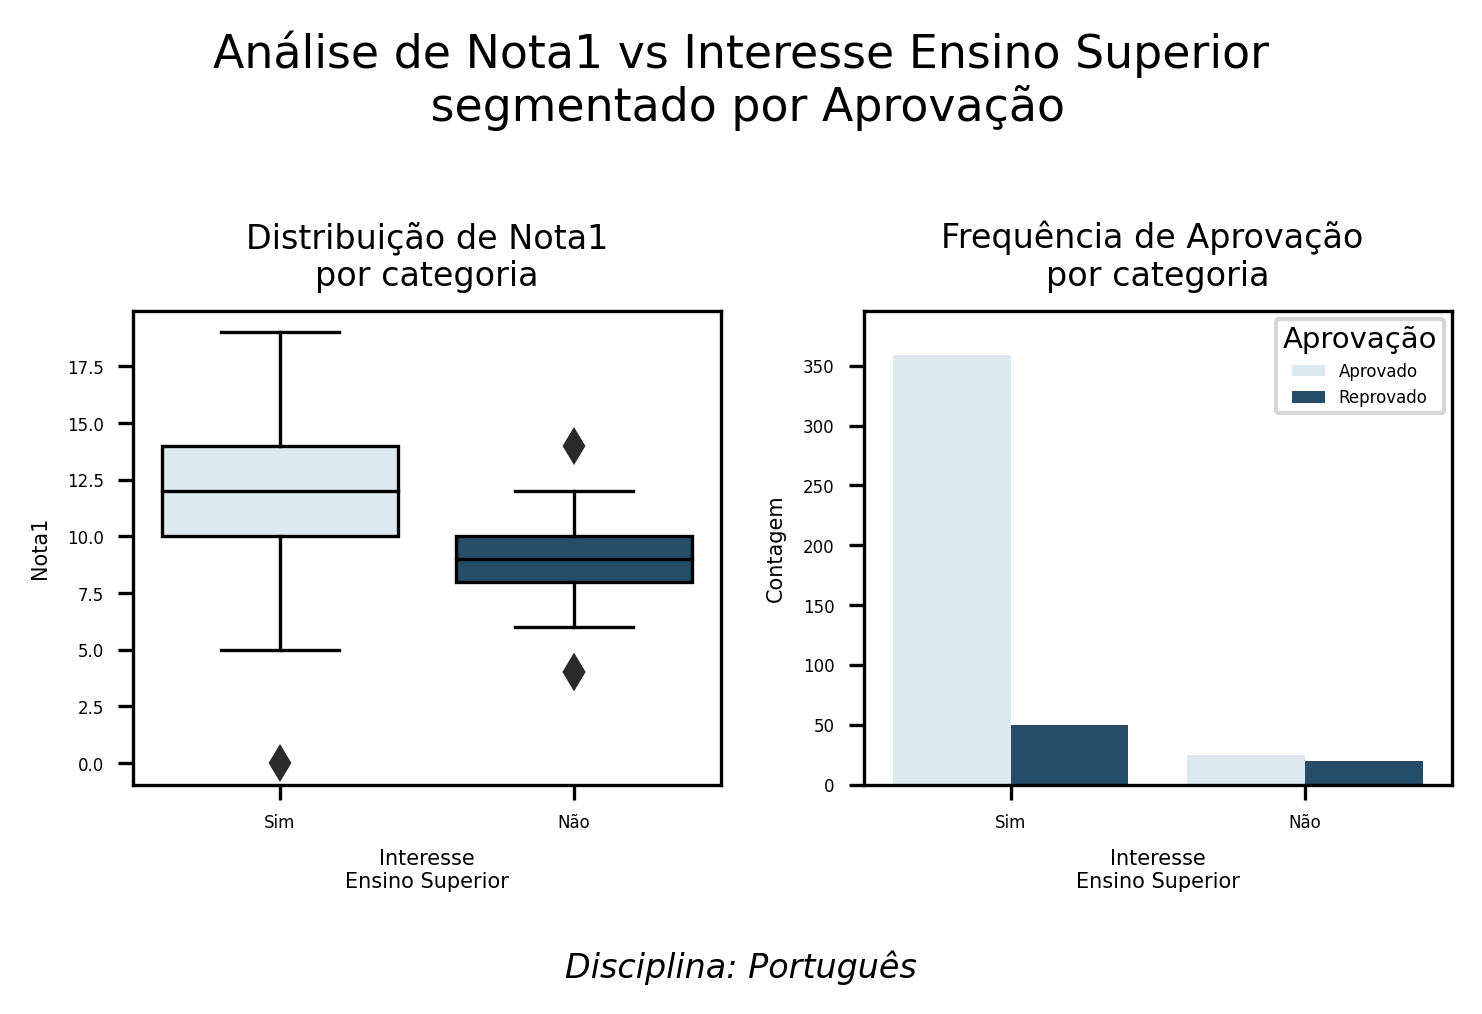

[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.29
[FRACO] relacionamento_romantico → equilíbrio: 0.62 | gap: 0.40
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.03
[MODERADO] escolaridade_mae → desequilíbrio: 0.29 | gap: 2.15
[MODERADO] escolaridade_pai → desequilíbrio: 0.33 | gap: 1.84
[MODERADO] relacao_familiar → desequilíbrio: 0.48 | gap: 1.21
[MODERADO] tempo_livre → desequilíbrio: 0.36 | gap: 1.28
[MODERADO] frequencia_saidas → desequilíbrio: 0.32 | gap: 1.49
[FRACO] saude → equilíbrio: 0.39 | gap: 0.48
[MODERADO] tempo_estudo → desequilíbrio: 0.48 | gap: 2.31
[MODERADO] tempo_transporte → desequilíbrio: 0.57 | gap: 1.44
[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 2.07
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 1.33
[FORTE] reprovacoes → desequilíbrio: 0.84 | gap: 3.90
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


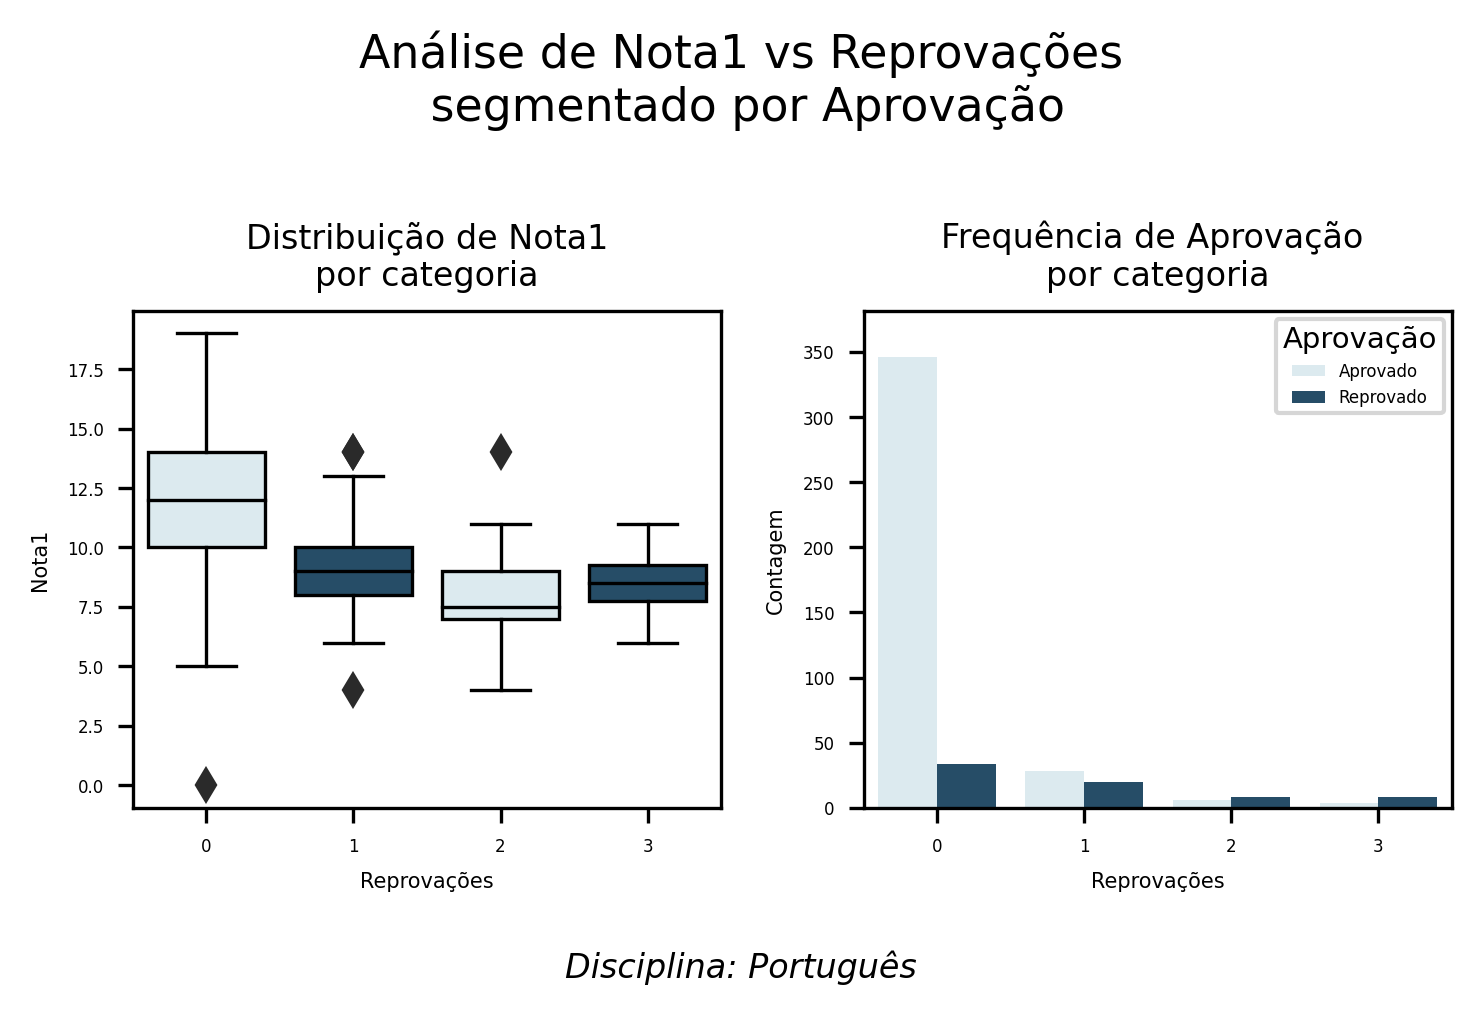

In [102]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota1'
                                    )

##### **Nota 2**

[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.69
[FRACO] genero → equilíbrio: 0.59 | gap: 0.43
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.04
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 1.87
[MODERADO] profissao_pai → desequilíbrio: 0.55 | gap: 2.45
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.47
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.44
[FRACO] apoio_familiar → equilíbrio: 0.62 | gap: 0.15
[FRACO] atividades_extracurriculares → equilíbrio: 0.52 | gap: 0.18
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 2.92
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


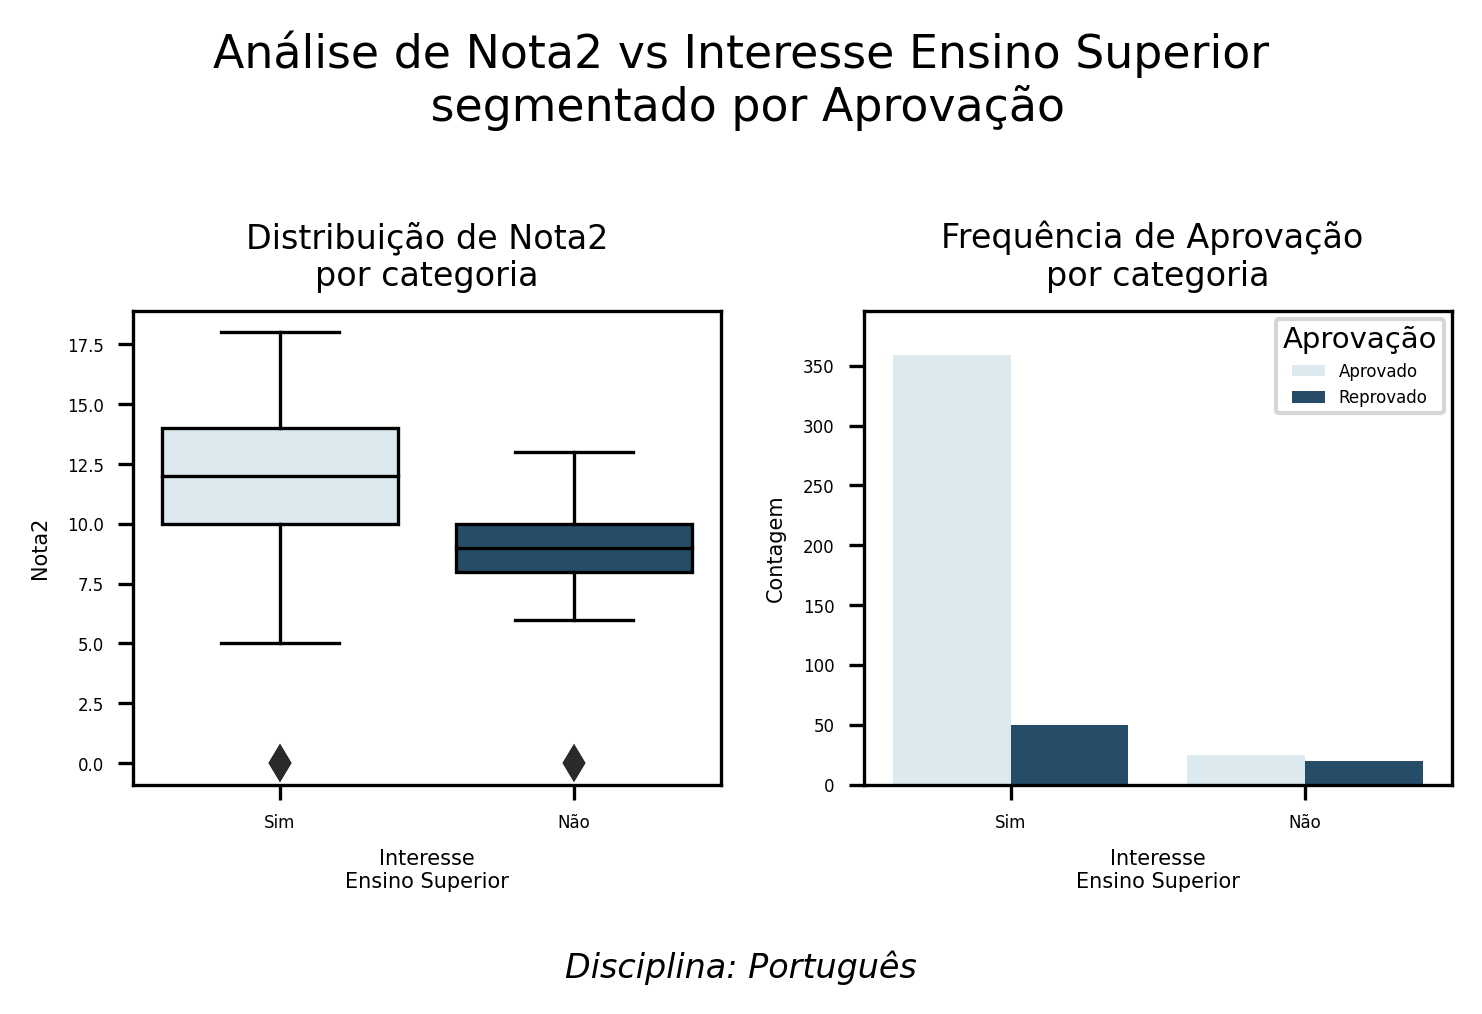

[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.28
[FRACO] relacionamento_romantico → equilíbrio: 0.62 | gap: 0.64
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.00
[MODERADO] escolaridade_mae → desequilíbrio: 0.29 | gap: 2.00
[MODERADO] escolaridade_pai → desequilíbrio: 0.33 | gap: 1.86
[MODERADO] relacao_familiar → desequilíbrio: 0.48 | gap: 1.79
[MODERADO] tempo_livre → desequilíbrio: 0.36 | gap: 1.49
[MODERADO] frequencia_saidas → desequilíbrio: 0.32 | gap: 1.87
[FRACO] saude → equilíbrio: 0.39 | gap: 0.63
[MODERADO] tempo_estudo → desequilíbrio: 0.48 | gap: 2.07
[MODERADO] tempo_transporte → desequilíbrio: 0.57 | gap: 1.97
[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 1.74
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 1.38
[FORTE] reprovacoes → desequilíbrio: 0.84 | gap: 4.20
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


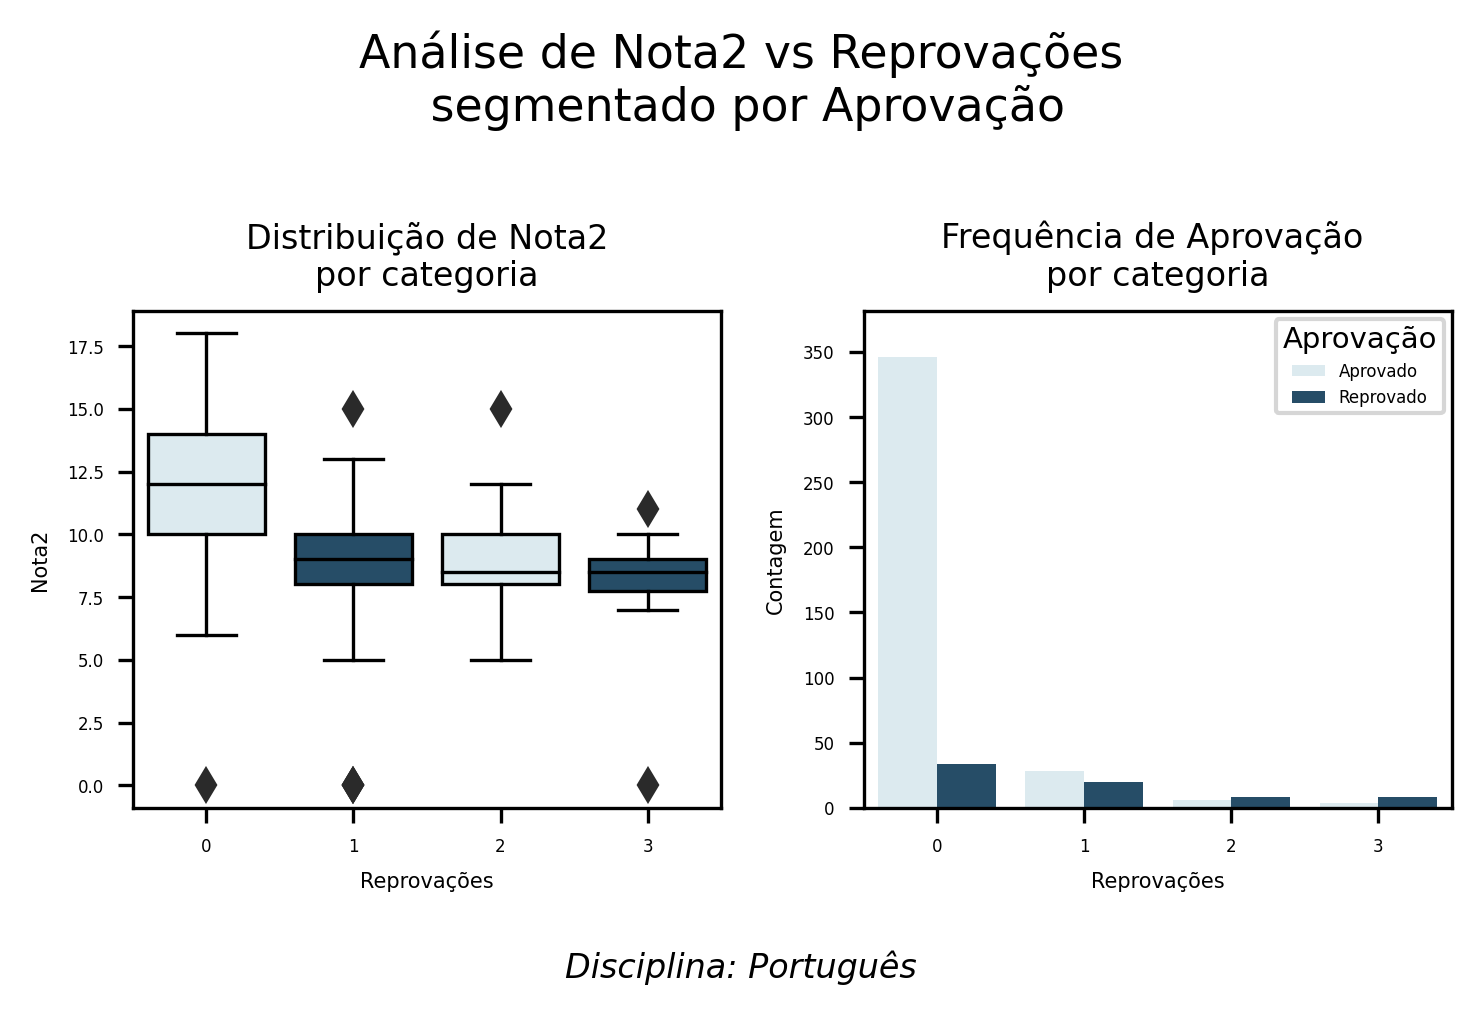

In [103]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota2')

##### **Nota Final**

[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.97
[FRACO] genero → equilíbrio: 0.59 | gap: 0.62
[MODERADO] endereco → desequilíbrio: 0.69 | gap: 1.23
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 1.94
[MODERADO] profissao_pai → desequilíbrio: 0.55 | gap: 2.20
[MODERADO] motivo_escolha_escola → desequilíbrio: 0.43 | gap: 1.78
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 1.32
[FRACO] apoio_familiar → equilíbrio: 0.62 | gap: 0.31
[FRACO] atividades_extracurriculares → equilíbrio: 0.52 | gap: 0.16
[FORTE] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 3.33
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


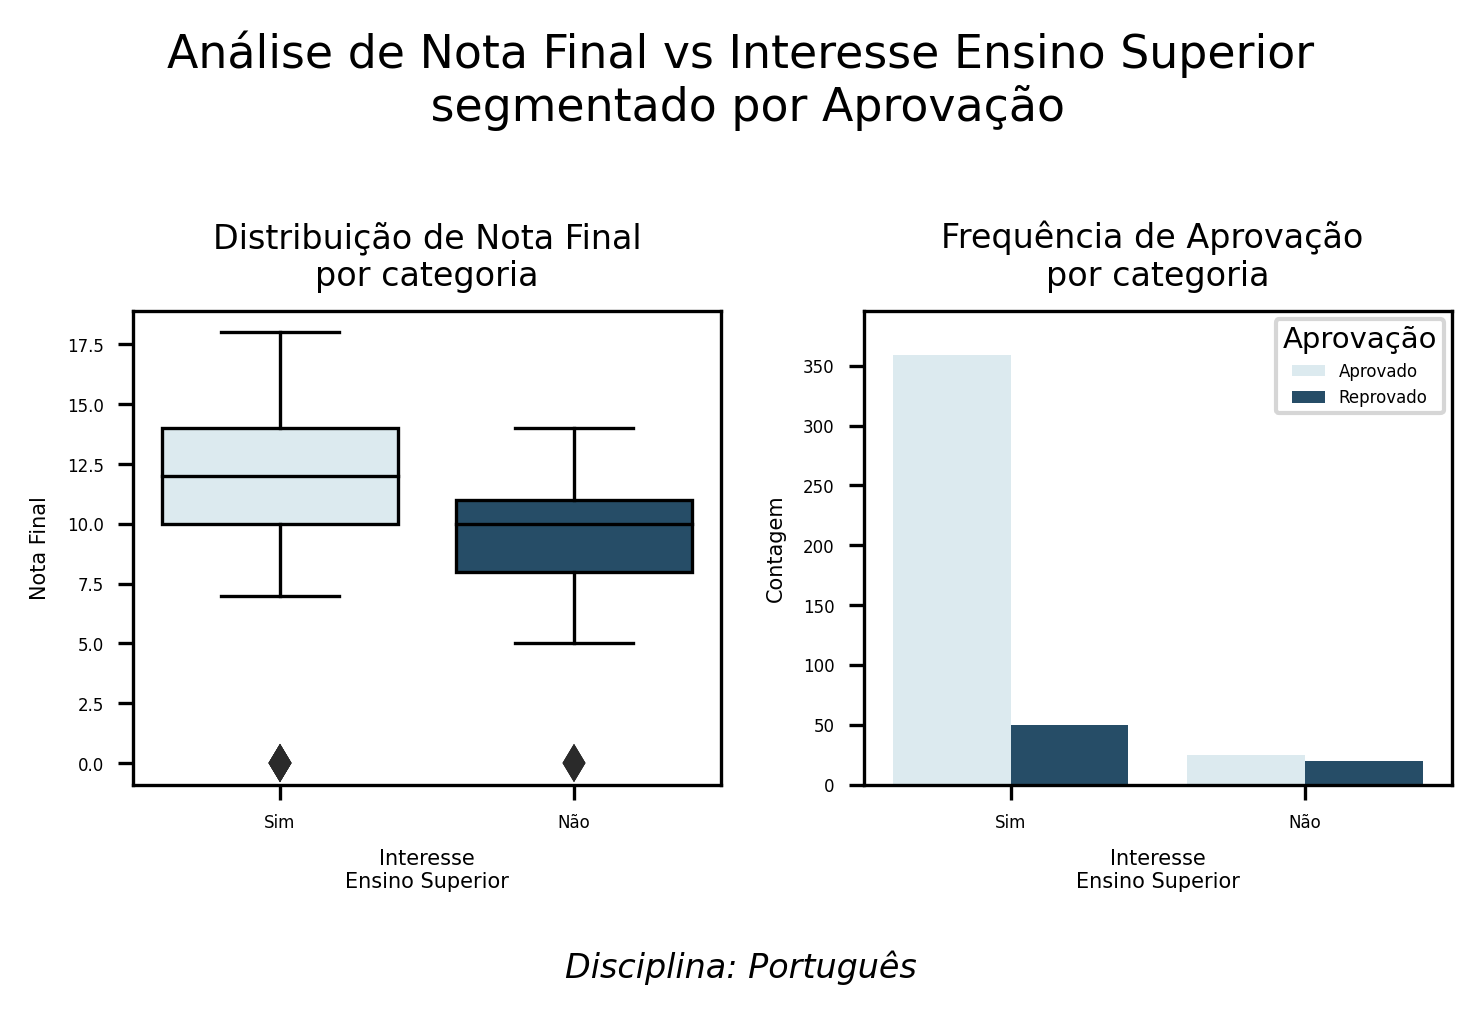

[MODERADO] acesso_internet → desequilíbrio: 0.77 | gap: 1.45
[FRACO] relacionamento_romantico → equilíbrio: 0.62 | gap: 0.51
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.10
[MODERADO] escolaridade_mae → desequilíbrio: 0.29 | gap: 1.96
[MODERADO] escolaridade_pai → desequilíbrio: 0.33 | gap: 1.98
[MODERADO] relacao_familiar → desequilíbrio: 0.48 | gap: 1.89
[MODERADO] tempo_livre → desequilíbrio: 0.36 | gap: 1.83
[MODERADO] frequencia_saidas → desequilíbrio: 0.32 | gap: 1.90
[FRACO] saude → equilíbrio: 0.39 | gap: 0.83
[MODERADO] tempo_estudo → desequilíbrio: 0.48 | gap: 2.31
[MODERADO] tempo_transporte → desequilíbrio: 0.57 | gap: 1.27
[MODERADO] alcool_dias_uteis → desequilíbrio: 0.71 | gap: 2.20
[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 1.52
[FORTE] reprovacoes → desequilíbrio: 0.84 | gap: 4.74
Erro ao criar subdiretório '': [WinError 3] O sistema não pode encontrar o caminho especificado: ''


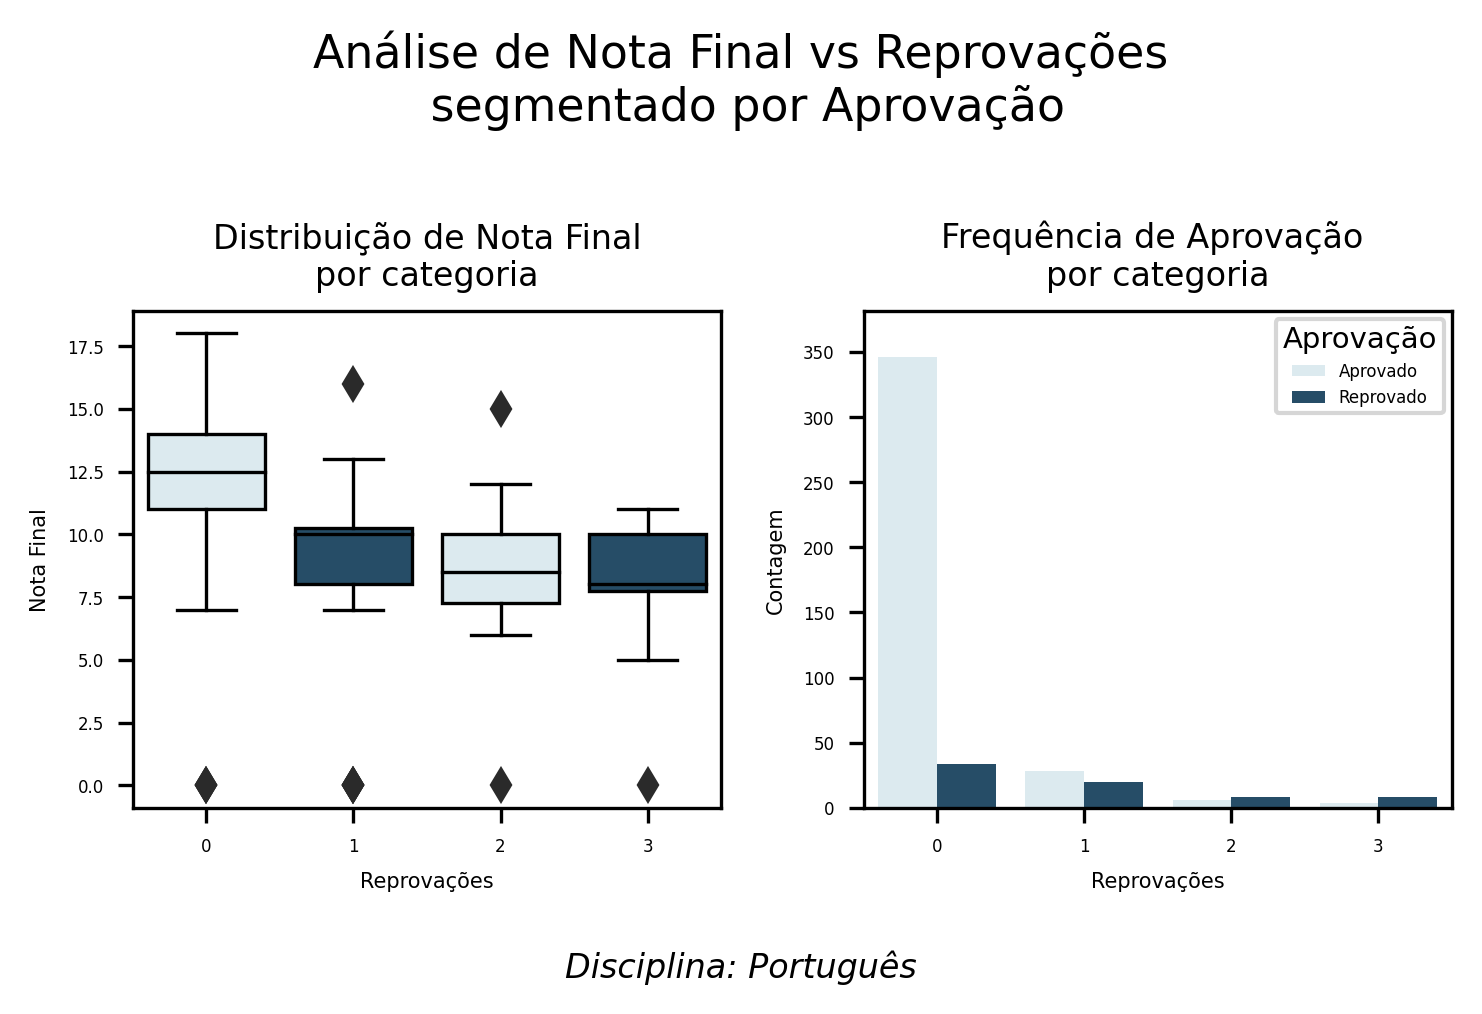

In [104]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='nota_final')

##### **Faltas**

[MODERADO] escola → desequilíbrio: 0.66 | gap: 1.78
[FRACO] genero → equilíbrio: 0.59 | gap: 0.04
[FRACO] endereco → equilíbrio: 0.69 | gap: 0.54
[MODERADO] status_parental → desequilíbrio: 0.87 | gap: 2.14
[MODERADO] profissao_mae → desequilíbrio: 0.39 | gap: 2.90
[FRACO] motivo_escolha_escola → equilíbrio: 0.43 | gap: 0.93
[MODERADO] responsavel_legal → desequilíbrio: 0.71 | gap: 3.42
[FRACO] apoio_familiar → equilíbrio: 0.62 | gap: 0.54
[FRACO] atividades_extracurriculares → equilíbrio: 0.52 | gap: 0.26
[MODERADO] interesse_ensino_superior → desequilíbrio: 0.90 | gap: 1.58
[FRACO] relacionamento_romantico → equilíbrio: 0.62 | gap: 0.21
[FRACO] tamanho_familia → equilíbrio: 0.70 | gap: 0.05
[MODERADO] escolaridade_pai → desequilíbrio: 0.33 | gap: 3.62
[MODERADO] relacao_familiar → desequilíbrio: 0.48 | gap: 2.00
[FRACO] tempo_livre → equilíbrio: 0.36 | gap: 1.02
[MODERADO] frequencia_saidas → desequilíbrio: 0.32 | gap: 1.78
[FRACO] saude → equilíbrio: 0.39 | gap: 0.92
[MODERADO] temp

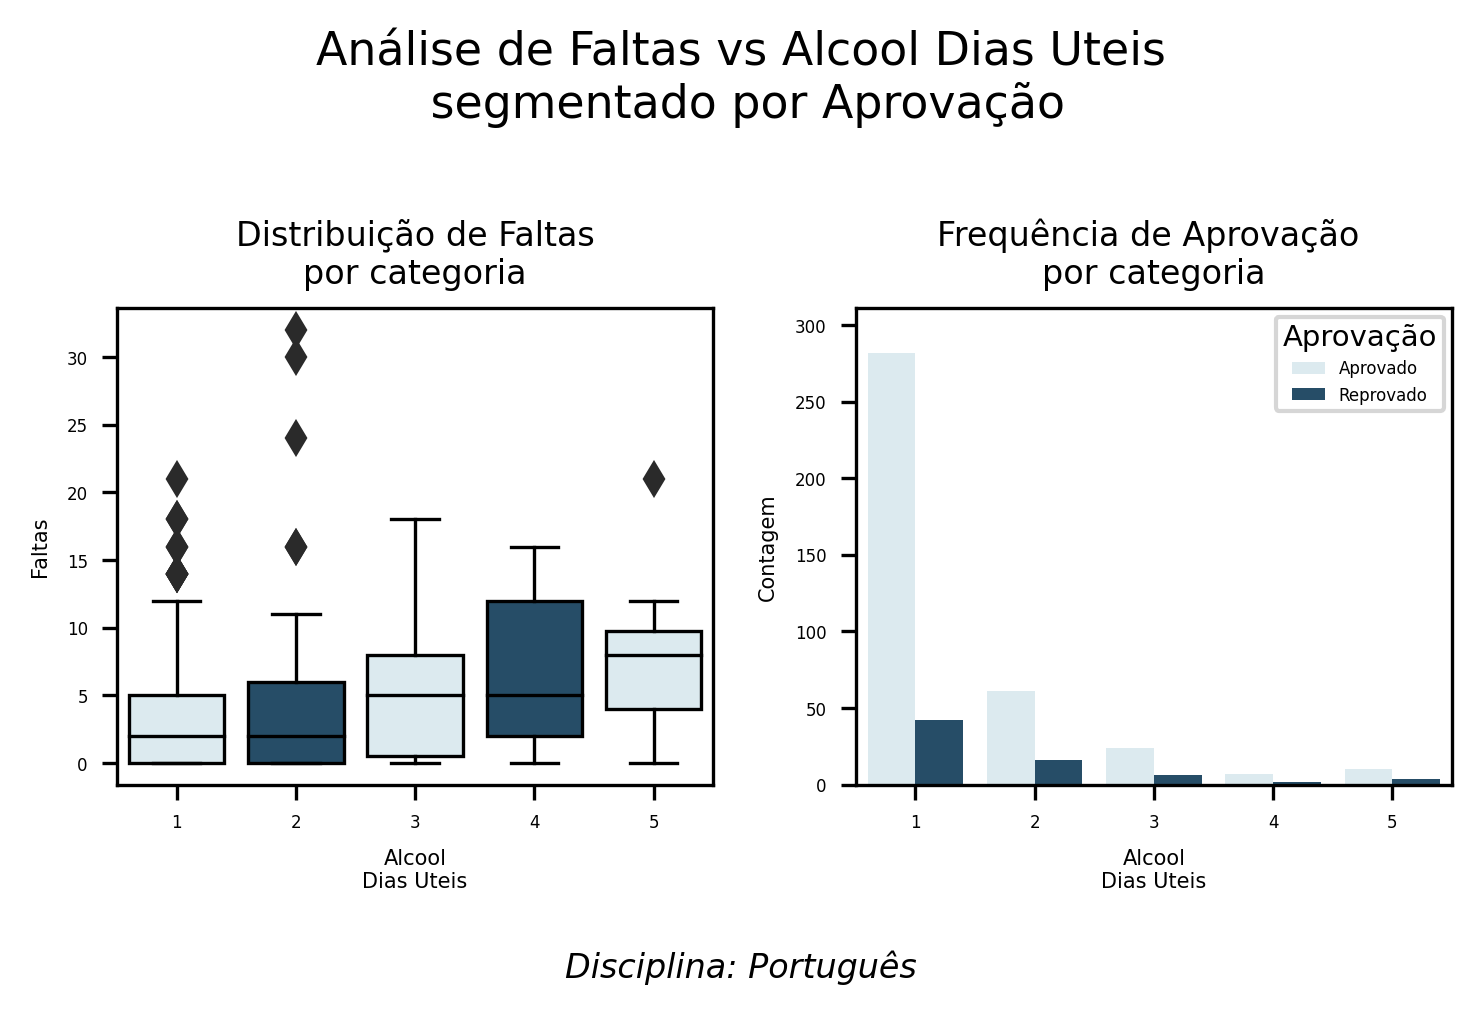

[MODERADO] alcool_fim_semana → desequilíbrio: 0.39 | gap: 2.66
[MODERADO] reprovacoes → desequilíbrio: 0.84 | gap: 2.29


In [105]:
selecao_impacto_variaveis_categoricas(df, 
                                    variaveis_categoricas,
                                    materia= materia,
                                    paleta=cores,
                                    coluna_avaliada='faltas')

# 4. Análise de Perfis Latentes via PCA e KMeans

Objetivo: Verificar se há perfis de alunos com características semelhantes com base nas variáveis selecionadas, por meio de técnicas de redução de dimensionalidade (PCA) e clusterização (KMeans).

## 4.2 Preparação dos Dados

In [106]:
df_pp = preparar_dados(df_t, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final',scaling=True)

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Aplicando Imputação(mean) e Scaling(StandardScaler) a: ['idade', 'escolaridade_mae', 'escolaridade_pai', 'tempo_transporte', 'tempo_estudo', 'reprovacoes', 'relacao_familiar', 'tempo_livre', 'frequencia_saidas', 'alcool_dias_uteis', 'alcool_fim_semana', 'saude', 'faltas']
Shape final do DataFrame preparado: (454, 40)


In [107]:
X = df_pp.drop(columns=['nota_final'])
y = df_pp['nota_final']


## 4.3 Aplicação do PCA

In [108]:

# Seleção dos dados 

pca = PCA()
X_pca = pca.fit_transform(X)


## 4.4 Clusterização com KMeans

### Definindo o número de clusters

In [109]:
from sklearn.metrics import silhouette_score

In [110]:
k_values = list(range(2, 9))
inercia = []
silhouette = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inercia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

# Cálculo da redução percentual da inércia
reducoes = np.diff(inercia) / inercia[:-1]
limiar = 0.15 #redução mínima esperada

# Determina melhor k pelo método do cotovelo
melhor_k_cotovelo = None
for k_idx, r in enumerate(reducoes, start=2):
    if abs(r) * 100 < limiar * 100 and melhor_k_cotovelo is None:
        melhor_k_cotovelo = k_idx
if melhor_k_cotovelo is None:
    melhor_k_cotovelo = k_values[-1]

# Melhor k pelo índice de silhueta
melhor_k_silhueta = k_values[np.argmax(silhouette)]


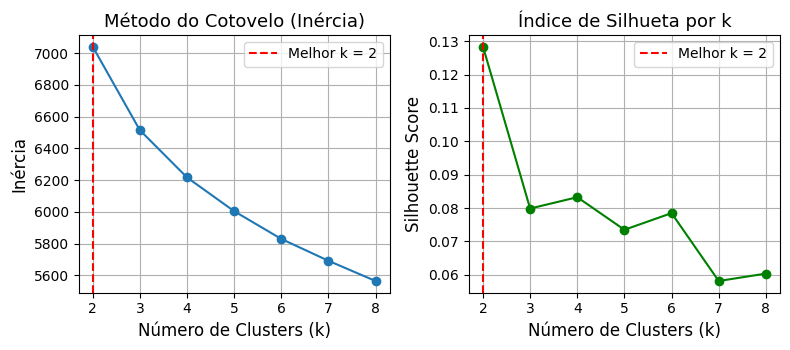

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.6))

# Tamanho da fonte
fs_ticks = 10
fs_labels = 12
fs_title = 13

# Cotovelo
axs[0].plot(k_values, inercia, marker='o')
axs[0].axvline(x=melhor_k_cotovelo, color='red', linestyle='--', label=f'Melhor k = {melhor_k_cotovelo}')
axs[0].set_title('Método do Cotovelo (Inércia)', fontsize=fs_title)
axs[0].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[0].set_ylabel('Inércia', fontsize=fs_labels)
axs[0].legend(fontsize=fs_ticks)
axs[0].set_xticks(k_values)
axs[0].tick_params(axis='both', labelsize=fs_ticks)
axs[0].grid(True)

# Silhueta
axs[1].plot(k_values, silhouette, marker='o', color='green')
axs[1].axvline(x=melhor_k_silhueta, color='red', linestyle='--', label=f'Melhor k = {melhor_k_silhueta}')
axs[1].set_title('Índice de Silhueta por k', fontsize=fs_title)
axs[1].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[1].set_ylabel('Silhouette Score', fontsize=fs_labels)
axs[1].legend(fontsize=fs_ticks)
axs[1].set_xticks(k_values)
axs[1].tick_params(axis='both', labelsize=fs_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [112]:
# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [113]:
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


#### Influência de Variáveis sobre o PCA

In [114]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['Componente 1', 'Componente 2'],
    index=X.columns)

loadings['Magnitude'] = loadings.apply(lambda x: np.sqrt(x['Componente 1']**2 + x['Componente 2']**2), axis=1)
loadings = loadings.sort_values(by='Magnitude', ascending=False)
loadings = loadings[loadings['Magnitude'] > 0.1]        
loadings = loadings.reset_index()
loadings.columns = ['Variável', 'Componente 1', 'Componente 2', 'Magnitude']
loadings

,Variável,Componente 1,Componente 2,Magnitude
0,escolaridade_mae,-0.289642,0.525850,0.600342
1,escolaridade_pai,-0.260084,0.520541,0.581899
2,alcool_fim_semana,0.421817,0.315478,0.526741
3,alcool_dias_uteis,0.428921,0.281161,0.512860
4,frequencia_saidas,0.329774,0.201140,0.386274
5,tempo_transporte,0.219506,-0.235822,0.322172
6,reprovacoes,0.276660,-0.142155,0.311045
7,tempo_estudo,-0.265447,-0.132474,0.296668
8,idade,0.255883,-0.050212,0.260763
9,faltas,0.194873,0.166908,0.256581


>---
> ### Interpretação do Componente Principal 1 (PC1)
>
> O primeiro componente (PC1) representa um eixo que opõe perfis estudantis mais estruturados àqueles com maior propensão a fatores de risco acadêmico e social.
>
> Estudantes com **valores mais altos em PC1** tendem a apresentar:
>
> - Maior consumo de álcool durante a semana e nos finais de semana;
> - Maior frequência de saídas sociais;
> - Menor tempo dedicado ao estudo;
> - Maior número de reprovações anteriores.
>
>Esses padrões sugerem um perfil associado a **menor engajamento escolar** e à possível **ausência de suporte familiar estruturado**, o que pode impactar negativamente 
>o desempenho acadêmico.
>
>Em contrapartida, **valores mais baixos em PC1** estão associados a estudantes com maior tempo de estudo e maior escolaridade dos pais, indicando um ambiente mais 
>favorável ao aprendizado.
>
>---

>---
> ### Interpretação do Componente Principal 2 (PC2)
> 
> O segundo componente (PC2) está fortemente associado à **escolaridade dos responsáveis**, refletindo um eixo de **capital educacional familiar**.
> 
> Estudantes com **valores mais altos em PC2** tendem a ter:
>
>- Pais com maior escolaridade (escolaridade da mãe e do pai);
>- Leve associação com consumo moderado de álcool nos finais de semana;
>- Menor tempo de transporte até a escola.
>
>Esse componente parece capturar um **perfil socioeducacional mais favorecido**, no qual o ambiente familiar oferece maior capital cultural e escolar.
>
>Já **valores mais baixos em PC2** indicam:
>
>- Menor escolaridade parental;
>- Tempo de transporte mais longo;
>- Menor tempo de estudo.
>
>Esses alunos tendem a enfrentar limitações estruturais, como baixa escolaridade dos pais e maior tempo de transporte até a escola, que dificultam o desempenho 
>acadêmico. Embora não apresentem necessariamente comportamentos de risco (como consumo de álcool ou faltas), esses fatores indicam um ambiente menos favorável ao 
>aprendizado.
>
>---

In [115]:
cores = aplicar_estilo_visual(paleta=cores,n =10)[::-1]

In [116]:
top_loadings = loadings.head(10)


### **Atributos mais influenciaram a estrutura de agrupamento no PCA**

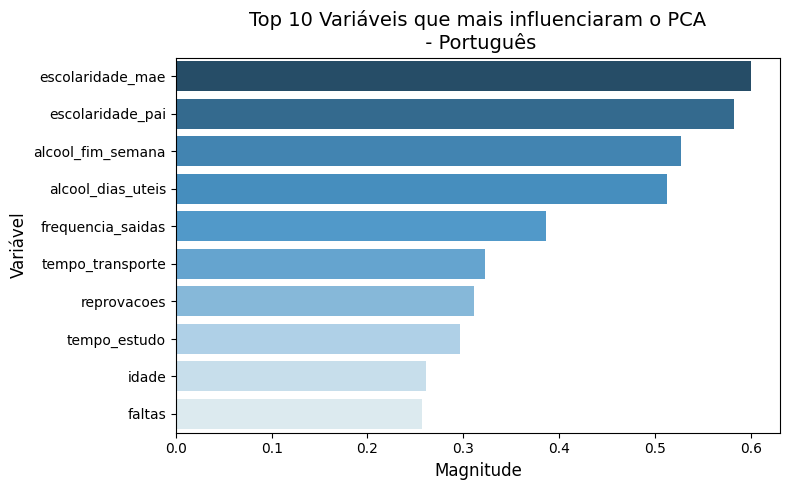

In [117]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Magnitude', y='Variável', data=top_loadings, palette=cores)

plt.title('Top 10 Variáveis que mais influenciaram o PCA\n - Português', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Variável', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


> PC1: alto peso para alcool_dias_uteis, alcool_fim_semana, frequencia_saidas (indicadores de comportamento social), além de reprovacoes e tempo_estudo.

> PC2: maior contribuição de escolaridade_mae, escolaridade_pai (indicadores de capital educacional familiar).

#### **k=2**

In [118]:
df['cluster_k2'] = KMeans(n_clusters=melhor_k_cotovelo, random_state=42).fit_predict(X_pca)

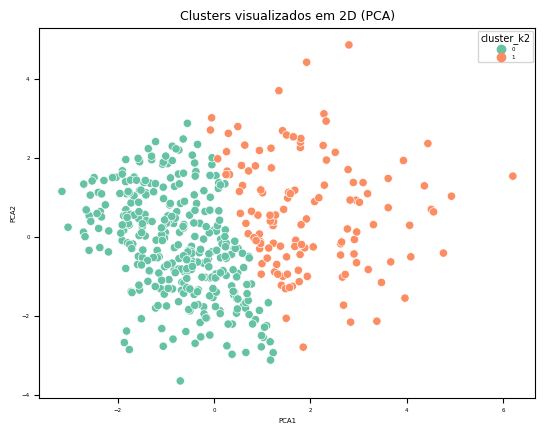

In [119]:
df['cluster_k2'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# 5. Visualiza os clusters  
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k2', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


## 4.6 Análise dos Clusters

In [120]:
pca.explained_variance_ratio_

array([0.14250705, 0.11113889])

> O segundo componente principal (PC2) também contribui para a explicação da variância nos dados e representa, majoritariamente, um eixo de capital educacional familiar. Alunos com valores mais altos em PC2 tendem a ter pais mais escolarizados e enfrentam menos barreiras logísticas (menor tempo de transporte), o que pode refletir em condições mais favoráveis ao desempenho escolar. Embora sua influência seja menor que a do PC1, o PC2 complementa a análise ao incorporar aspectos socioeconômicos e de infraestrutura familiar no entendimento dos agrupamentos revelados.


### **Detalhamento dos Perfis**

In [121]:
add_features_describe_pd(df[df['cluster_k2']==0], estudo_frequencia=True, colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 329


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,227,68.99696,0.607903
genero,2,Mulher,224,68.085106,0.607903
endereco,2,Urbano,243,73.860182,0.607903
status_parental,2,Juntos,286,86.930091,0.607903
profissao_mae,5,Outra profissão,133,40.425532,1.519757
profissao_pai,5,Outra profissão,179,54.407295,1.519757
motivo_escolha_escola,4,Curso específico,129,39.209726,1.215805
responsavel_legal,3,Mãe,235,71.428571,0.911854
apoio_escolar,2,Não,287,87.234043,0.607903


> ### Perfil dominante no Cluster 0 (valores mais baixos em PC1 e mais altos em PC2)  
>  
> A análise das variáveis categóricas dominantes no `cluster_k2 = 0`, que corresponde aos estudantes com valores mais baixos em PC1 e mais altos em PC2, reforça a interpretação anterior. Os estudantes desse grupo apresentam:  
>  
> - Maior suporte familiar e intenção de cursar o ensino superior;  
> - Quase nenhuma reprovação;  
> - Baixo consumo de álcool;  
> - Maior tempo de estudo;  
> - Predominância do sexo feminino e residência em área urbana.  
>  
> Essas características corroboram o entendimento de que o **PC1 separa os alunos entre perfis mais disciplinados e engajados versus perfis com maior exposição a 
>comportamentos de risco**, enquanto o **PC2 diferencia os estudantes com maior capital educacional familiar e menos barreiras estruturais** daqueles em contextos 
>potencialmente mais limitantes para o aprendizado.



In [122]:
add_features_describe_pd(df[df['cluster_k2']==1], estudo_frequencia=True, colunas=variaveis_categoricas)

Tamanho da amostra (categórico): 125


,Total de Categorias,Categoria Dominante,Frequência Absoluta,Frequência Relativa Dominante(%),Diversidade de Categorias (%)
Variável,,,,,
escola,2,Gabriel Pereira,72,57.6,1.6
genero,2,Homem,82,65.6,1.6
endereco,2,Urbano,72,57.6,1.6
status_parental,2,Juntos,109,87.2,1.6
profissao_mae,5,Outra profissão,46,36.8,4.0
profissao_pai,5,Outra profissão,72,57.6,4.0
motivo_escolha_escola,4,Curso específico,64,51.2,3.2
responsavel_legal,3,Mãe,87,69.6,2.4
apoio_escolar,2,Não,118,94.4,1.6


> ### Perfil dominante no Cluster 1 (valores mais altos em PC1 e baixo PC2)  
>  
> O `cluster_k2 = 1`, correspondente aos estudantes com valores mais altos em PC1, apresenta um perfil que reforça a interpretação de maior exposição a fatores de risco acadêmico e social. Os estudantes deste grupo se caracterizam por:  
>  
> - Maior proporção de homens;  
> - Tempo de estudo mais reduzido;  
> - Frequência mais elevada de saídas sociais e maior consumo de álcool (principalmente aos finais de semana);  
> - Escolaridade mais baixa dos pais;  
> - Participação em atividades extracurriculares, mas com menor apoio familiar;  
> - Maior incidência de reprovações anteriores.  
>  
> Esses elementos indicam um contexto potencialmente menos estruturado para o aprendizado, com menor capital educacional familiar e comportamentos associados a menor engajamento escolar.


In [123]:
df[['idade','cluster_k2']].value_counts().reset_index()

,idade,cluster_k2,0
0,16,0,106
1,17,0,79
2,15,0,70
3,18,0,61
4,17,1,40
5,18,1,35
6,16,1,22
7,15,1,13
8,19,0,11
9,19,1,11


> ### Idade e perfis dos clusters  
>  
> A distribuição de idade entre os clusters mostra um padrão coerente com as interpretações anteriores. O `cluster_k2 = 0` (baixo PC1, alto PC2) concentra estudantes majoritariamente entre 15 e 17 anos, sugerindo que estão na faixa etária esperada para o ensino médio regular.  
>  
> Já o `cluster_k2 = 1` (alto PC1, baixo PC2) apresenta proporção mais elevada de alunos com 18 anos ou mais, indicando a presença de **atraso escolar**, possivelmente associado a **reprovações anteriores** e maior fragilidade no suporte ao aprendizado.  
>  
> Essa relação entre idade e agrupamento reforça a ideia de que os componentes principais e os clusters capturaram **diferenças reais nos perfis educacionais dos estudantes**.


### **Desempenho**

In [124]:
df.groupby('cluster_k2')[['nota1','nota2','nota_final','faltas']].agg(['mean', 'std', 'count'])



nota1                      nota2                 nota_final  \
                mean       std count       mean       std count       mean   
cluster_k2                                                                   
0           11.93617  2.758391   329  12.042553  2.927688   329  12.486322   
1           10.21600  2.234567   125  10.304000  2.356268   125  10.552000   

                              faltas                  
                 std count      mean       std count  
cluster_k2                                            
0           3.021361   329  3.018237  3.894920   329  
1           2.982357   125  6.088000  5.926997   125

In [125]:
pd.crosstab(df['cluster_k2'], df['aprovacao'], normalize='index') * 100


aprovacao,Aprovado,Reprovado
cluster_k2,,
0,89.361702,10.638298
1,72.000000,28.000000


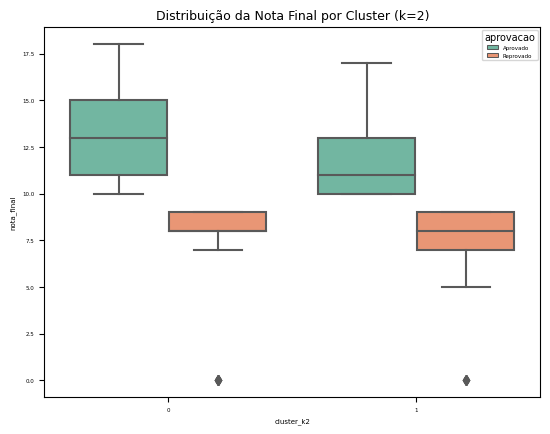

In [126]:

# Gráfico de dispersão
sns.boxplot(data=df, x='cluster_k2', y='nota_final', hue='aprovacao',palette='Set2')
plt.title('Distribuição da Nota Final por Cluster (k=2)')
plt.show()


> ### Desempenho acadêmico e presença em sala por cluster  
>  
> A média das notas (nota1, nota2 e nota final) e a taxa de aprovação confirmam a distinção entre os grupos revelados pelo PCA + KMeans:
>  
> - **Cluster 0** (baixo PC1, alto PC2):  
>     - Média da nota final: **12.49**  
>     - Faltas médias: **3.02**  
>     - Taxa de aprovação: **89,4%**
>  
> - **Cluster 1** (alto PC1, baixo PC2):  
>     - Média da nota final: **10.55**  
>     - Faltas médias: **6.09**  
>     - Taxa de aprovação: **72,0%**
>  
> O gráfico reforça visualmente que os alunos do **cluster 0** têm notas mais altas, menor dispersão negativa e maior proporção de aprovados. Já os alunos do 
>**cluster 1** apresentam desempenho inferior, mais faltas e maior taxa de reprovação.  
>  

## 4.7 Conclusão da Análise de Perfis (PCA + KMeans)

A análise multivariada revelou dois grupos latentes entre os estudantes com perfis significativamente distintos. O Cluster 0 concentrou alunos com maior desempenho, mais apoio familiar, menos reprovações e comportamentos mais estruturados. Já o Cluster 1 agregou estudantes com mais dificuldades escolares, histórico de reprovação e menor tempo de estudo. 

As variáveis com maior contribuição nos componentes principais reforçaram a importância de aspectos comportamentais (como consumo de álcool), apoio familiar e escolaridade dos pais como dimensões estruturantes dos perfis. 

# 5. SELEÇÃO DE VARIÁVEIS PARA MODELAGEM (Baseada na EDA)

A Análise Exploratória de Dados (EDA) forneceu recursos para a seleção de um conjunto inicial de variáveis candidatas à modelagem preditiva binária da aprovação em Língua Portuguesa. De maneira geral, nos modelos de classificação, optou-se por **não utilizar variáveis diretamente relacionadas às notas (`nota1`, `nota2`, `nota_final`)**, tanto por questões de vazamento de alvo (target leakage) quanto por interesse em identificar determinantes socioeducacionais independentes do desempenho diretamente mensurado.

A seleção foi guiada por critérios estatísticos, frequenciais e diferenciais observados durante a EDA, como:

- **Índice de Perfil Composto de Aprovação:** métrica própria que considera frequência, diversidade e disparidade entre aprovados e reprovados;
- **Análise da taxa de aprovação por categoria de cada variável**;
- **Correlação das variáveis com o binário de aprovação (`aprovacao`)**, quando apropriado;
- **Gap de desempenho em grupos extremos (ex: taxa de aprovação ≥95% vs ≤70%)**.

Além disso, foi realizado um refinamento conceitual e estatístico adicional, com foco em:
- Exclusão de variáveis altamente correlacionadas entre si;
- Preferência por variáveis com melhor poder discriminatório;
- Redução da redundância sem comprometer a diversidade de informações.

---

## **1. Variáveis Quantitativas (sem notas):**

* **Faltas (`faltas`)**  
  Indicador importante de comprometimento escolar. Manteve associação negativa consistente com aprovação.  
* **Idade (`idade`)**  
  Retida por apresentar padrão independente e potencialmente complementar às faltas, especialmente em contextos de defasagem escolar.

---

## **2. Variáveis Categóricas com Forte Associação à Aprovação:**

* `reprovacoes` – Variável mais discriminante; diferenças extremas nas taxas de aprovação.  
* `tempo_estudo` – Forte relação direta com aprovação, sem sobreposição com outras variáveis.  
* `interesse_ensino_superior` – Indicador de motivação com alto poder discriminatório.  
* `escolaridade_mae` – Preferida em relação à `escolaridade_pai` por apresentar maior consistência estatística.

---

## **3. Variáveis Mantidas Após Comparação Direta ou Conflito com Outras:**

* `alcool_dias_uteis` — Retida no lugar de `alcool_fim_semana` por apresentar maior impacto na aprovação e menor correlação com `frequencia_saidas`.  
* `apoio_escolar` — Mantida apesar da relação inversa; poderá ajudar a identificar padrões ocultos de dificuldade escolar.  
* `frequencia_saidas` — Retida como indicador comportamental complementar ao consumo de álcool.  
* `acesso_internet` — Forte diferencial de aprovação (87.5% com vs 72.2% sem); mantida por ser diretamente interpretável.  
* `relacao_familiar` — Indicador socioafetivo com impacto visível nas taxas de aprovação.  

---

## **4. Variáveis Excluídas ou Fundidas no Processo de Refinamento:**

* `alcool_fim_semana` — Excluída por redundância com `alcool_dias_uteis` (alta correlação conceitual e estatística).  
* `escolaridade_pai` — Removida em favor da escolaridade materna, mais informativa e diversificada.  
* `profissao_mae`, `motivo_escolha_escola` — Impacto mais localizado e difícil de generalizar.  
* `status_parental`, `tamanho_familia`, `endereco` — Variáveis com baixa diversidade, distribuição desbalanceada ou impacto estatístico limitado.

---

## **5. Variáveis Complementares com Potencial para Interações:**

* `apoio_familiar` — Mantida apesar do impacto isolado discreto, devido à relevância contextual e potencial sinergia com `relacao_familiar`.

---

## **6. Conjunto Final Selecionado (16 variáveis):**

| Tipo           | Variável                    | Justificativa resumida                             |
|----------------|-----------------------------|----------------------------------------------------|
| Quantitativa   | `faltas`                    | Indicador direto de envolvimento escolar.          |
| Quantitativa   | `idade`                     | Relacionada à defasagem e histórico escolar.       |
| Categórica     | `reprovacoes`               | Variável mais discriminante da base.               |
| Categórica     | `tempo_estudo`              | Ligada a maior empenho e taxa de aprovação.        |
| Categórica     | `interesse_ensino_superior` | Forte motivador de desempenho escolar.             |
| Categórica     | `escolaridade_mae`          | Proxy de capital educacional e socioeconômico.     |
| Categórica     | `alcool_dias_uteis`         | Relacionada a risco acadêmico/comportamental.      |
| Categórica     | `apoio_escolar`             | Identifica alunos em dificuldade (padrão inverso). |
| Categórica     | `frequencia_saidas`         | Indicador de exposição social e foco nos estudos.  |
| Categórica     | `escola`                    | Contexto institucional com variação significativa. |
| Categórica     | `apoio_familiar`            | Potencial moderador de desempenho.                 |
| Categórica     | `relacao_familiar`          | Ambiente emocional/doméstico do aluno.             |
| Categórica     | `acesso_internet`           | Indicador de infraestrutura para estudo.           |
| Categórica     | `genero`                      | Controlador sociodemográfico básico.               |
| Categórica     | `atividade_extra_curriculares` | Pode refletir organização de tempo e estímulo.     |

---

## **7. Próximos Passos:**

Esse conjunto final será submetido a:
- Avaliação de multicolinearidade e codificação adequada (One-Hot/Ordinal);
- Modelagem com validação cruzada estratificada;
- Análise de importância dos atributos e impacto marginal de exclusões adicionais;
- Exploração de interações e criação de variáveis compostas caso necessário.
.

In [127]:
# Variáveis que serão utilizadas para a seleção de atributos
# na modelagem com base na EDA
selecao_baseada_em_eda_por = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior", "escolaridade_mae",
    "alcool_dias_uteis", "apoio_escolar", "frequencia_saidas", "escola",
    "apoio_familiar", "relacao_familiar", "acesso_internet",
    "genero", "atividades_extracurriculares"]
